<a href="https://colab.research.google.com/github/zbransi/solar_moving_magnetic_features/blob/main/grapher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install sunpy[map]
%pip install reproject
%shell apt update && apt install texlive-latex-recommended texlive-latex-extra texlive-fonts-recommended dvipng -y
%shell apt-get install cm-super -y
!pip install --upgrade gspread gspread-dataframe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.2/195.2 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.9/378.9 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 kB 6.3 MB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://cli.github.com/packages stable InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 htt

In [ ]:
import pandas as pd
from astropy.io import fits
from sunpy.map import Map, MapSequence
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from ast import literal_eval as le
from matplotlib.backends.backend_pdf import PdfPages
from scipy.ndimage import label, center_of_mass
from skimage.measure import find_contours
import sunpy.visualization.colormaps as cm
import gspread
from google.colab import auth
from gspread_dataframe import get_as_dataframe
from google.auth import default
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})

In [ ]:
BEST_FRAME = []
def load_fits(t='cont'):
    ls = []
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)
    sheet_url = "https://docs.google.com/spreadsheets/d/1Rj1zhveaZPsvFlkz_GijTGWhY-MwyFLhKxPmswkDlRA/edit?gid=0#gid=0"
    sh = gc.open_by_url(sheet_url)
    worksheet = sh.sheet1
    frame_dat = get_as_dataframe(worksheet, header=None)
    best_frame = frame_dat.iloc[:, 0].to_numpy()
    hdul = fits.open(f"/content/drive/MyDrive/DATA_LM/coaligned_data/{t}.fits")
    hdul = hdul[1:]
    for i, hdu in enumerate(hdul):
        if i in best_frame:
            BEST_FRAME.append(i)
            data = hdu.data
            meta = hdu.header
            ls.append(Map(data, meta))

    return MapSequence(ls)

ms_bz = load_fits('bz')
ms_2796 = load_fits('2796')
ms_1400 = load_fits('1400')
ms_1330 = load_fits('1330')

In [ ]:
def flux_at(m, data):
    mask = data[data > 0]

    arcsec_per_pixel_x = m.meta['cdelt1']
    arcsec_per_pixel_y = m.meta['cdelt2']

    km_per_arcsec = 760
    cm_per_km = 10 ** 5
    area_per_arcsec_2 = ((km_per_arcsec * cm_per_km) ** 2) * arcsec_per_pixel_x * arcsec_per_pixel_y
    pixel_flux = []
    for b in mask:
        if b:
            pixel_flux.append(b * area_per_arcsec_2)

    total_flux = sum(pixel_flux)
    return total_flux

def neg_flux_at(m, data):
    mask = data[data < 0]

    arcsec_per_pixel_x = m.meta['cdelt1']
    arcsec_per_pixel_y = m.meta['cdelt2']

    km_per_arcsec = 760
    cm_per_km = 10 ** 5
    area_per_arcsec_2 = ((km_per_arcsec * cm_per_km) ** 2) * arcsec_per_pixel_x * arcsec_per_pixel_y
    pixel_flux = []
    for b in mask:
        if b:
            pixel_flux.append(b * area_per_arcsec_2)

    total_flux = sum(pixel_flux)
    return - total_flux

In [ ]:
def add_center_pix(mmf, bl, data):
    if mmf['pol'] >= 0:
        top_threshold = np.percentile(data, 95)
    if mmf['pol'] <= 0:
        bottom_threshold = np.percentile(data, 5)

    if mmf['pol'] == 0:
        mask = (data <= bottom_threshold) | (data >= top_threshold)
    if mmf['pol'] == 1:
        mask = (data >= top_threshold)
    if mmf['pol'] == -1:
        mask = (data <= bottom_threshold)

    coords = np.argwhere(mask)
    if coords.size > 0:
        avg_y, avg_x = coords.mean(axis=0)
        center_x = int(avg_x) + bl[1]
        center_y = int(avg_y) + bl[0]

    return [center_y], [center_x]

In [ ]:
def make_pdfs(mmf, ident, size):
    BL_COORDS = []
    if mmf['pol'] == 0:
        polarity = 'Bi-Polar'
    elif mmf['pol'] == 1:
        polarity = 'Positive'
    else:
        polarity = 'Negative'
    titles = ['Magnetic Field', r'2796 $\AA$', r'1400 $\AA$', r'1330 $\AA$']
    cmaps = ['gray', 'irissji2796', 'irissji1400', 'irissji1330']

    with PdfPages(f"/content/drive/MyDrive/DATA_LM/outlines/{ident}.pdf") as pdf:
        bl = mmf['bl']
        tr = mmf['tr']
        for index in mmf['frames']:
            m1 = ms_bz.maps[index]
            m2 = ms_2796.maps[index]
            m3 = ms_1400.maps[index]
            m4 = ms_1330.maps[index]

            [center_y], [center_x] = add_center_pix(mmf, bl, m1.data[bl[0]:tr[0], bl[1]:tr[1]])

            total_height, total_width = mmf['dims']
            if int(center_x + (total_width / 2)) > m1.data.shape[1] - 1:
                center_x = int(m1.data.shape[1] - (total_width / 2)) - 1
            elif int(center_x - (total_width / 2)) < 0:
                center_x = int(total_width / 2)
            elif int(center_y + (total_height / 2)) > m1.data.shape[0] - 1:
                center_y = int(m1.data.shape[0] - (total_height / 2)) - 1
            elif int(center_y - (total_height / 2)) < 0:
                center_y = int(total_height / 2)

            new_bl = (int(center_y - (total_height / 2)), int(center_x - (total_width / 2)))
            BL_COORDS.append(new_bl)

            rect1, rect2, rect3, rect4 = [Rectangle(
                (new_bl[1], new_bl[0]), total_width, total_height,
                edgecolor='green', facecolor='none', linewidth=1) for _ in range(4)]

            fig = plt.figure(figsize=(14, 8))

            ax1 = plt.subplot(141, projection=m1.wcs)
            m1.plot(axes=ax1, vmin=-1000, vmax=1000, cmap='gray')
            ax1.add_patch(rect1)

            ax2 = plt.subplot(142, projection=m2.wcs)
            m2.plot(axes=ax2)
            ax2.add_patch(rect2)

            maximum = np.max(m3.data) if np.max(m3.data) < 150 else 150
            ax3 = plt.subplot(143, projection=m3.wcs)
            m3.plot(axes=ax3, vmax=maximum)
            ax3.add_patch(rect3)

            maximum = np.max(m4.data) if np.max(m4.data) < 50 else 50
            ax4 = plt.subplot(144, projection=m4.wcs)
            m4.plot(axes=ax4, vmax=maximum)
            ax4.add_patch(rect4)
            plt.suptitle(f"Moving Magnetic Feature {ident}, {polarity}", y=0.95, fontsize=18)

            pdf.savefig(fig)
            plt.close(fig)

    with PdfPages(f"/content/drive/MyDrive/DATA_LM/frames/{ident}.pdf") as pdf:
        for i, bl in enumerate(BL_COORDS):
            index = mmf['frames'][i]
            m1 = ms_bz.maps[index]
            m2 = ms_2796.maps[index]
            m3 = ms_1400.maps[index]
            m4 = ms_1330.maps[index]

            def pixel_to_sm(m, bl, dims):
                import astropy.units as u
                tr = (bl[0] + dims[0], bl[1] + dims[1])
                bl_coord = m.pixel_to_world(bl[1] * u.pixel, bl[0] * u.pixel)
                tr_coord = m.pixel_to_world(tr[1] * u.pixel, tr[0] * u.pixel)

                sm = m.submap(bl_coord, top_right=tr_coord)
                return sm

            sm1 = pixel_to_sm(m1, bl, mmf['dims'])
            sm2 = pixel_to_sm(m2, bl, mmf['dims'])
            sm3 = pixel_to_sm(m3, bl, mmf['dims'])
            sm4 = pixel_to_sm(m4, bl, mmf['dims'])

            sm_ls = [sm1, sm2, sm3, sm4]

            fig, axs = plt.subplots(1, 4, figsize=(16, size))
            for i, ax in enumerate(axs):
                dat = np.flipud(sm_ls[i].data)
                cmap = matplotlib.colormaps[cmaps[i]]
                if i == 0:
                    ax.imshow(dat, cmap=cmap, vmin=-1000, vmax=+1000)
                else:
                    ax.imshow(dat, cmap=cmap)
                meta = sm_ls[i].meta
                ax.set_xlabel(f"{meta['date_obs']}")
                ax.set_title(f"{meta['telescop']} {meta['instrume']} {titles[i]}")
                ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

            plt.suptitle(f"Moving Magnetic Feature {ident}, Bi-Polarity", y=0.93, fontsize=18)

            pdf.savefig(fig)
            plt.close(fig)

In [ ]:
def view_before_after(mmf, ident, size):
    BL_COORDS = []
    if mmf['pol'] == 0:
        polarity = 'Bi-Polar'
    elif mmf['pol'] == 1:
        polarity = 'Positive'
    else:
        polarity = 'Negative'
    titles = ['Magnetic Field', r'2796 $\AA$', r'1400 $\AA$', r'1330 $\AA$']
    cmaps = ['gray', 'irissji2796', 'irissji1400', 'irissji1330']

    with PdfPages(f"/content/drive/MyDrive/DATA_LM/outlines/{ident}.pdf") as pdf:
        bl = mmf['bl']
        tr = mmf['tr']
        for index in mmf['frames']:
            m1 = ms_bz.maps[index]
            m2 = ms_2796.maps[index]
            m3 = ms_1400.maps[index]
            m4 = ms_1330.maps[index]

            [center_y], [center_x] = add_center_pix(mmf, bl, m1.data[bl[0]:tr[0], bl[1]:tr[1]])

            total_height, total_width = mmf['dims']
            if int(center_x + (total_width / 2)) > m1.data.shape[1] - 1:
                center_x = int(m1.data.shape[1] - (total_width / 2)) - 1
            elif int(center_x - (total_width / 2)) < 0:
                center_x = int(total_width / 2)
            elif int(center_y + (total_height / 2)) > m1.data.shape[0] - 1:
                center_y = int(m1.data.shape[0] - (total_height / 2)) - 1
            elif int(center_y - (total_height / 2)) < 0:
                center_y = int(total_height / 2)

            new_bl = (int(center_y - (total_height / 2)), int(center_x - (total_width / 2)))
            BL_COORDS.append(new_bl)

            rect1, rect2, rect3, rect4 = [Rectangle(
                (new_bl[1], new_bl[0]), total_width, total_height,
                edgecolor='green', facecolor='none', linewidth=1) for _ in range(4)]

            fig = plt.figure(figsize=(14, 8))

            ax1 = plt.subplot(141, projection=m1.wcs)
            m1.plot(axes=ax1, vmin=-1000, vmax=1000, cmap='gray')
            ax1.add_patch(rect1)

            ax2 = plt.subplot(142, projection=m2.wcs)
            m2.plot(axes=ax2)
            ax2.add_patch(rect2)

            maximum = np.max(m3.data) if np.max(m3.data) < 150 else 150
            ax3 = plt.subplot(143, projection=m3.wcs)
            m3.plot(axes=ax3, vmax=maximum)
            ax3.add_patch(rect3)

            maximum = np.max(m4.data) if np.max(m4.data) < 50 else 50
            ax4 = plt.subplot(144, projection=m4.wcs)
            m4.plot(axes=ax4, vmax=maximum)
            ax4.add_patch(rect4)
            plt.suptitle(f"Moving Magnetic Feature {ident}, {polarity}", y=0.95, fontsize=18)

            pdf.savefig(fig)
            plt.close(fig)

    with PdfPages(f"/content/drive/MyDrive/DATA_LM/frames/{ident}.pdf") as pdf:
        for i, bl in enumerate(BL_COORDS):
            index = mmf['frames'][i]
            m1 = ms_bz.maps[index]
            m2 = ms_2796.maps[index]
            m3 = ms_1400.maps[index]
            m4 = ms_1330.maps[index]

            def pixel_to_sm(m, bl, dims):
                import astropy.units as u
                tr = (bl[0] + dims[0], bl[1] + dims[1])
                bl_coord = m.pixel_to_world(bl[1] * u.pixel, bl[0] * u.pixel)
                tr_coord = m.pixel_to_world(tr[1] * u.pixel, tr[0] * u.pixel)

                sm = m.submap(bl_coord, top_right=tr_coord)
                return sm

            sm1 = pixel_to_sm(m1, bl, mmf['dims'])
            sm2 = pixel_to_sm(m2, bl, mmf['dims'])
            sm3 = pixel_to_sm(m3, bl, mmf['dims'])
            sm4 = pixel_to_sm(m4, bl, mmf['dims'])

            sm_ls = [sm1, sm2, sm3, sm4]

            fig, axs = plt.subplots(1, 4, figsize=(16, size))
            for i, ax in enumerate(axs):
                dat = np.flipud(sm_ls[i].data)
                cmap = matplotlib.colormaps[cmaps[i]]
                if i == 0:
                    ax.imshow(dat, cmap=cmap, vmin=-1000, vmax=+1000)
                else:
                    ax.imshow(dat, cmap=cmap)
                meta = sm_ls[i].meta
                ax.set_xlabel(f"{meta['date_obs']}")
                ax.set_title(f"{meta['telescop']} {meta['instrume']} {titles[i]}")
                ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

            plt.suptitle(f"Moving Magnetic Feature {ident}, Bi-Polarity", y=0.93, fontsize=18)

            pdf.savefig(fig)
            plt.close(fig)

In [ ]:
def make_pdfs_graphs(mmf, ident, size):
    BL_COORDS = []
    if mmf['pol'] == 0:
        polarity = 'Bi-Polar'
    elif mmf['pol'] == 1:
        polarity = 'Positive'
    else:
        polarity = 'Negative'
    titles = ['Magnetic Field', r'2796 $\AA$', r'1400 $\AA$', r'1330 $\AA$']
    cmaps = ['gray', 'irissji2796', 'irissji1400', 'irissji1330']
    from datetime import datetime
    times = []
    pos_fluxes = []
    neg_fluxes = []
    luminosity_2796 = []
    luminosity_1400 = []
    luminosity_1330 = []

    def flux_at(m, pol=1):
        data = m.data
        if pol > 0:
            mask = data[data > 0]
        else:
            mask = data[data < 0]

        arcsec_per_pixel_x = m.meta['cdelt1']
        arcsec_per_pixel_y = m.meta['cdelt2']

        km_per_arcsec = 760
        cm_per_km = 10 ** 5
        area_per_arcsec_2 = ((km_per_arcsec * cm_per_km) ** 2) * arcsec_per_pixel_x * arcsec_per_pixel_y
        pixel_flux = []
        for b in mask:
            if b:
                pixel_flux.append(b * area_per_arcsec_2)

        total_flux = sum(pixel_flux)
        return pol * total_flux

    def luminosity_at(m):
        return np.sum(m.data)

    with PdfPages(f"/content/drive/MyDrive/DATA_LM/outlines/{ident}.pdf") as pdf:
        bl = mmf['bl']
        tr = mmf['tr']
        for index in mmf['frames']:
            m1 = ms_bz.maps[index]
            m2 = ms_2796.maps[index]
            m3 = ms_1400.maps[index]
            m4 = ms_1330.maps[index]

            [center_y], [center_x] = add_center_pix(mmf, bl, m1.data[bl[0]:tr[0], bl[1]:tr[1]])

            total_height, total_width = mmf['dims']
            if int(center_x + (total_width / 2)) > m1.data.shape[1] - 1:
                center_x = int(m1.data.shape[1] - (total_width / 2)) - 1
            elif int(center_x - (total_width / 2)) < 0:
                center_x = int(total_width / 2)
            elif int(center_y + (total_height / 2)) > m1.data.shape[0] - 1:
                center_y = int(m1.data.shape[0] - (total_height / 2)) - 1
            elif int(center_y - (total_height / 2)) < 0:
                center_y = int(total_height / 2)

            new_bl = (int(center_y - (total_height / 2)), int(center_x - (total_width / 2)))
            BL_COORDS.append(new_bl)

            rect1, rect2, rect3, rect4 = [Rectangle(
                (new_bl[1], new_bl[0]), total_width, total_height,
                edgecolor='green', facecolor='none', linewidth=1) for _ in range(4)]

            fig = plt.figure(figsize=(14, 8))

            ax1 = plt.subplot(141, projection=m1.wcs)
            m1.plot(axes=ax1, vmin=-1000, vmax=1000, cmap='gray')
            ax1.add_patch(rect1)

            ax2 = plt.subplot(142, projection=m2.wcs)
            m2.plot(axes=ax2)
            ax2.add_patch(rect2)

            maximum = np.max(m3.data) if np.max(m3.data) < 150 else 150
            ax3 = plt.subplot(143, projection=m3.wcs)
            m3.plot(axes=ax3, vmax=maximum)
            ax3.add_patch(rect3)

            maximum = np.max(m4.data) if np.max(m4.data) < 50 else 50
            ax4 = plt.subplot(144, projection=m4.wcs)
            m4.plot(axes=ax4, vmax=maximum)
            ax4.add_patch(rect4)
            plt.suptitle(f"Moving Magnetic Feature {ident}, {polarity}", y=0.95, fontsize=18)

            pdf.savefig(fig)
            plt.close(fig)

    with PdfPages(f"/content/drive/MyDrive/DATA_LM/frames/{ident}.pdf") as pdf:
        for i, bl in enumerate(BL_COORDS):
            index = mmf['frames'][i]
            m1 = ms_bz.maps[index]
            m2 = ms_2796.maps[index]
            m3 = ms_1400.maps[index]
            m4 = ms_1330.maps[index]

            def pixel_to_sm(m, bl, dims):
                import astropy.units as u
                tr = (bl[0] + dims[0], bl[1] + dims[1])
                bl_coord = m.pixel_to_world(bl[1] * u.pixel, bl[0] * u.pixel)
                tr_coord = m.pixel_to_world(tr[1] * u.pixel, tr[0] * u.pixel)

                sm = m.submap(bl_coord, top_right=tr_coord)
                return sm

            sm1 = pixel_to_sm(m1, bl, mmf['dims'])
            sm2 = pixel_to_sm(m2, bl, mmf['dims'])
            sm3 = pixel_to_sm(m3, bl, mmf['dims'])
            sm4 = pixel_to_sm(m4, bl, mmf['dims'])

            sm_ls = [sm1, sm2, sm3, sm4]

            current_time = datetime.strptime(sm1.meta['date_obs'], '%d-%b-%Y %H:%M:%S.%f')
            times.append(current_time)
            pos_fluxes.append(flux_at(sm1, pol=1))
            neg_fluxes.append(flux_at(sm1, pol=-1))
            luminosity_2796.append(luminosity_at(sm2))
            luminosity_1400.append(luminosity_at(sm3))
            luminosity_1330.append(luminosity_at(sm4))

            fig, axs = plt.subplots(1, 4, figsize=(16, size))
            for i, ax in enumerate(axs):
                dat = np.flipud(sm_ls[i].data)
                cmap = matplotlib.colormaps[cmaps[i]]
                if i == 0:
                    ax.imshow(dat, cmap=cmap, vmin=-1000, vmax=+1000)
                else:
                    ax.imshow(dat, cmap=cmap)
                meta = sm_ls[i].meta
                ax.set_xlabel(f"{meta['date_obs']}")
                ax.set_title(f"{meta['telescop']} {meta['instrume']} {titles[i]}")
                ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

            polar = "Dipolar" if mmf['pol'] == 0 else "Positive" if mmf['pol'] > 0 else "Negative"

            plt.suptitle(f"Moving Magnetic Feature {ident}, {polar}", y=0.93, fontsize=18)

            pdf.savefig(fig)
            plt.close(fig)

    plt.rcParams.update({
        "text.usetex" : True,
        "font.family" : "serif",
        "font.serif" : ['Computer Modern']
    })

    def normalize(ls):
        return (ls - np.min(ls)) / (np.max(ls) - np.min(ls))

    fig, ax1 = plt.subplots(figsize=(10, 4), dpi=300)
    ax2 = ax1.twinx()
    if mmf['pol'] >= 0:
        ax1.plot(times, normalize(pos_fluxes), label=r'SOT Magnetogram ($B > 0$)', linewidth=2, color='gray')
    if mmf['pol'] <= 0:
        ax1.plot(times, normalize(neg_fluxes), label=r'SOT Magnetogram ($B < 0$)', linewidth=2, color='black')
    ax2.plot(times, normalize(luminosity_2796), label=r'IRIS 2796 $\AA$ (Mg II k)', linestyle='-', linewidth=2, color='yellow')
    ax2.plot(times, normalize(luminosity_1400), label=r'IRIS 1400 $\AA$ (Si IV)', linestyle='-', linewidth=2, color='red')
    ax2.plot(times, normalize(luminosity_1330), label=r'IRIS 1330 $\AA$ (C II)', linestyle='-', linewidth=2, color='orange')

    ax1.set_xlabel(r'Time $t$ [D H:M]', fontsize=12)
    ax1.set_ylabel(r'Normalized Flux $\phi$ [Mx]', fontsize=12)
    ax2.set_ylabel(r'Normalized Luminosity $L$ [DN/s]', fontsize=12)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=8, loc='upper left', bbox_to_anchor=(1.1, 1.05), frameon=False)
    if mmf['pol'] >= 0:
        fig.text(0.8, 0.15, f"Range of Positive Flux - {np.min(pos_fluxes):.2e}, {np.max(pos_fluxes):.2e}", fontsize=8)
    if mmf['pol'] <= 0:
        fig.text(0.8, 0.1, f"Range of Negative Flux - {-1 * np.max(neg_fluxes):.2e}, {-1 * np.min(neg_fluxes):.2e}", fontsize=8)

    plt.title(rf'Temporal Evolution of Magnetic Flux $\phi$ [Mx] in {ident}')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()
    fig.savefig(f"/content/drive/MyDrive/DATA_LM/graphs/{ident}", bbox_inches='tight')

In [ ]:
def make_pdfs_graphs_new(mmf, ident, size):
    BL_COORDS = []
    if mmf['pol'] == 0:
        polarity = 'Bi-Polar'
    elif mmf['pol'] == 1:
        polarity = 'Positive'
    else:
        polarity = 'Negative'
    titles = ['Magnetic Field', r'2796 $\AA$', r'1400 $\AA$', r'1330 $\AA$']
    cmaps = ['gray', 'irissji2796', 'irissji1400', 'irissji1330']
    from datetime import datetime
    times = []
    pos_fluxes = []
    neg_fluxes = []
    luminosity_2796 = []
    luminosity_1400 = []
    luminosity_1330 = []

    def flux_at(m, pol=1):
        data = m.data
        if pol > 0:
            mask = data[data > 0]
        else:
            mask = data[data < 0]

        arcsec_per_pixel_x = m.meta['cdelt1']
        arcsec_per_pixel_y = m.meta['cdelt2']

        km_per_arcsec = 760
        cm_per_km = 10 ** 5
        area_per_arcsec_2 = ((km_per_arcsec * cm_per_km) ** 2) * arcsec_per_pixel_x * arcsec_per_pixel_y
        pixel_flux = []
        for b in mask:
            if b:
                pixel_flux.append(b * area_per_arcsec_2)

        total_flux = sum(pixel_flux)
        return pol * total_flux

    def luminosity_at(m):
        return np.sum(m.data)

    with PdfPages(f"/content/drive/MyDrive/DATA_LM/outlines/{ident}.pdf") as pdf:
        bl = mmf['bl']
        tr = mmf['tr']
        for index in mmf['frames']:
            m1 = ms_bz.maps[index]
            m2 = ms_2796.maps[index]
            m3 = ms_1400.maps[index]
            m4 = ms_1330.maps[index]

            [center_y], [center_x] = add_center_pix(mmf, bl, m1.data[bl[0]:tr[0], bl[1]:tr[1]])

            total_height, total_width = mmf['dims']
            if int(center_x + (total_width / 2)) > m1.data.shape[1] - 1:
                center_x = int(m1.data.shape[1] - (total_width / 2)) - 1
            elif int(center_x - (total_width / 2)) < 0:
                center_x = int(total_width / 2)
            elif int(center_y + (total_height / 2)) > m1.data.shape[0] - 1:
                center_y = int(m1.data.shape[0] - (total_height / 2)) - 1
            elif int(center_y - (total_height / 2)) < 0:
                center_y = int(total_height / 2)

            new_bl = (int(center_y - (total_height / 2)), int(center_x - (total_width / 2)))
            BL_COORDS.append(new_bl)

            rect1, rect2, rect3, rect4 = [Rectangle(
                (new_bl[1], new_bl[0]), total_width, total_height,
                edgecolor='green', facecolor='none', linewidth=1) for _ in range(4)]

            fig = plt.figure(figsize=(14, 8))

            ax1 = plt.subplot(141, projection=m1.wcs)
            m1.plot(axes=ax1, vmin=-1000, vmax=1000, cmap='gray')
            ax1.add_patch(rect1)

            ax2 = plt.subplot(142, projection=m2.wcs)
            m2.plot(axes=ax2)
            ax2.add_patch(rect2)

            maximum = np.max(m3.data) if np.max(m3.data) < 150 else 150
            ax3 = plt.subplot(143, projection=m3.wcs)
            m3.plot(axes=ax3, vmax=maximum)
            ax3.add_patch(rect3)

            maximum = np.max(m4.data) if np.max(m4.data) < 50 else 50
            ax4 = plt.subplot(144, projection=m4.wcs)
            m4.plot(axes=ax4, vmax=maximum)
            ax4.add_patch(rect4)
            plt.suptitle(f"Moving Magnetic Feature {ident}, {polarity}", y=0.95, fontsize=18)

            pdf.savefig(fig)
            plt.close(fig)

    with PdfPages(f"/content/drive/MyDrive/DATA_LM/frames/{ident}.pdf") as pdf:
        for i, bl in enumerate(BL_COORDS):
            index = mmf['frames'][i]
            m1 = ms_bz.maps[index]
            m2 = ms_2796.maps[index]
            m3 = ms_1400.maps[index]
            m4 = ms_1330.maps[index]

            def pixel_to_sm(m, bl, dims):
                import astropy.units as u
                tr = (bl[0] + dims[0], bl[1] + dims[1])
                bl_coord = m.pixel_to_world(bl[1] * u.pixel, bl[0] * u.pixel)
                tr_coord = m.pixel_to_world(tr[1] * u.pixel, tr[0] * u.pixel)

                sm = m.submap(bl_coord, top_right=tr_coord)
                return sm

            sm1 = pixel_to_sm(m1, bl, mmf['dims'])
            sm2 = pixel_to_sm(m2, bl, mmf['dims'])
            sm3 = pixel_to_sm(m3, bl, mmf['dims'])
            sm4 = pixel_to_sm(m4, bl, mmf['dims'])

            sm_ls = [sm1, sm2, sm3, sm4]

            current_time = datetime.strptime(sm1.meta['date_obs'], '%d-%b-%Y %H:%M:%S.%f')
            times.append(current_time)
            pos_fluxes.append(flux_at(sm1, pol=1))
            neg_fluxes.append(flux_at(sm1, pol=-1))
            luminosity_2796.append(luminosity_at(sm2))
            luminosity_1400.append(luminosity_at(sm3))
            luminosity_1330.append(luminosity_at(sm4))

            fig, axs = plt.subplots(1, 4, figsize=(16, size))
            for i, ax in enumerate(axs):
                dat = np.flipud(sm_ls[i].data)
                cmap = matplotlib.colormaps[cmaps[i]]
                if i == 0:
                    ax.imshow(dat, cmap=cmap, vmin=-1000, vmax=+1000)
                else:
                    ax.imshow(dat, cmap=cmap)
                meta = sm_ls[i].meta
                ax.set_xlabel(f"{meta['date_obs']}")
                ax.set_title(f"{meta['telescop']} {meta['instrume']} {titles[i]}")
                ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

            polar = "Dipolar" if mmf['pol'] == 0 else "Positive" if mmf['pol'] > 0 else "Negative"

            plt.suptitle(f"Moving Magnetic Feature {ident}, {polar}", y=0.93, fontsize=18)

            pdf.savefig(fig)
            plt.close(fig)

    plt.rcParams.update({
        "text.usetex" : True,
        "font.family" : "serif",
        "font.serif" : ['Computer Modern']
    })

    def normalize(ls):
        return (ls - np.min(ls)) / (np.max(ls) - np.min(ls))

    def to_latex_sci(x):
        if x == 0:
            return "0"
        exp = int(np.floor(np.log10(abs(x))))
        base = x / 10**exp
        return rf"{base:.1f}\times10^{{{exp}}}"

    fig, ax1 = plt.subplots(figsize=(10, 4), dpi=300)
    ax2 = ax1.twinx()
    flux_pos_range = f"[{to_latex_sci(np.min(pos_fluxes))}, {to_latex_sci(np.max(pos_fluxes))}]"
    flux_neg_range = f"[{to_latex_sci(-1*np.max(neg_fluxes))}, {to_latex_sci(-1*np.min(neg_fluxes))}]"
    if mmf['pol'] >= 0:
        ax1.plot(times, normalize(pos_fluxes), label=rf"SOT Magnetogram ($B > 0$)" + "\n" + rf"${flux_pos_range}$", linewidth=2, color='gray')
    if mmf['pol'] <= 0:
        ax1.plot(times, normalize(neg_fluxes), label=rf"SOT Magnetogram ($B < 0$)" + "\n" + rf"${flux_neg_range}$", linewidth=2, color='black')
    ax2.plot(times, normalize(luminosity_2796), label=r'IRIS 2796 $\AA$ (Mg II k)', linestyle='-', linewidth=2, color='yellow')
    ax2.plot(times, normalize(luminosity_1400), label=r'IRIS 1400 $\AA$ (Si IV)', linestyle='-', linewidth=2, color='red')
    ax2.plot(times, normalize(luminosity_1330), label=r'IRIS 1330 $\AA$ (C II)', linestyle='-', linewidth=2, color='orange')

    ax1.set_xlabel(r'Time $t$ [D H:M]', fontsize=12)
    ax1.set_ylabel(r'Normalized Flux $\phi$ [Mx]', fontsize=12)
    ax2.set_ylabel(r'Normalized Luminosity $L$ [DN/s]', fontsize=12)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=8, loc='upper left', bbox_to_anchor=(1.1, 1.05), frameon=False)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    leg = ax1.legend(lines1 + lines2, labels1 + labels2,
                    fontsize=8, loc='upper left',
                    bbox_to_anchor=(1.1, 1.05), frameon=False)

    plt.title(rf'Temporal Evolution of Magnetic Flux $\phi$ [Mx] in {ident}')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()
    fig.savefig(f"/content/drive/MyDrive/DATA_LM/graphs/{ident}", bbox_inches='tight')

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

{'frames': range(3, 10), 'bl': (278, 60), 'tr': (310, 75), 'dims': (30, 25), 'pol': 0}
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


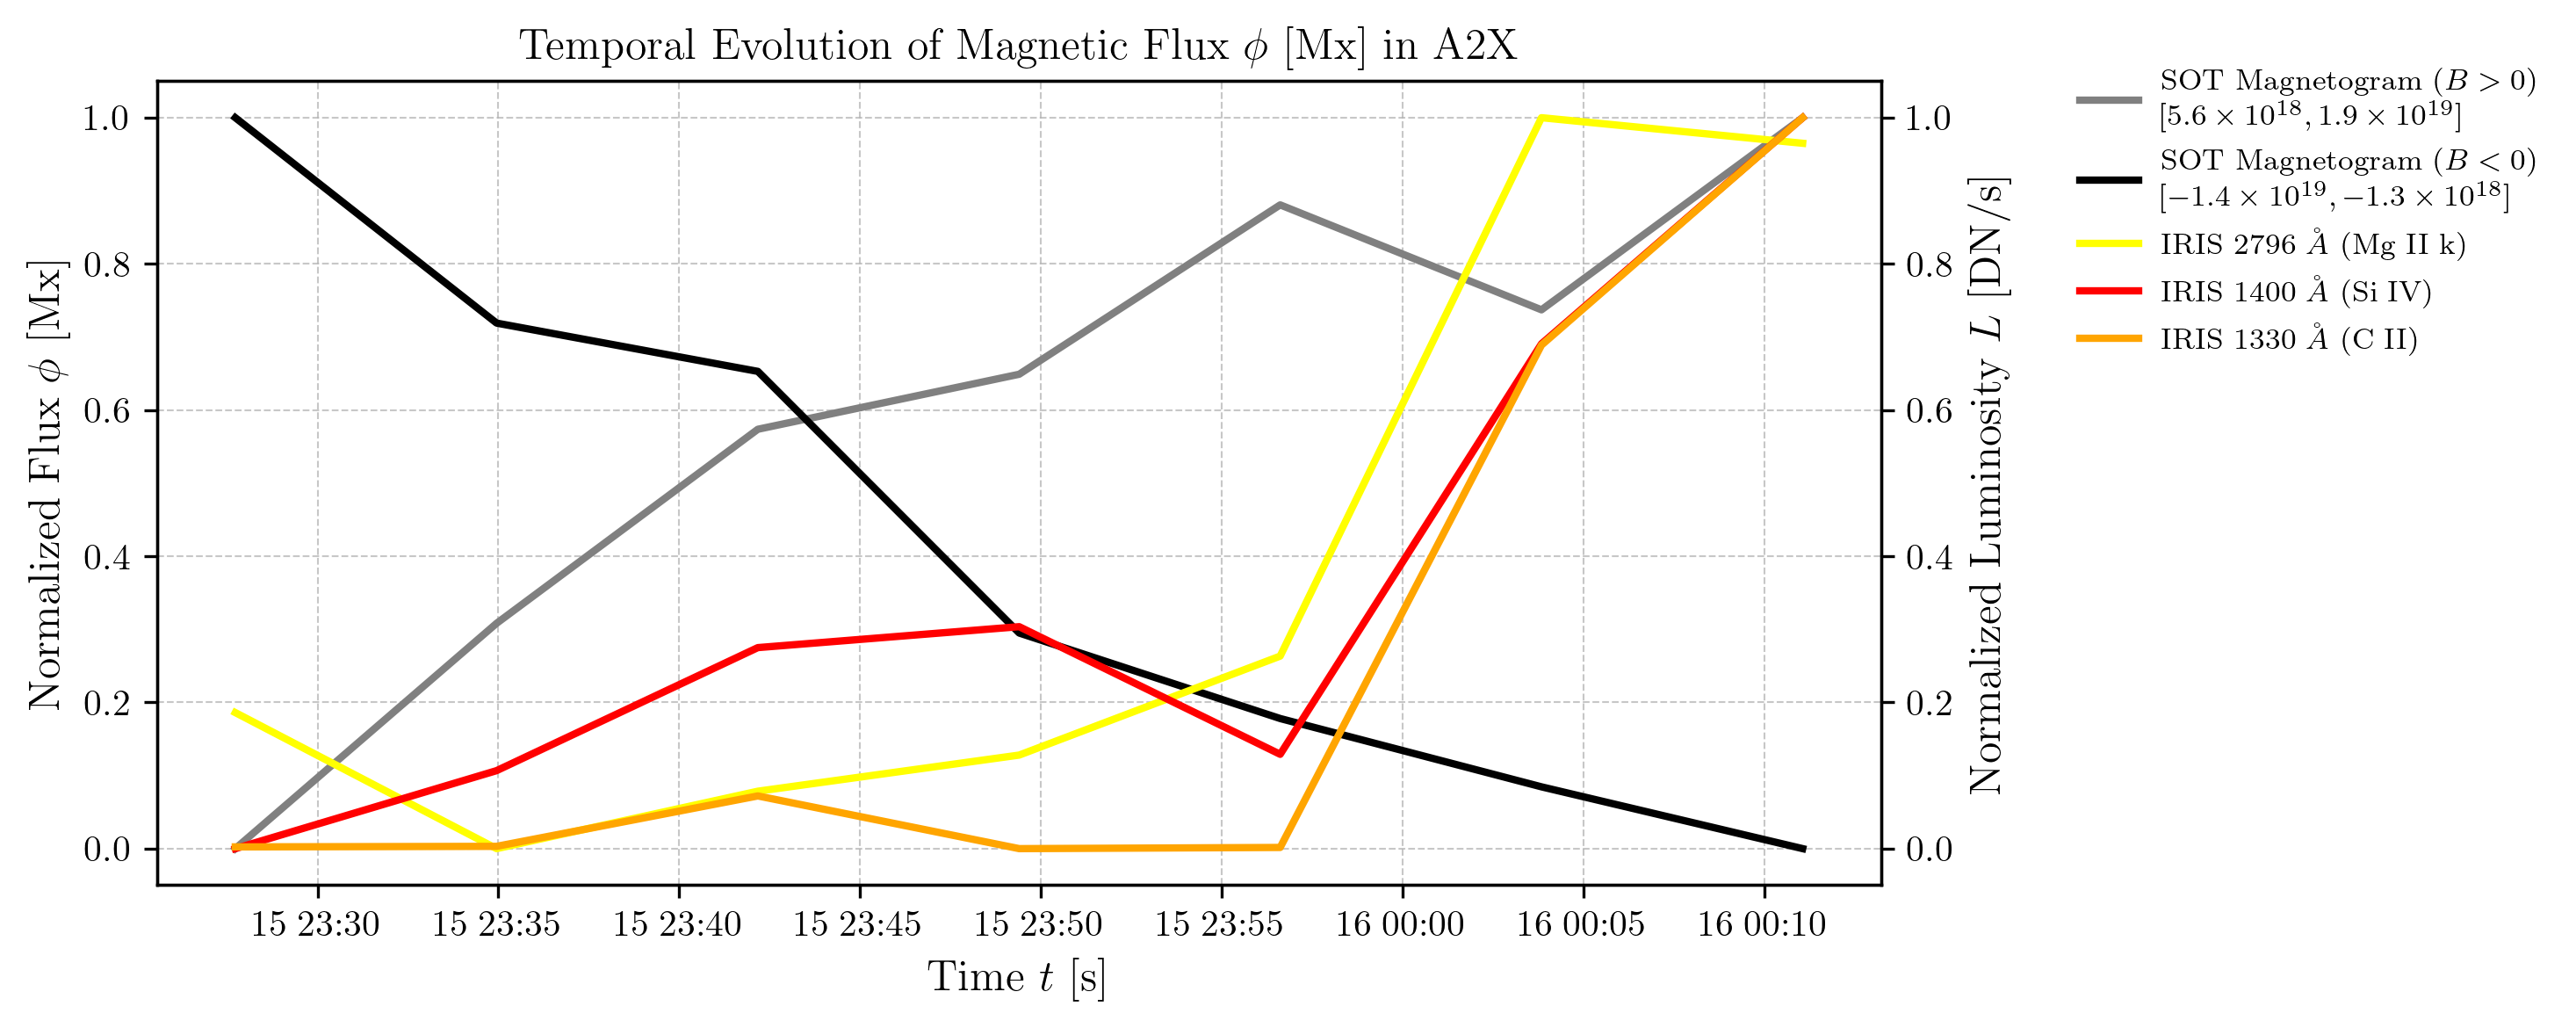

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

{'frames': range(35, 41), 'bl': (279, 91), 'tr': (296, 115), 'dims': (20, 30), 'pol': -1}
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliogr

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


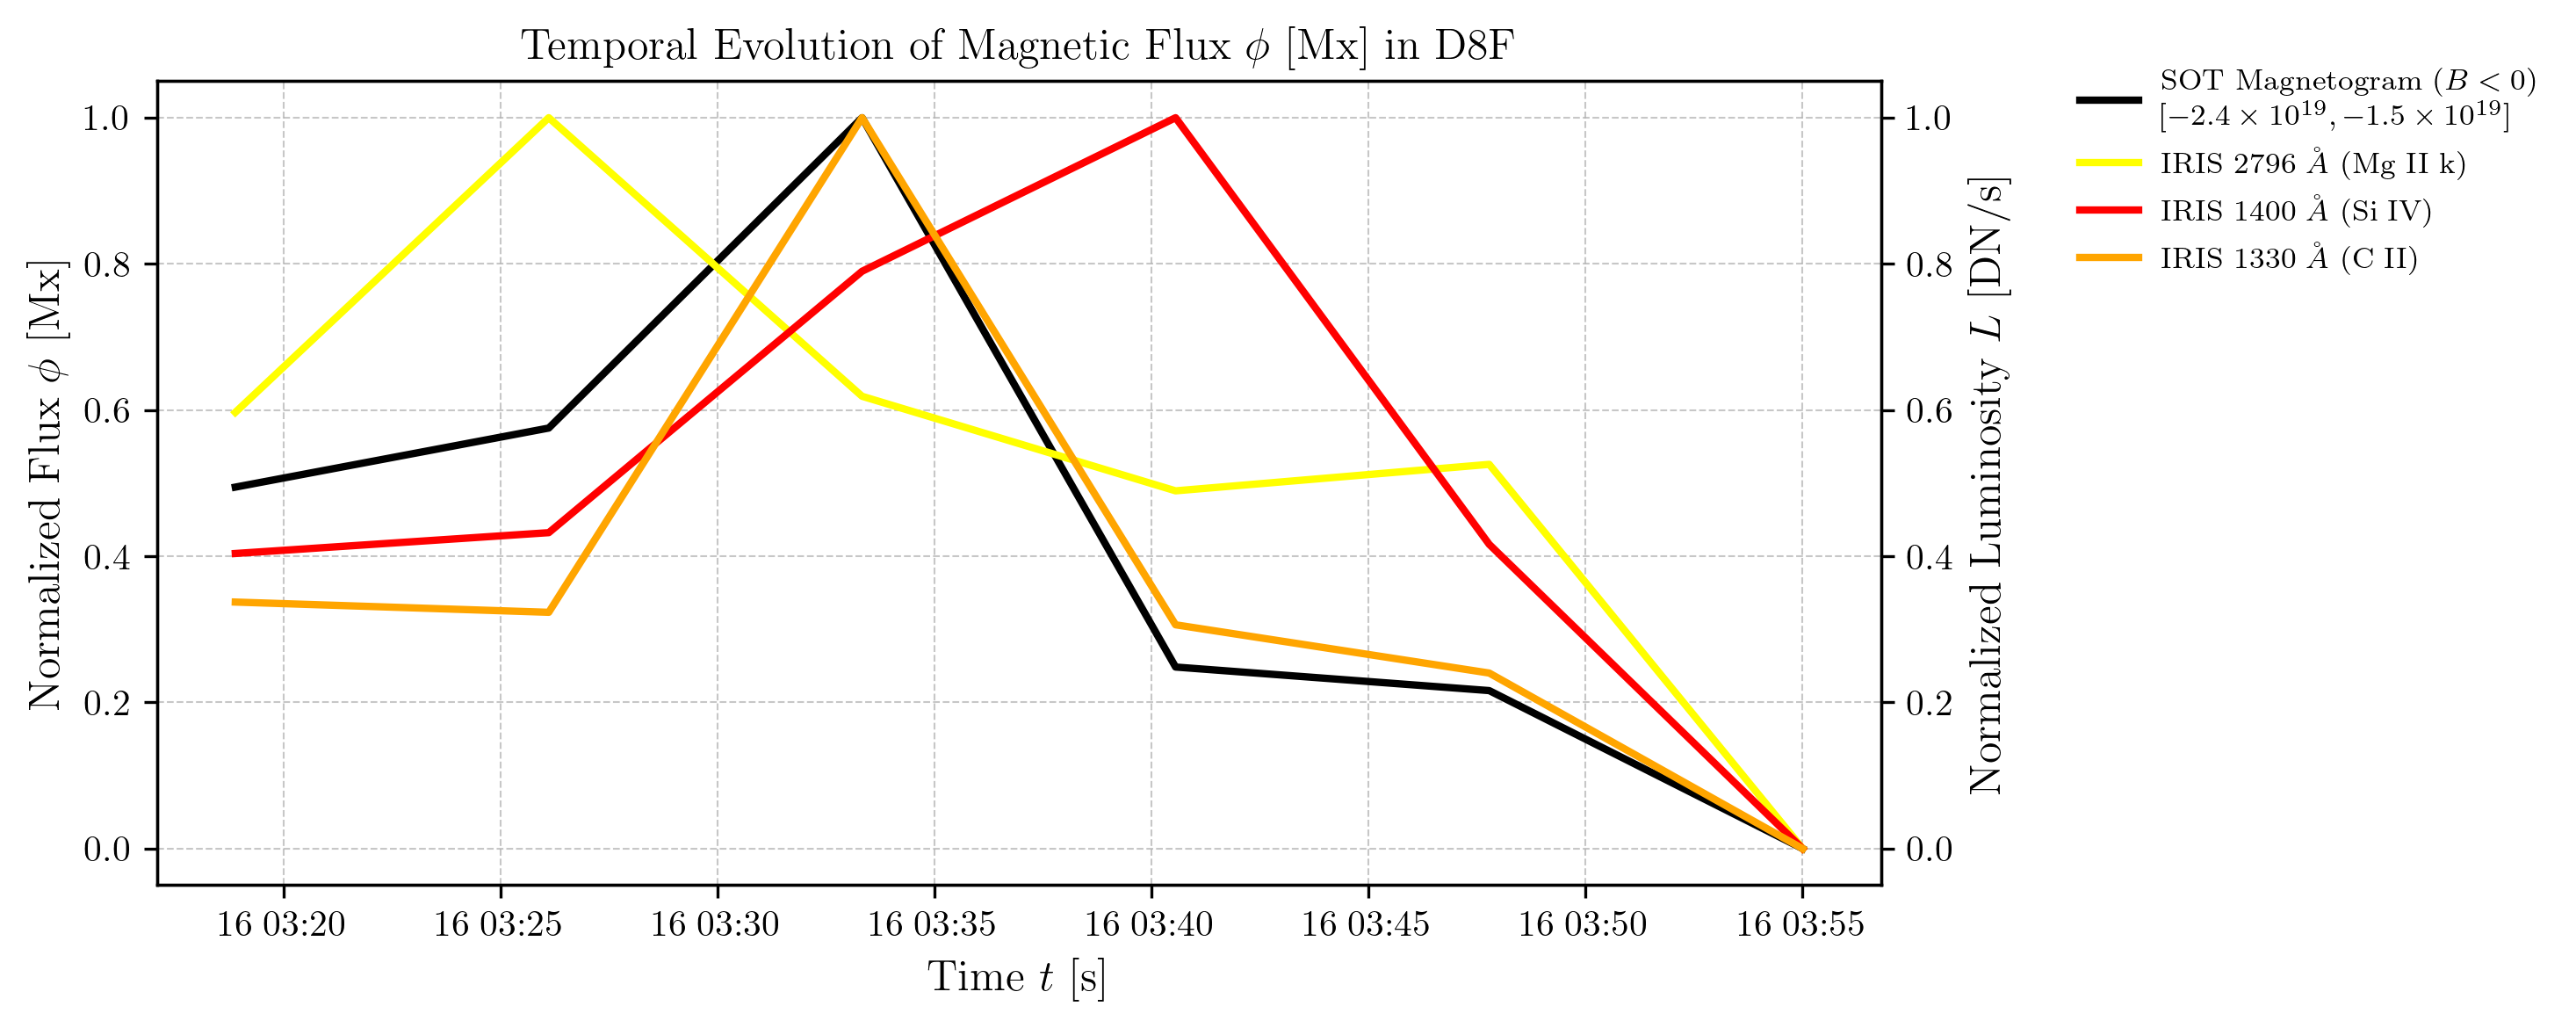

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs



{'frames': range(0, 5), 'bl': (235, 71), 'tr': (245, 79), 'dims': (15, 20), 'pol': -1}
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


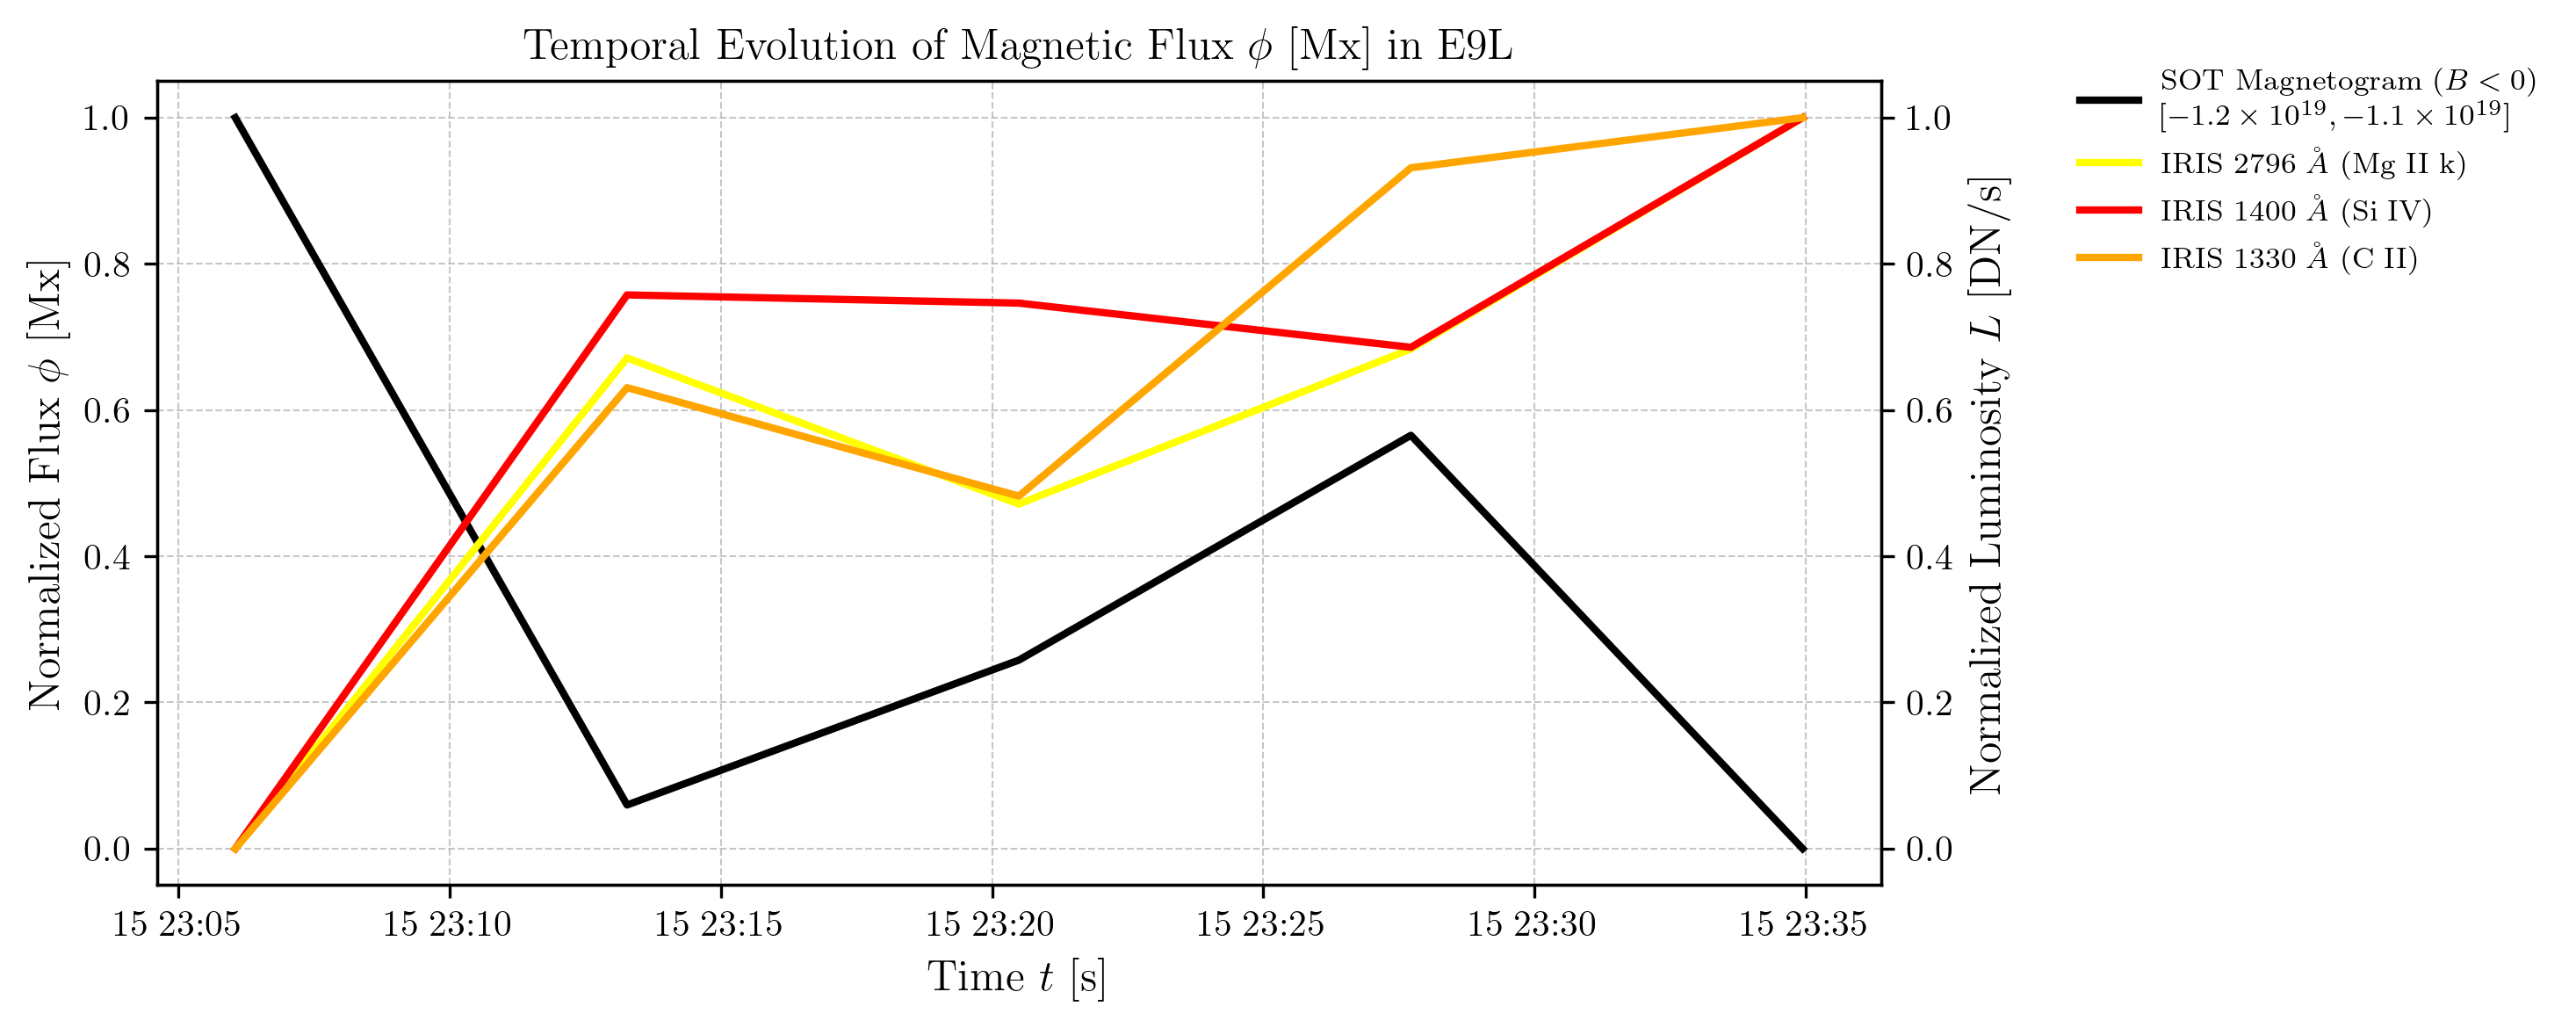

{'frames': range(2, 13), 'bl': (251, 38), 'tr': (275, 62), 'dims': (25, 25), 'pol': -1}


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


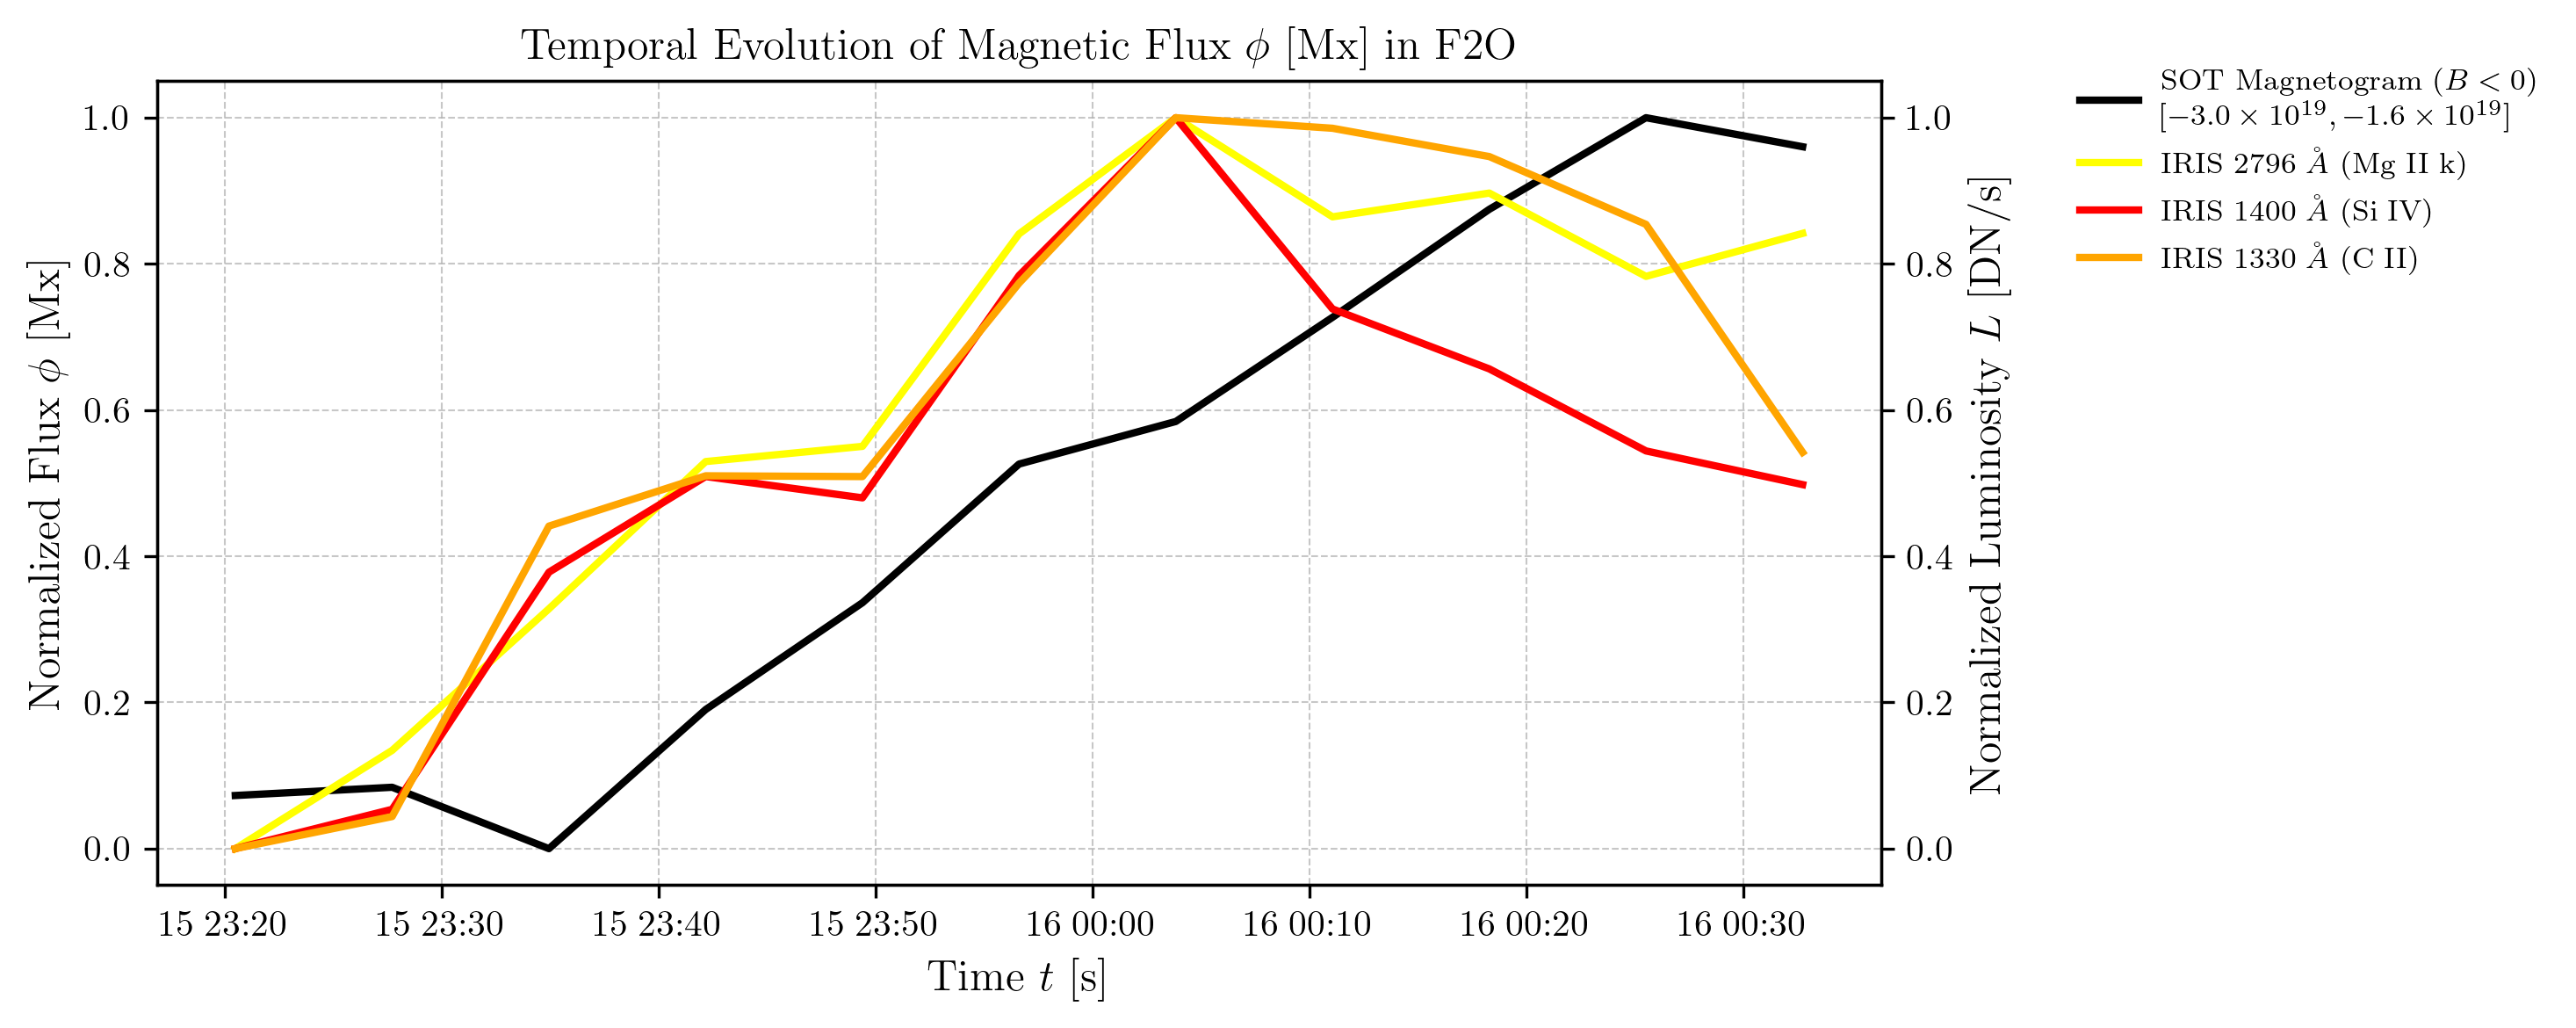

{'frames': range(4, 20), 'bl': (230, 96), 'tr': (260, 119), 'dims': (40, 20), 'pol': 0}


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


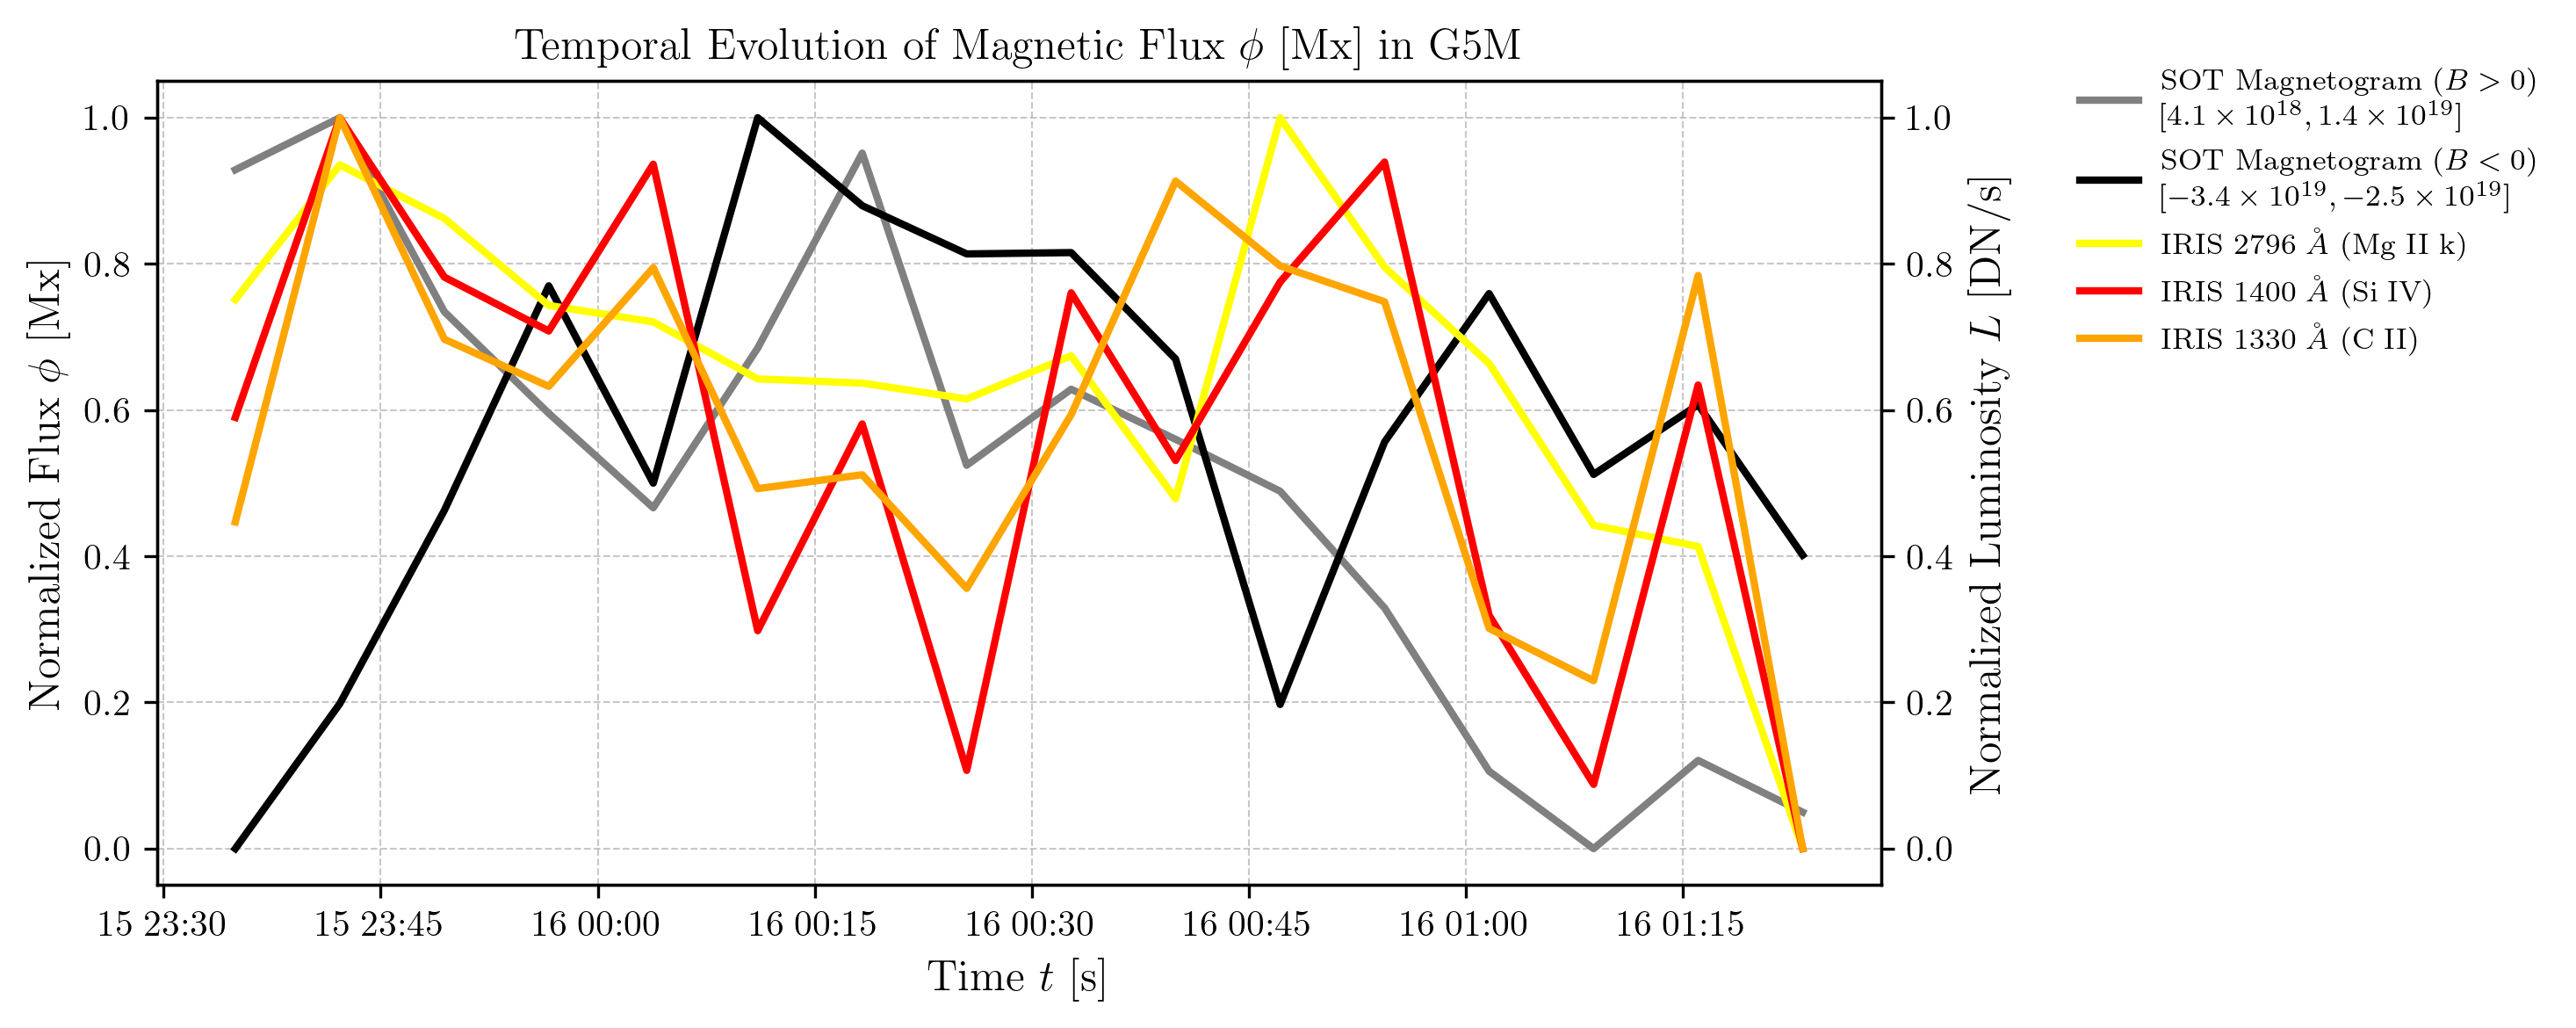

{'frames': range(15, 32), 'bl': (222, 45), 'tr': (257, 75), 'dims': (25, 25), 'pol': -1}


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliogr

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


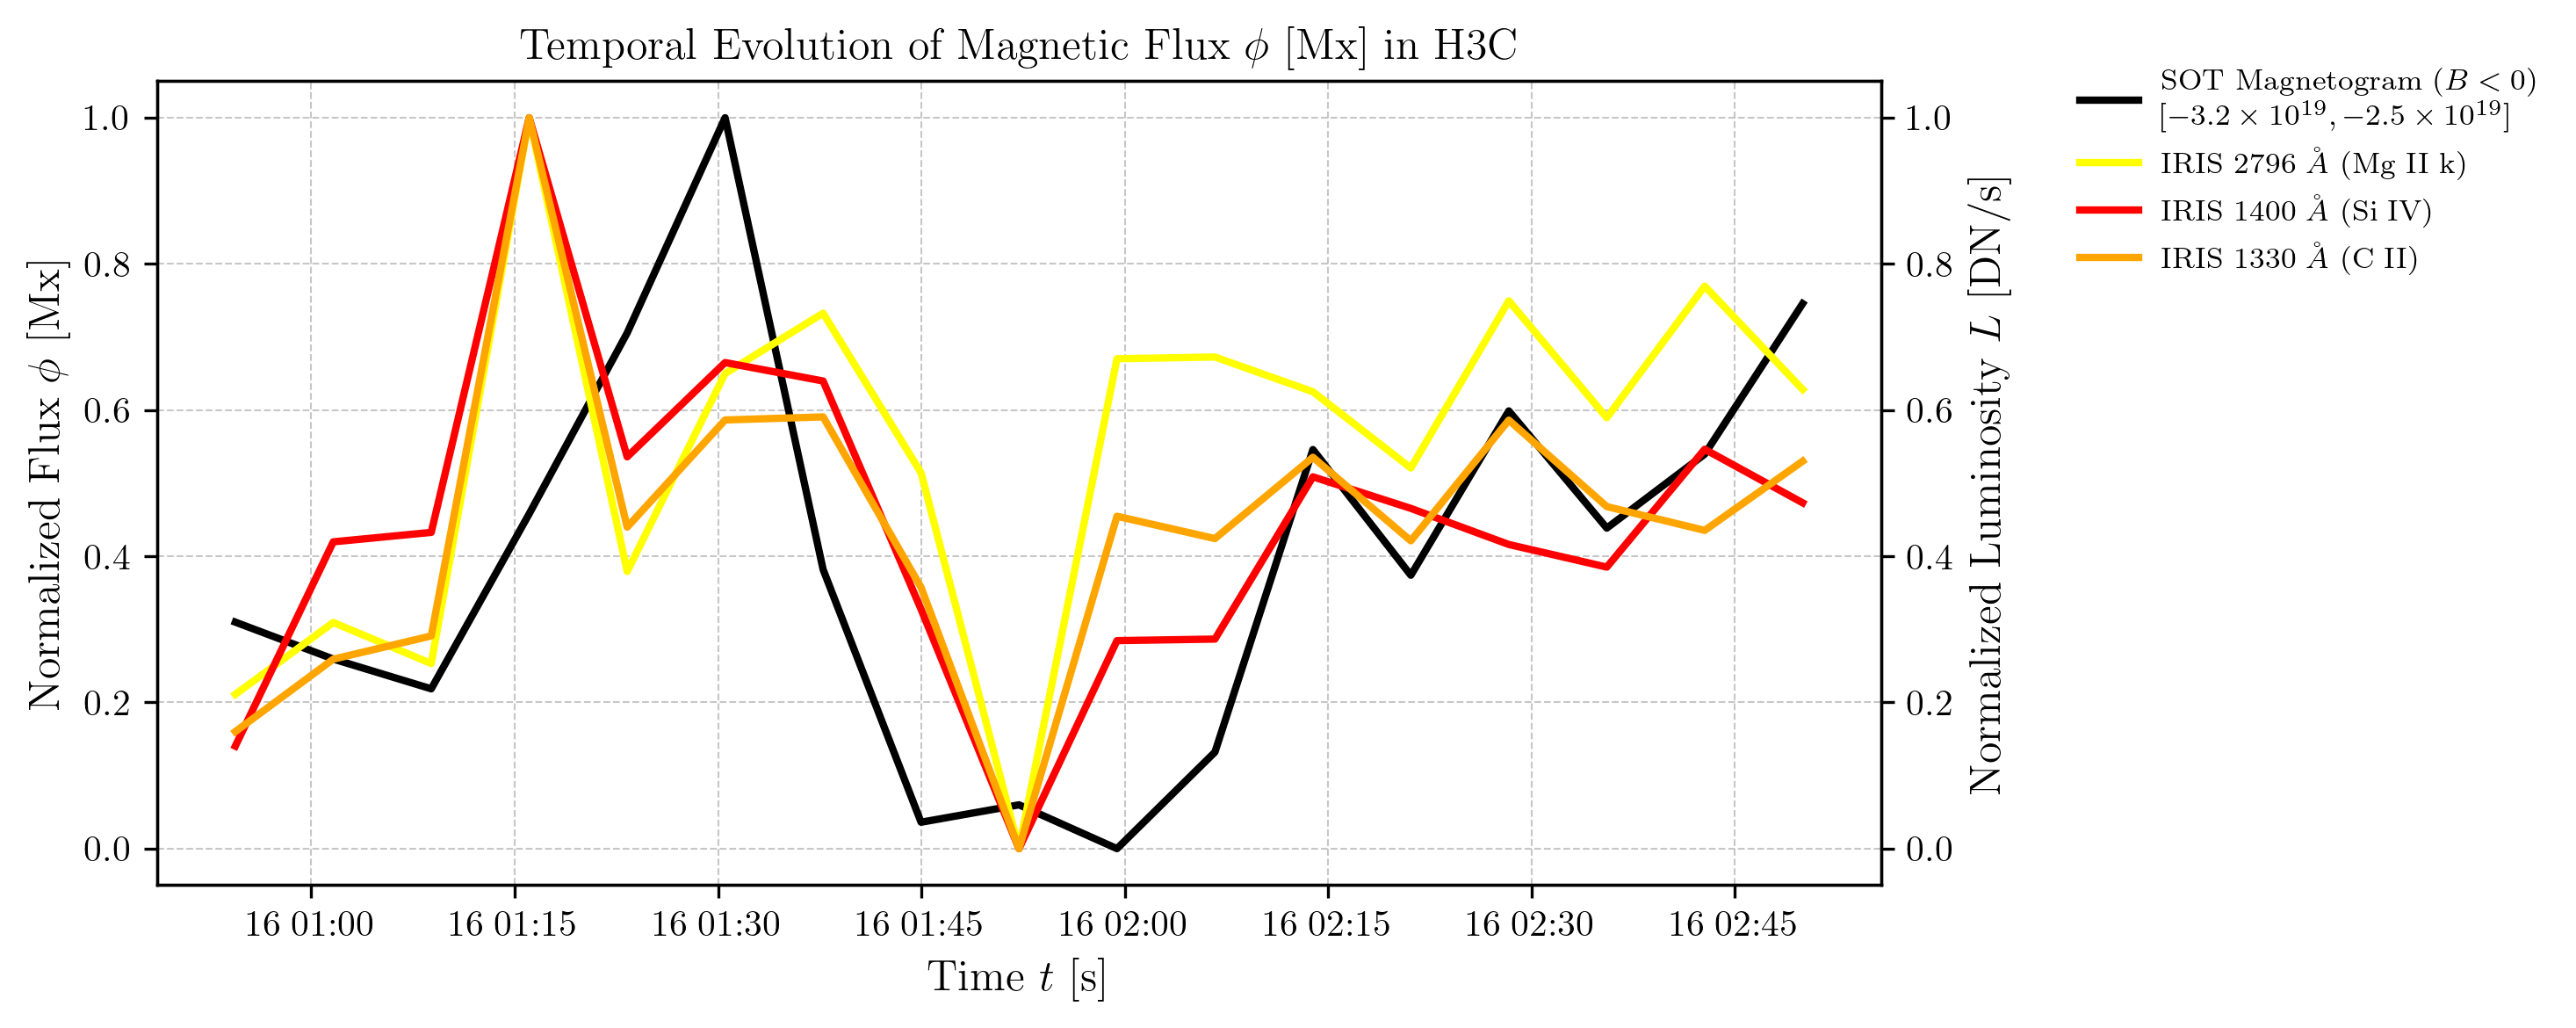

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

{'frames': range(34, 39), 'bl': (250, 62), 'tr': (267, 90), 'dims': (25, 25), 'pol': 0}
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


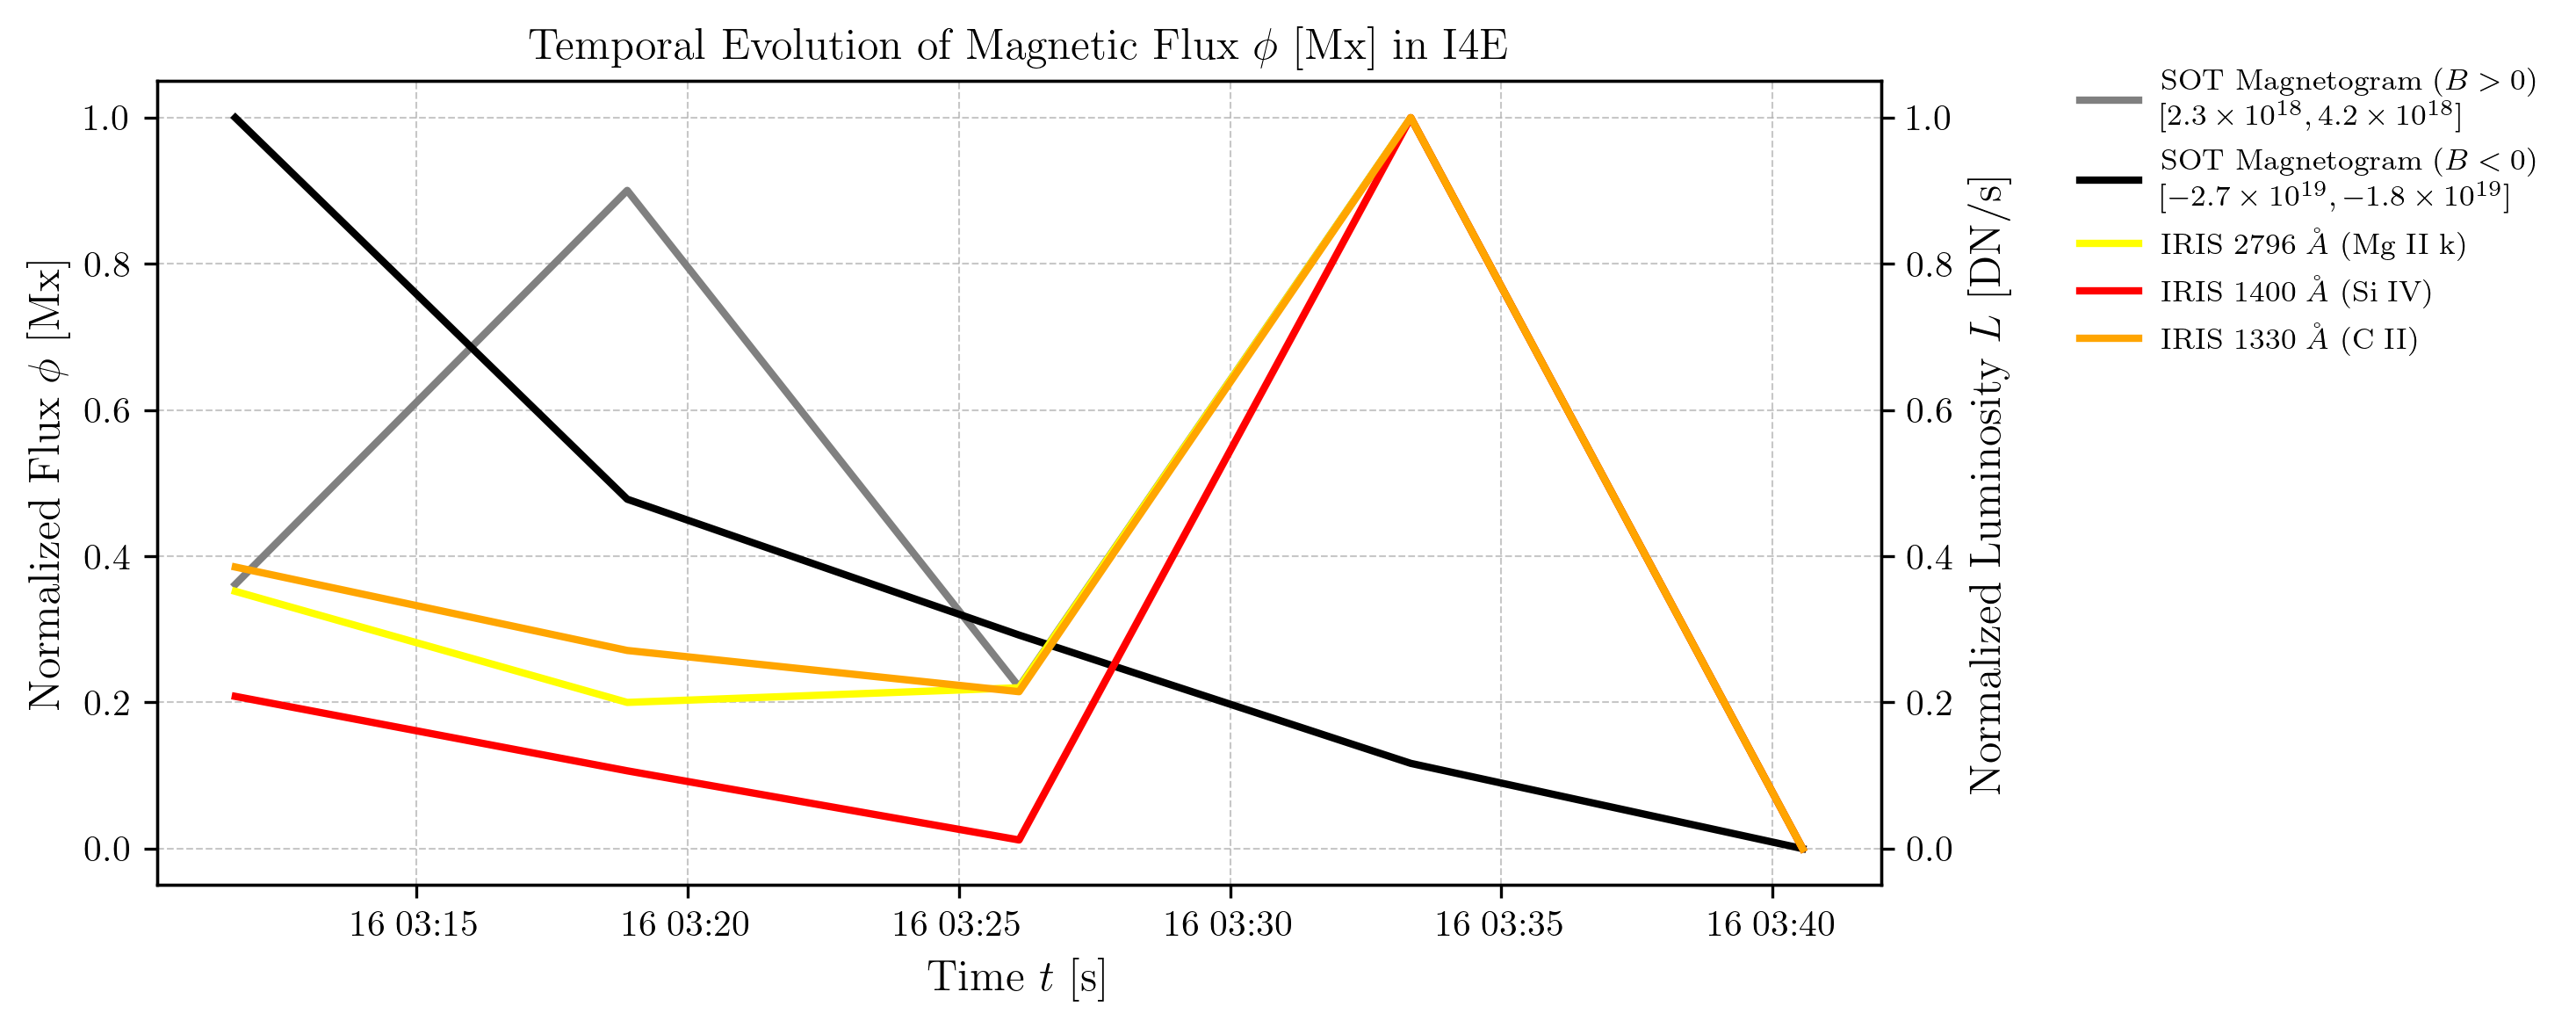

{'frames': range(10, 14), 'bl': (137, 95), 'tr': (157, 110), 'dims': (15, 15), 'pol': 0}


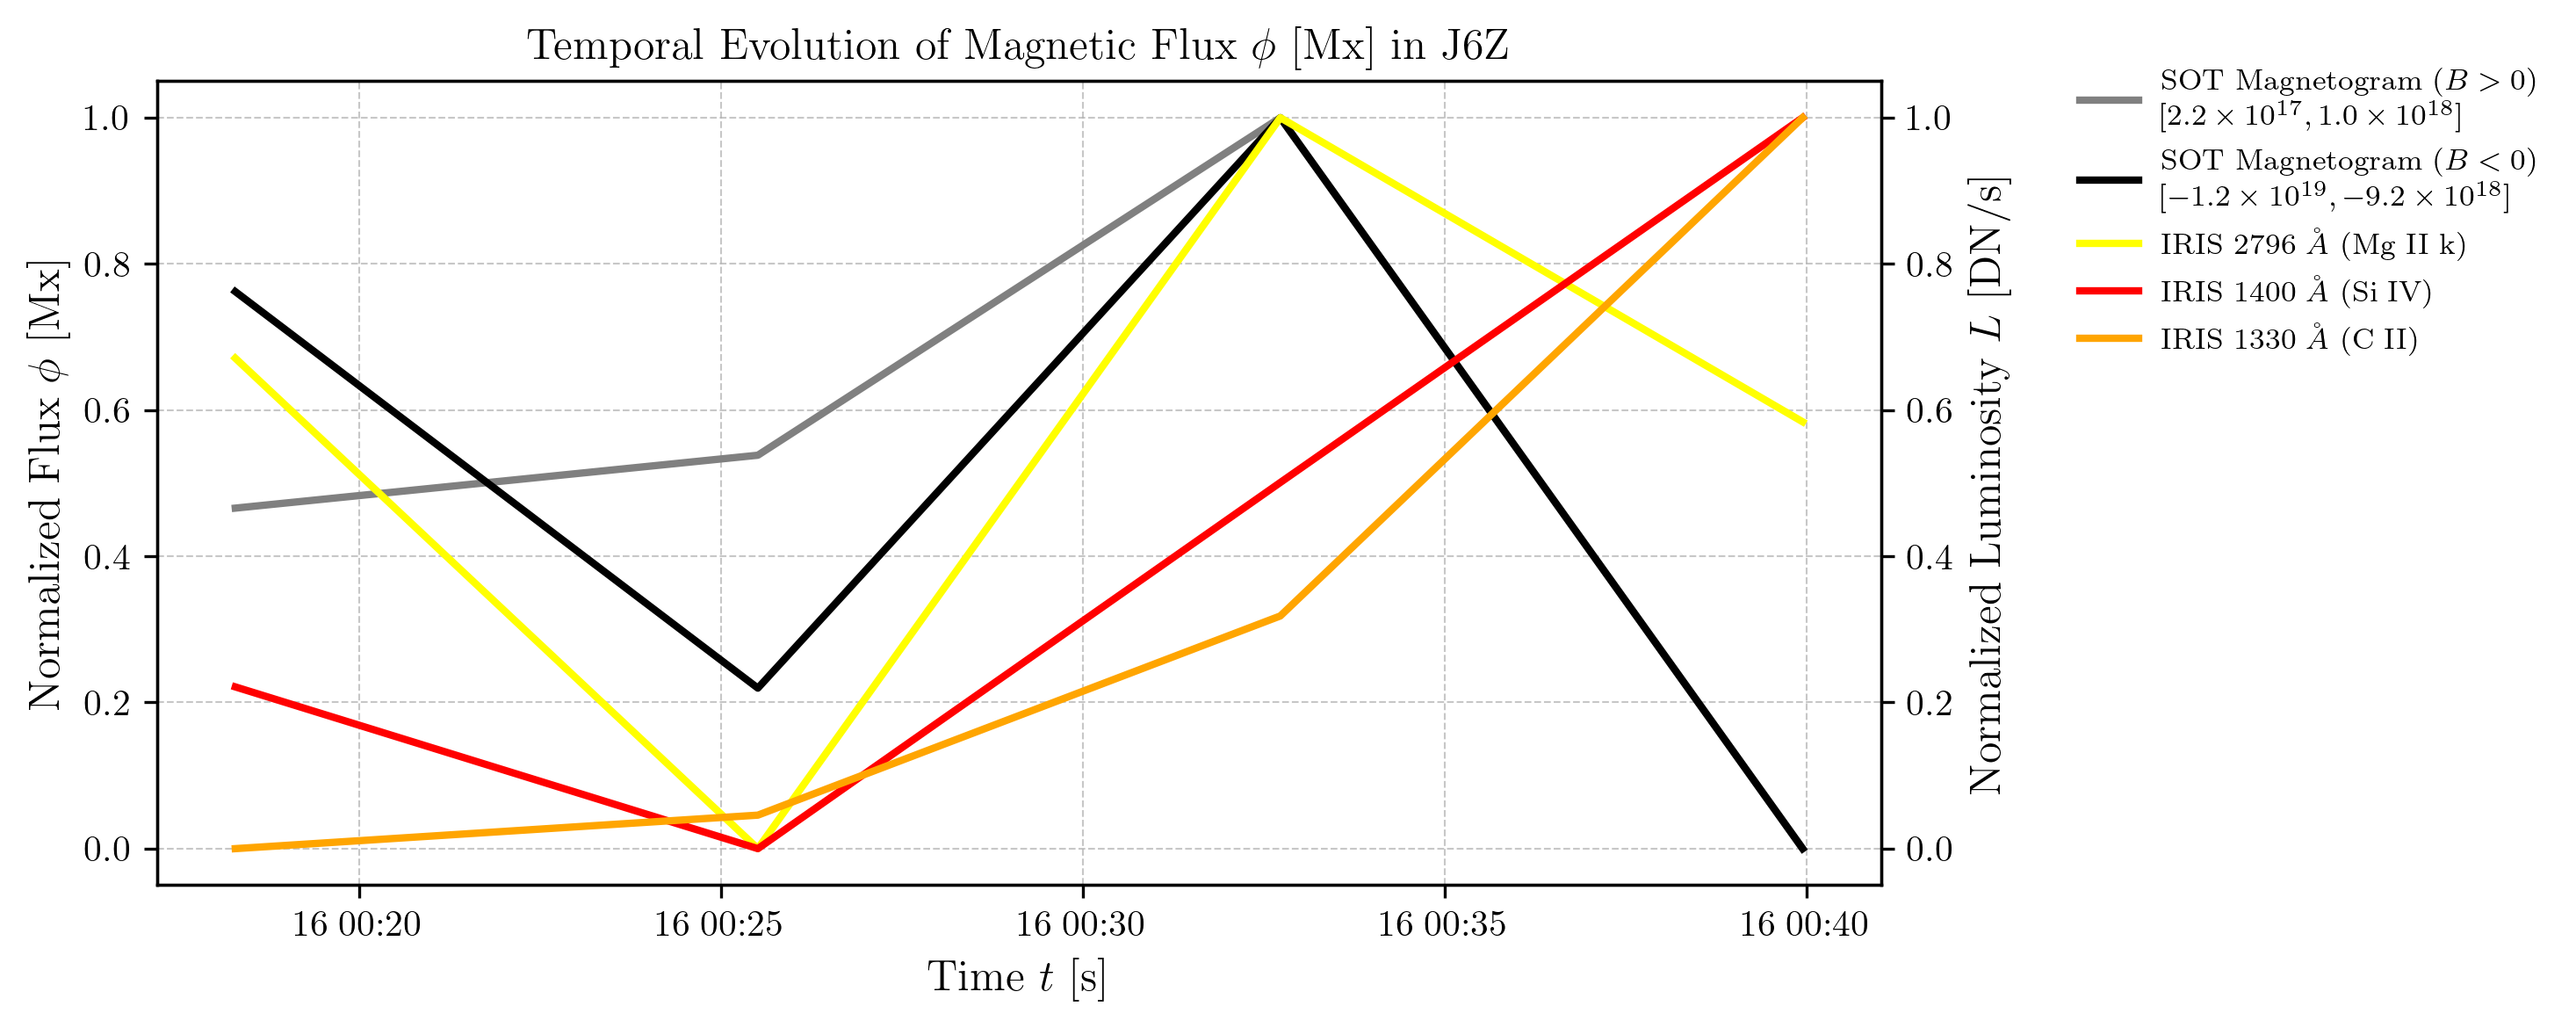

{'frames': range(11, 25), 'bl': (45, 60), 'tr': (60, 75), 'dims': (40, 40), 'pol': 1}


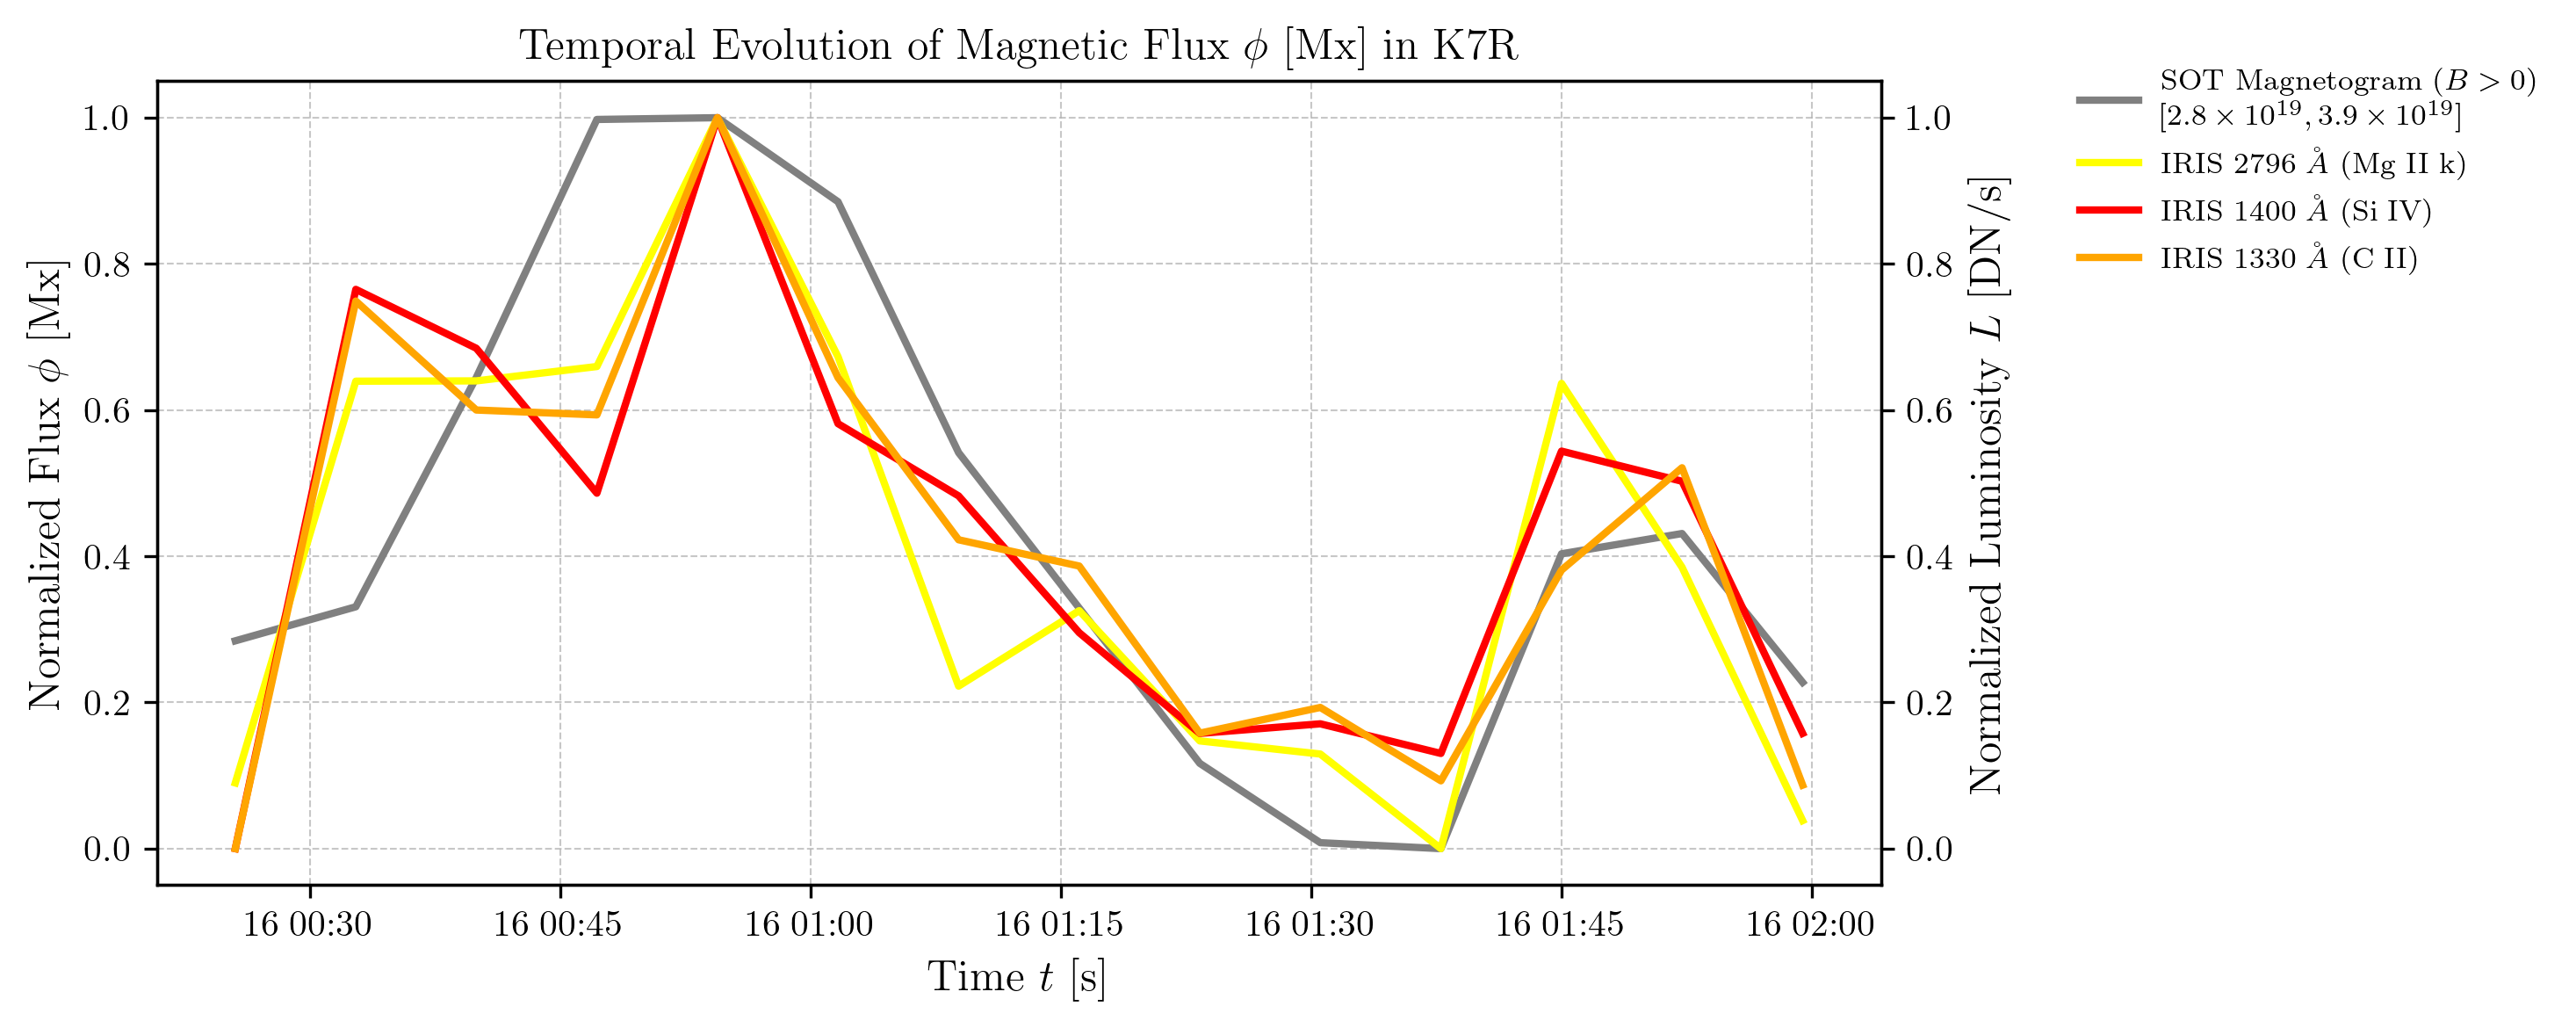

{'frames': range(18, 21), 'bl': (25, 15), 'tr': (52, 45), 'dims': (20, 25), 'pol': 0}


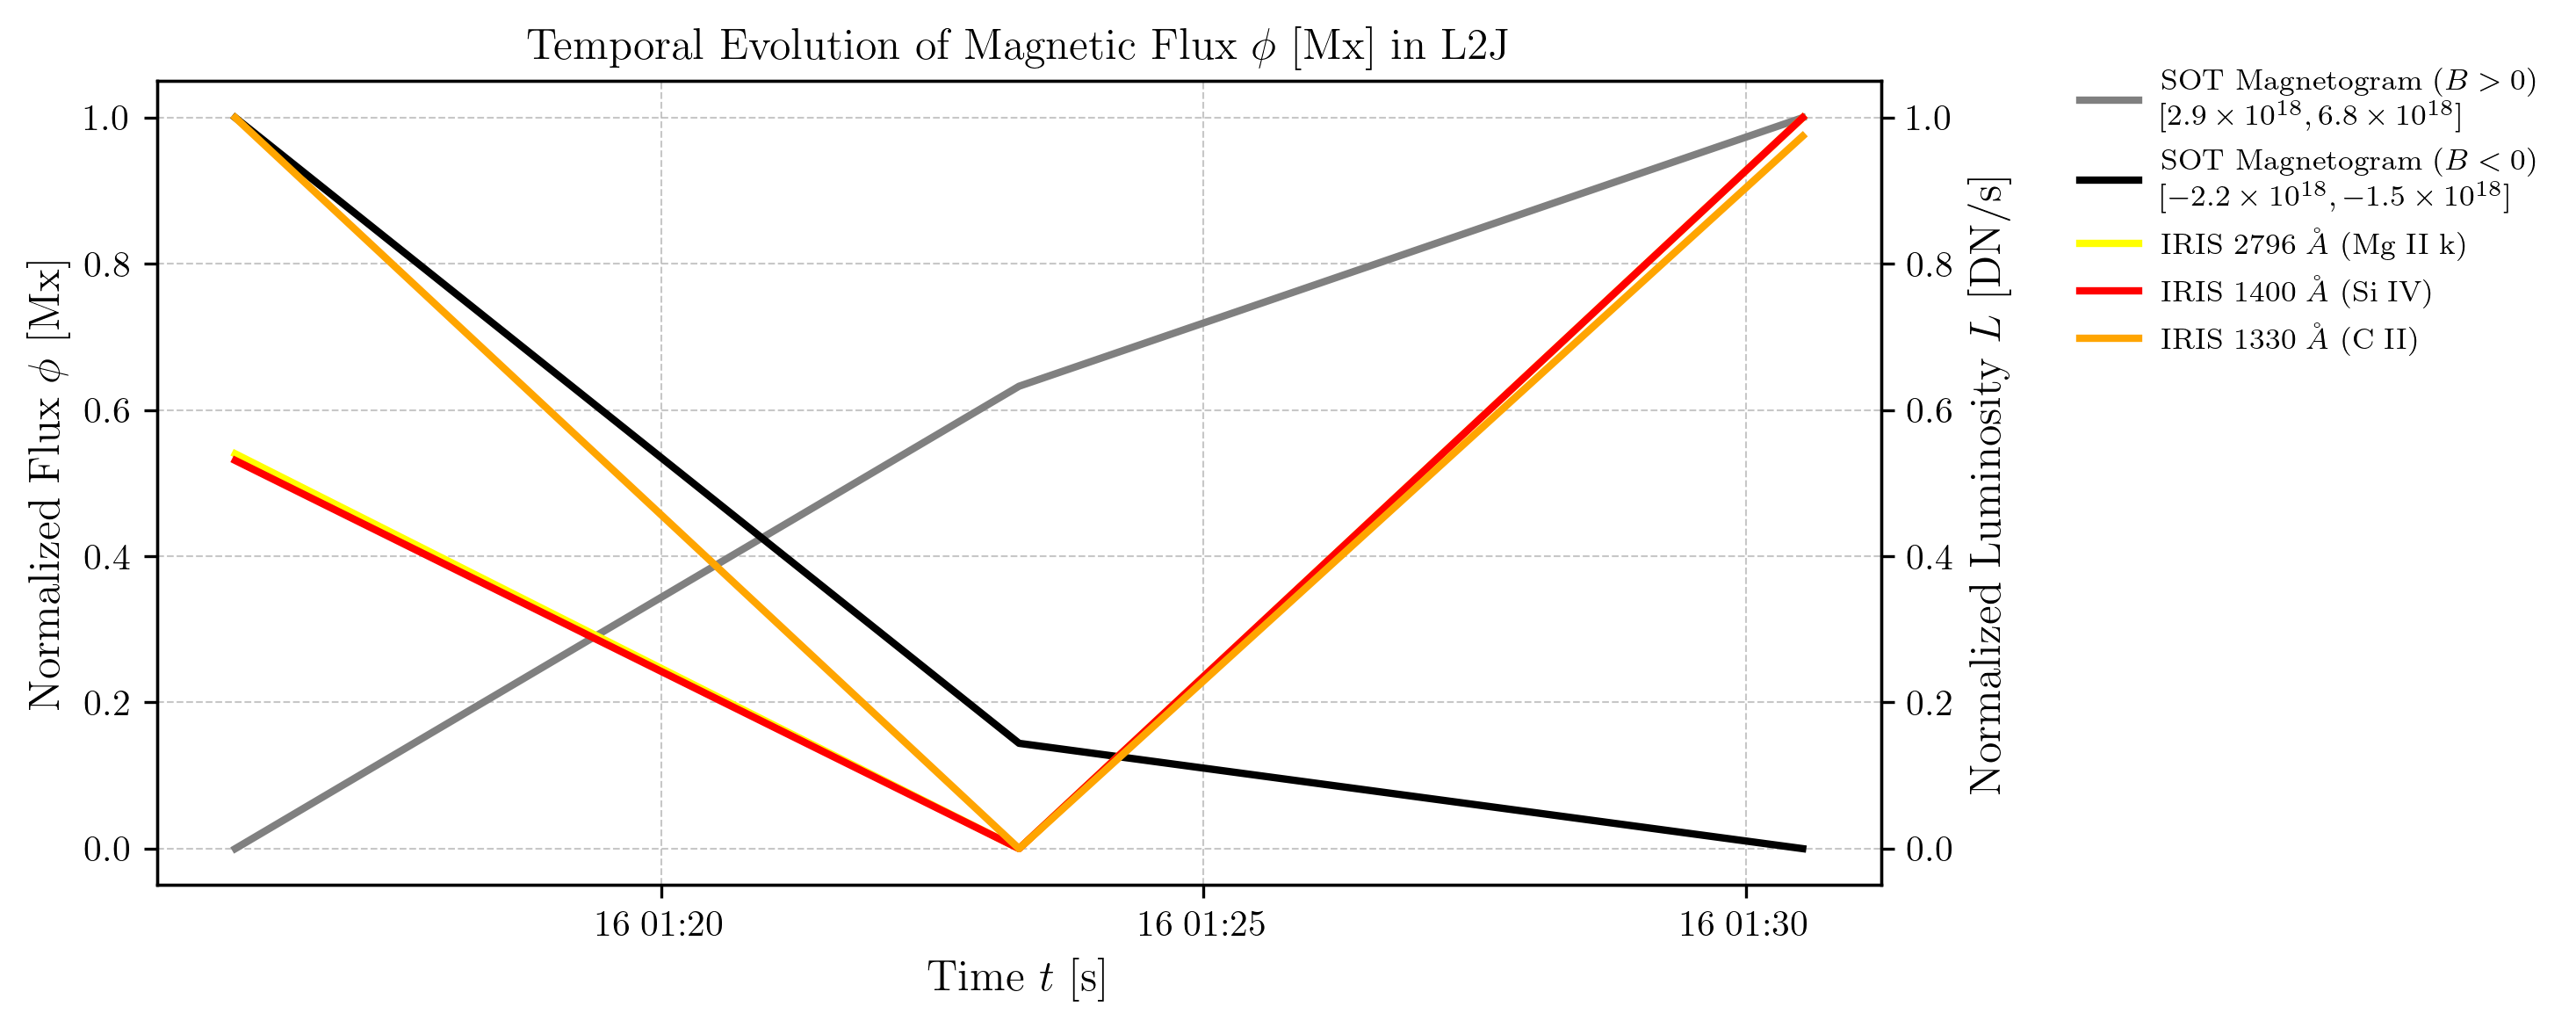

{'frames': range(13, 18), 'bl': (326, 73), 'tr': (347, 110), 'dims': (25, 50), 'pol': 1}


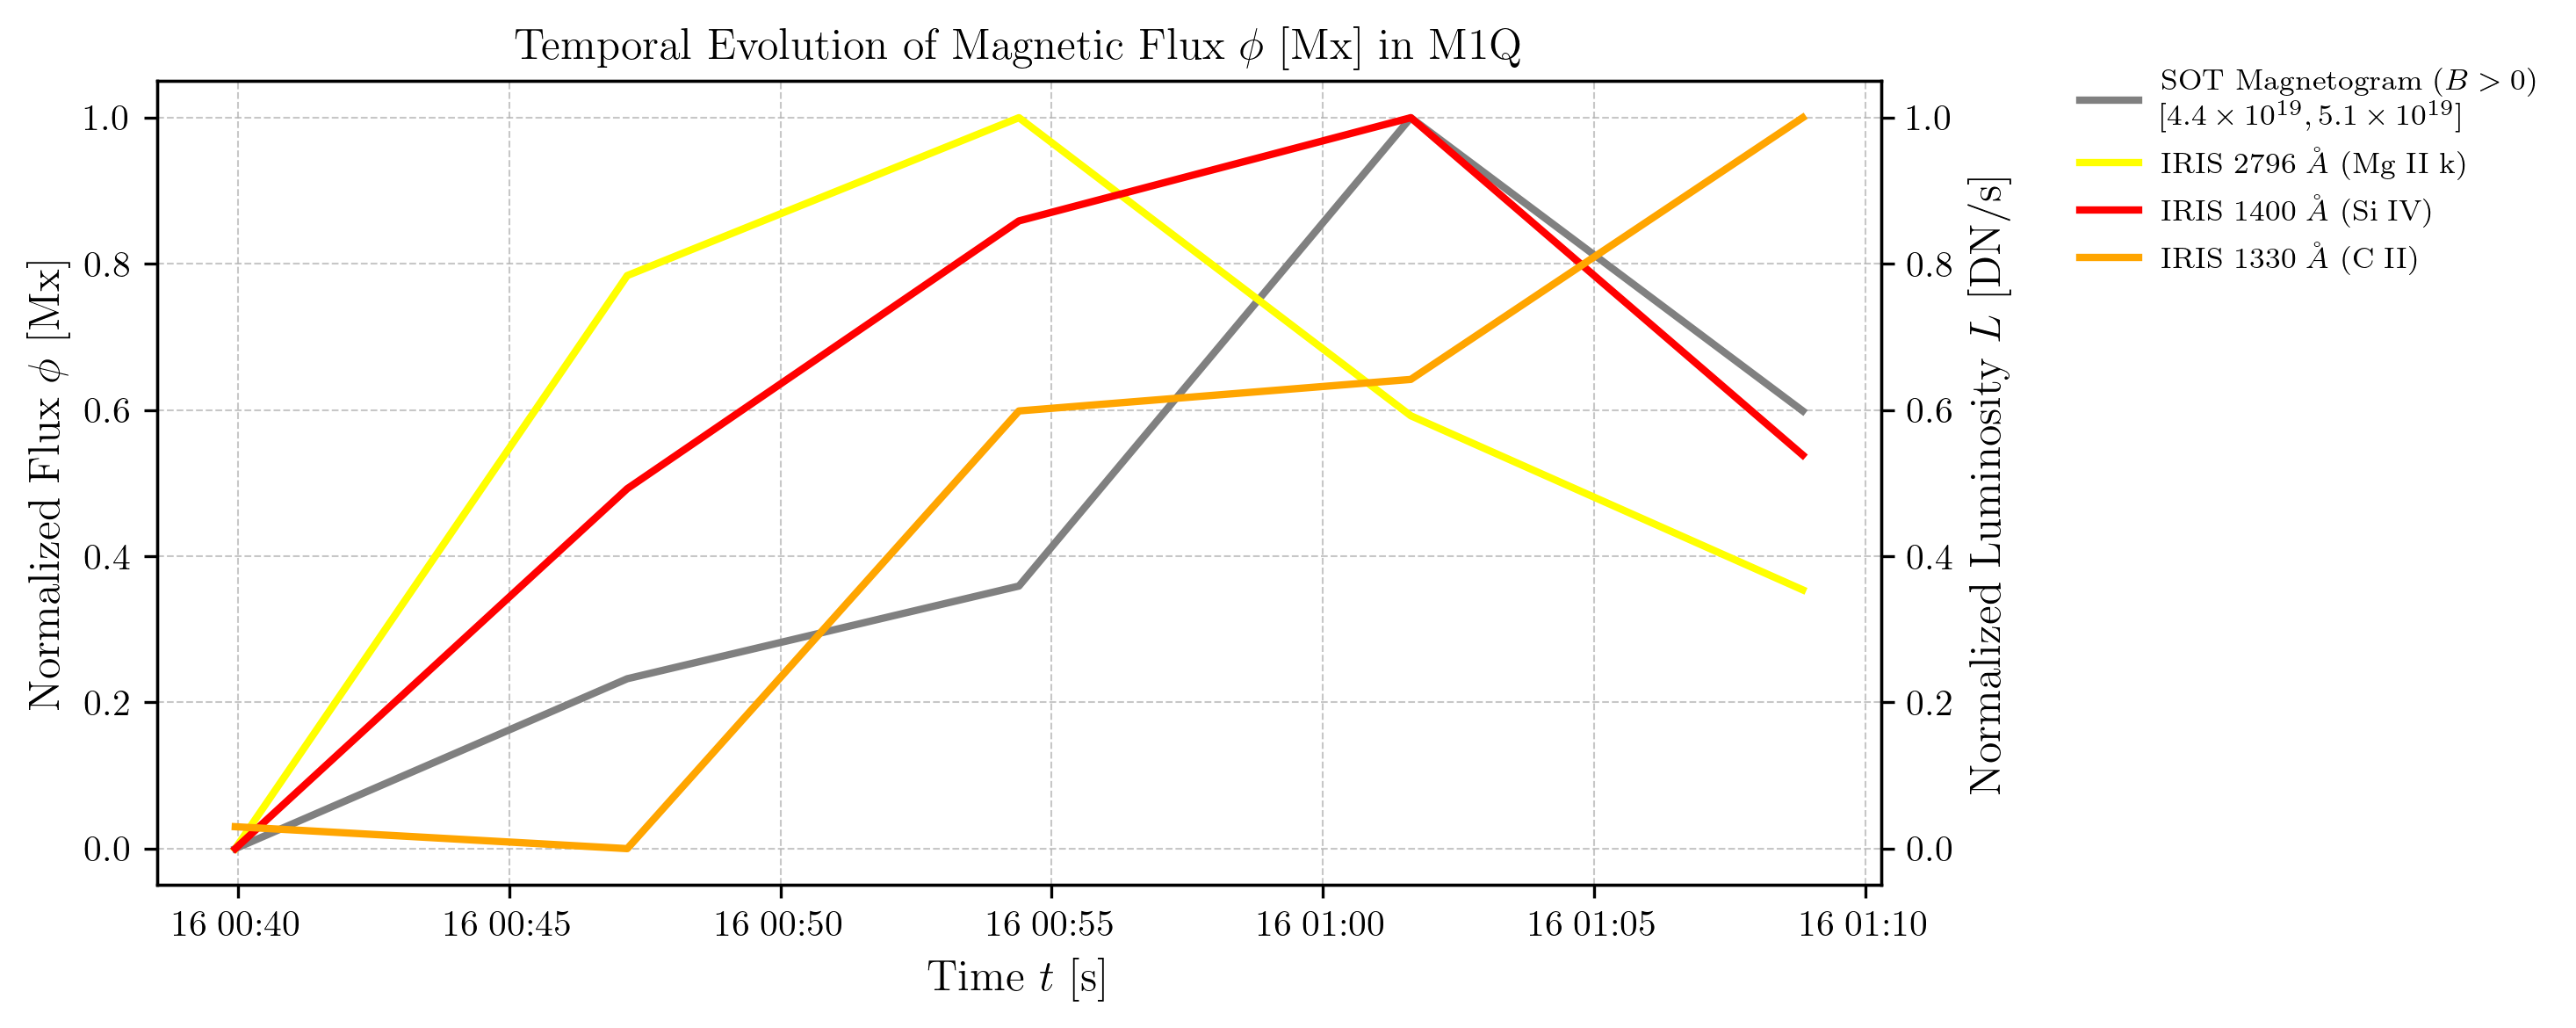

{'frames': range(31, 37), 'bl': (270, 51), 'tr': (299, 71), 'dims': (25, 25), 'pol': 0}


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

INFO:sunpy:Missing

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


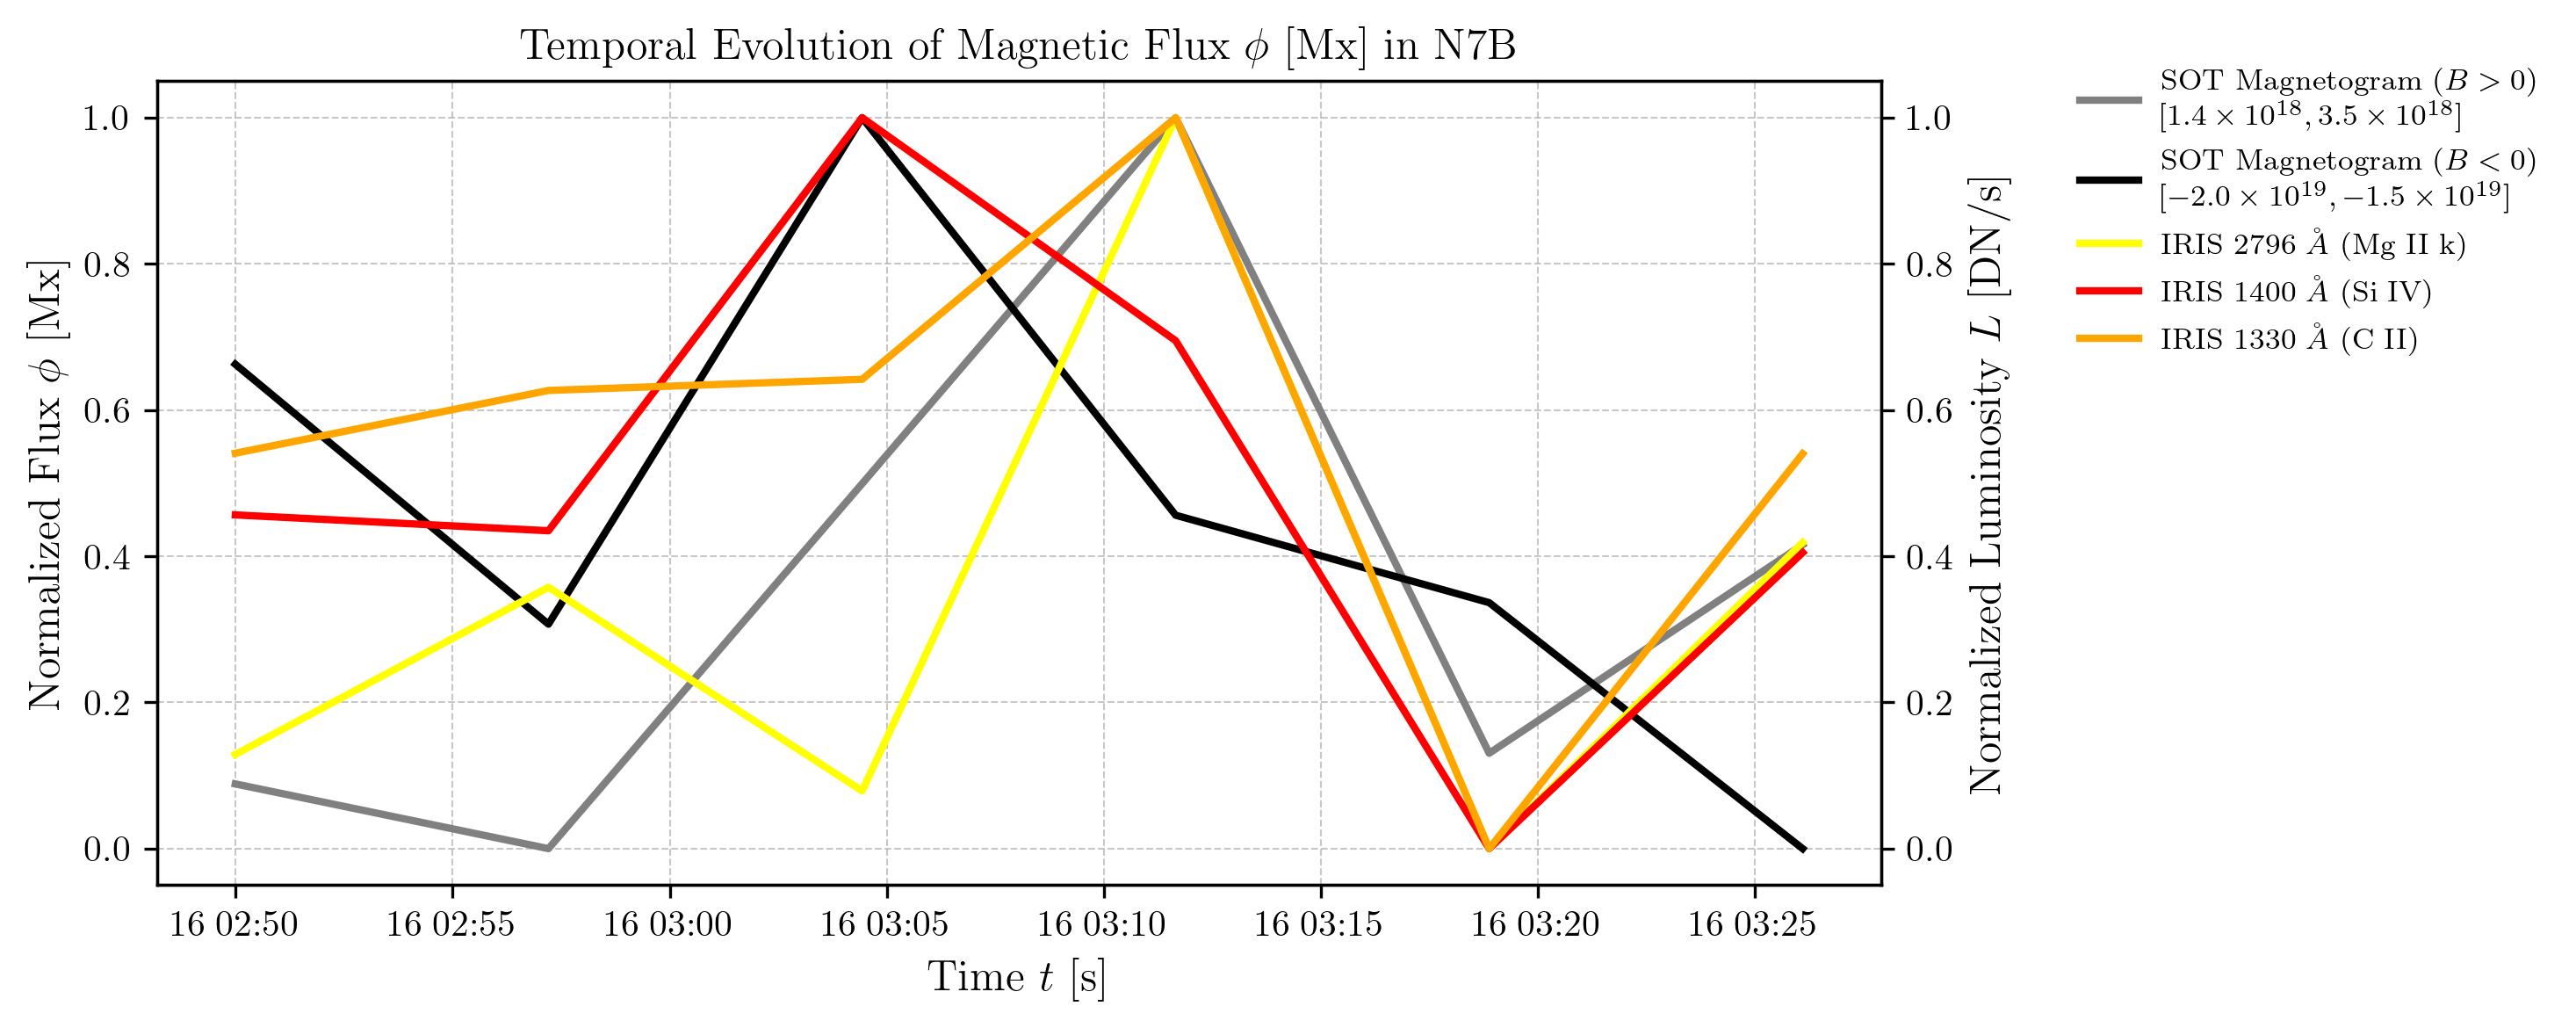

{'frames': range(26, 35), 'bl': (253, 83), 'tr': (270, 115), 'dims': (20, 20), 'pol': 1}


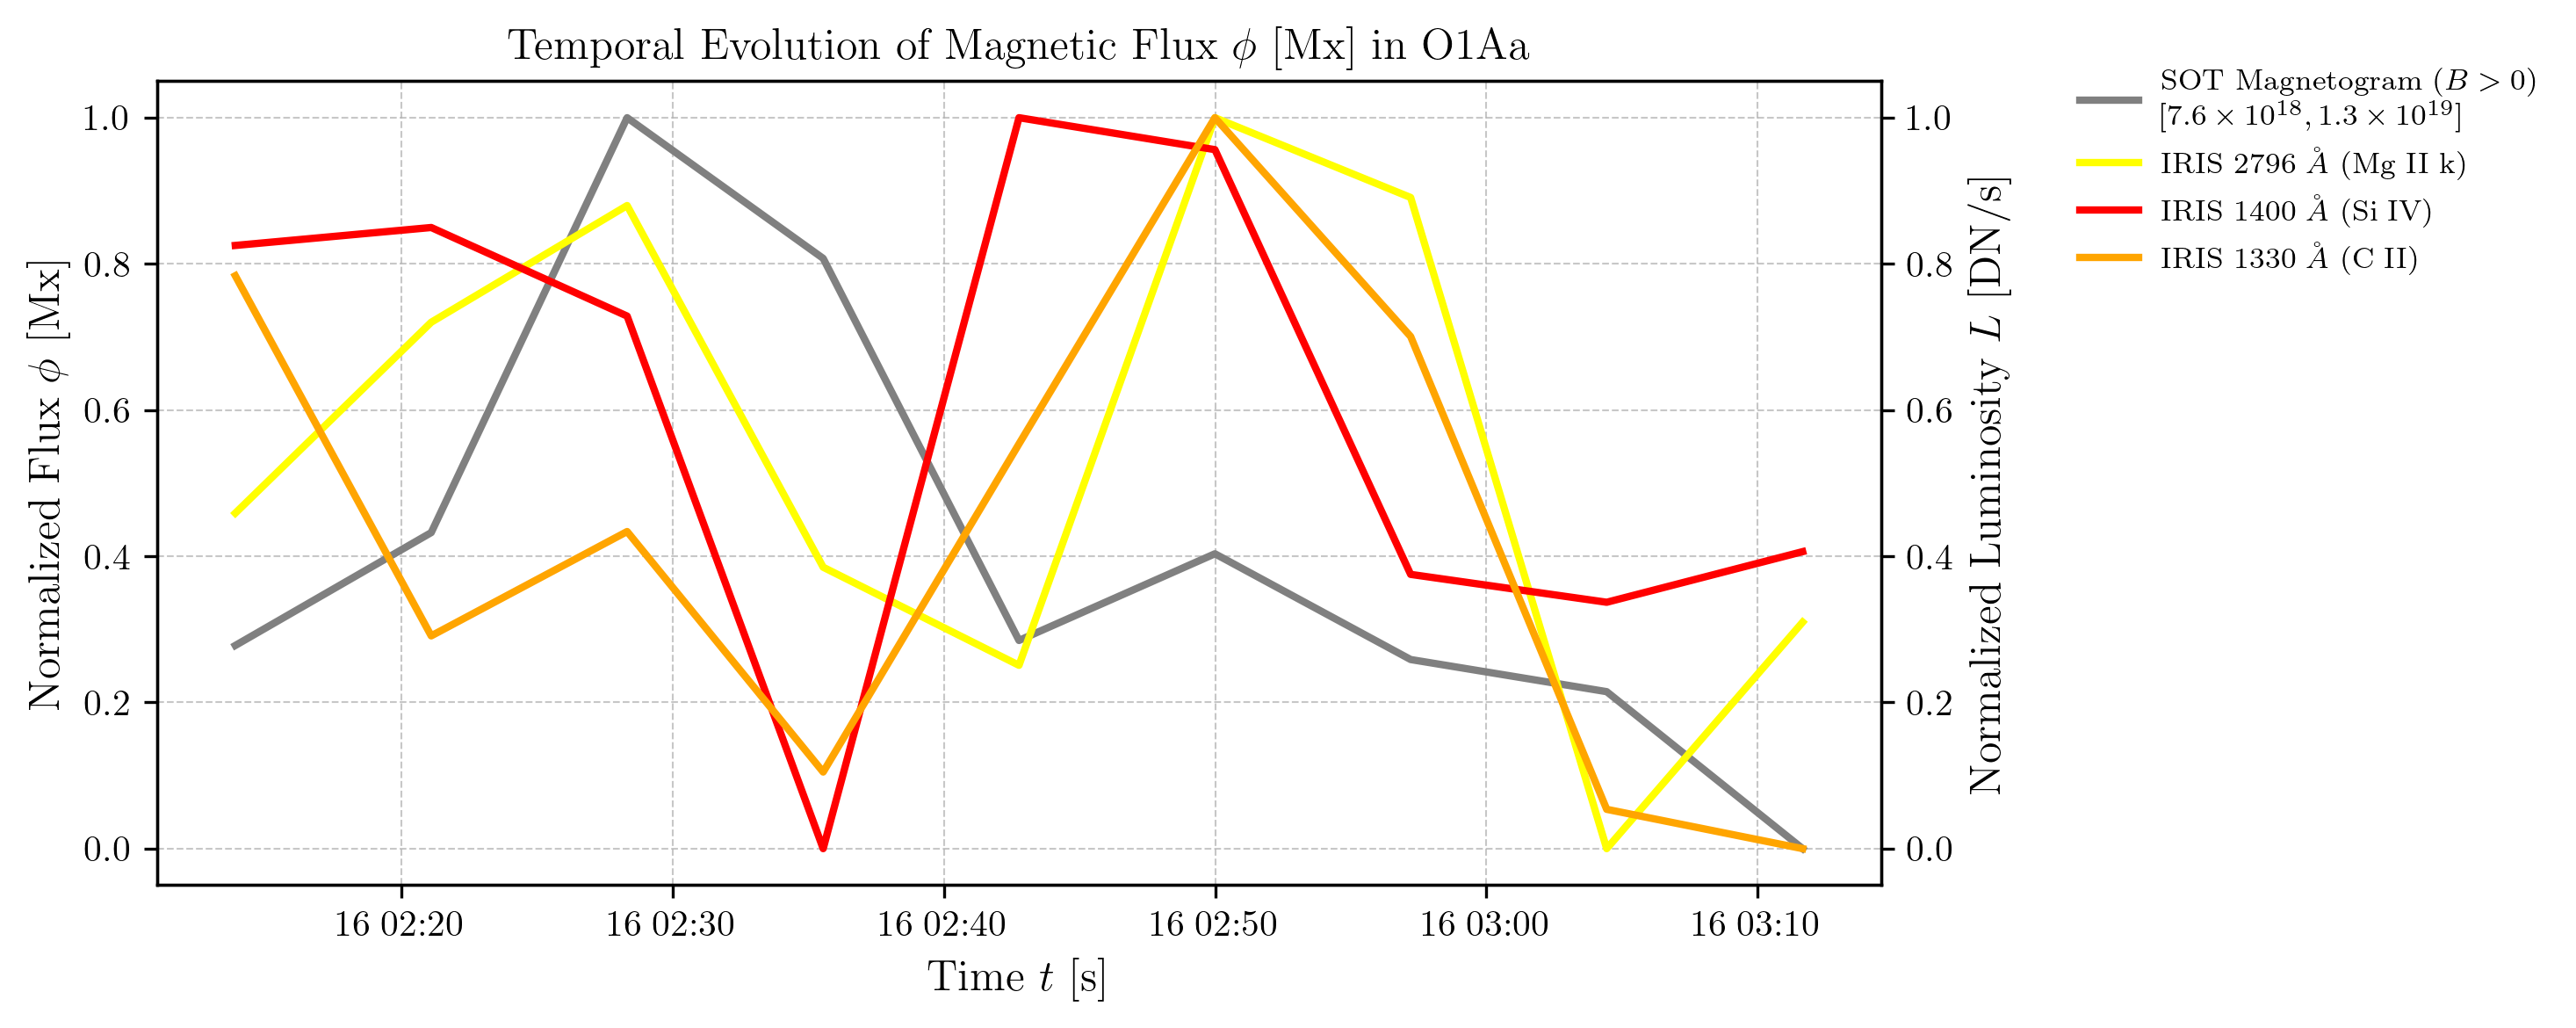

{'frames': range(35, 41), 'bl': (253, 83), 'tr': (270, 115), 'dims': (20, 20), 'pol': 0}


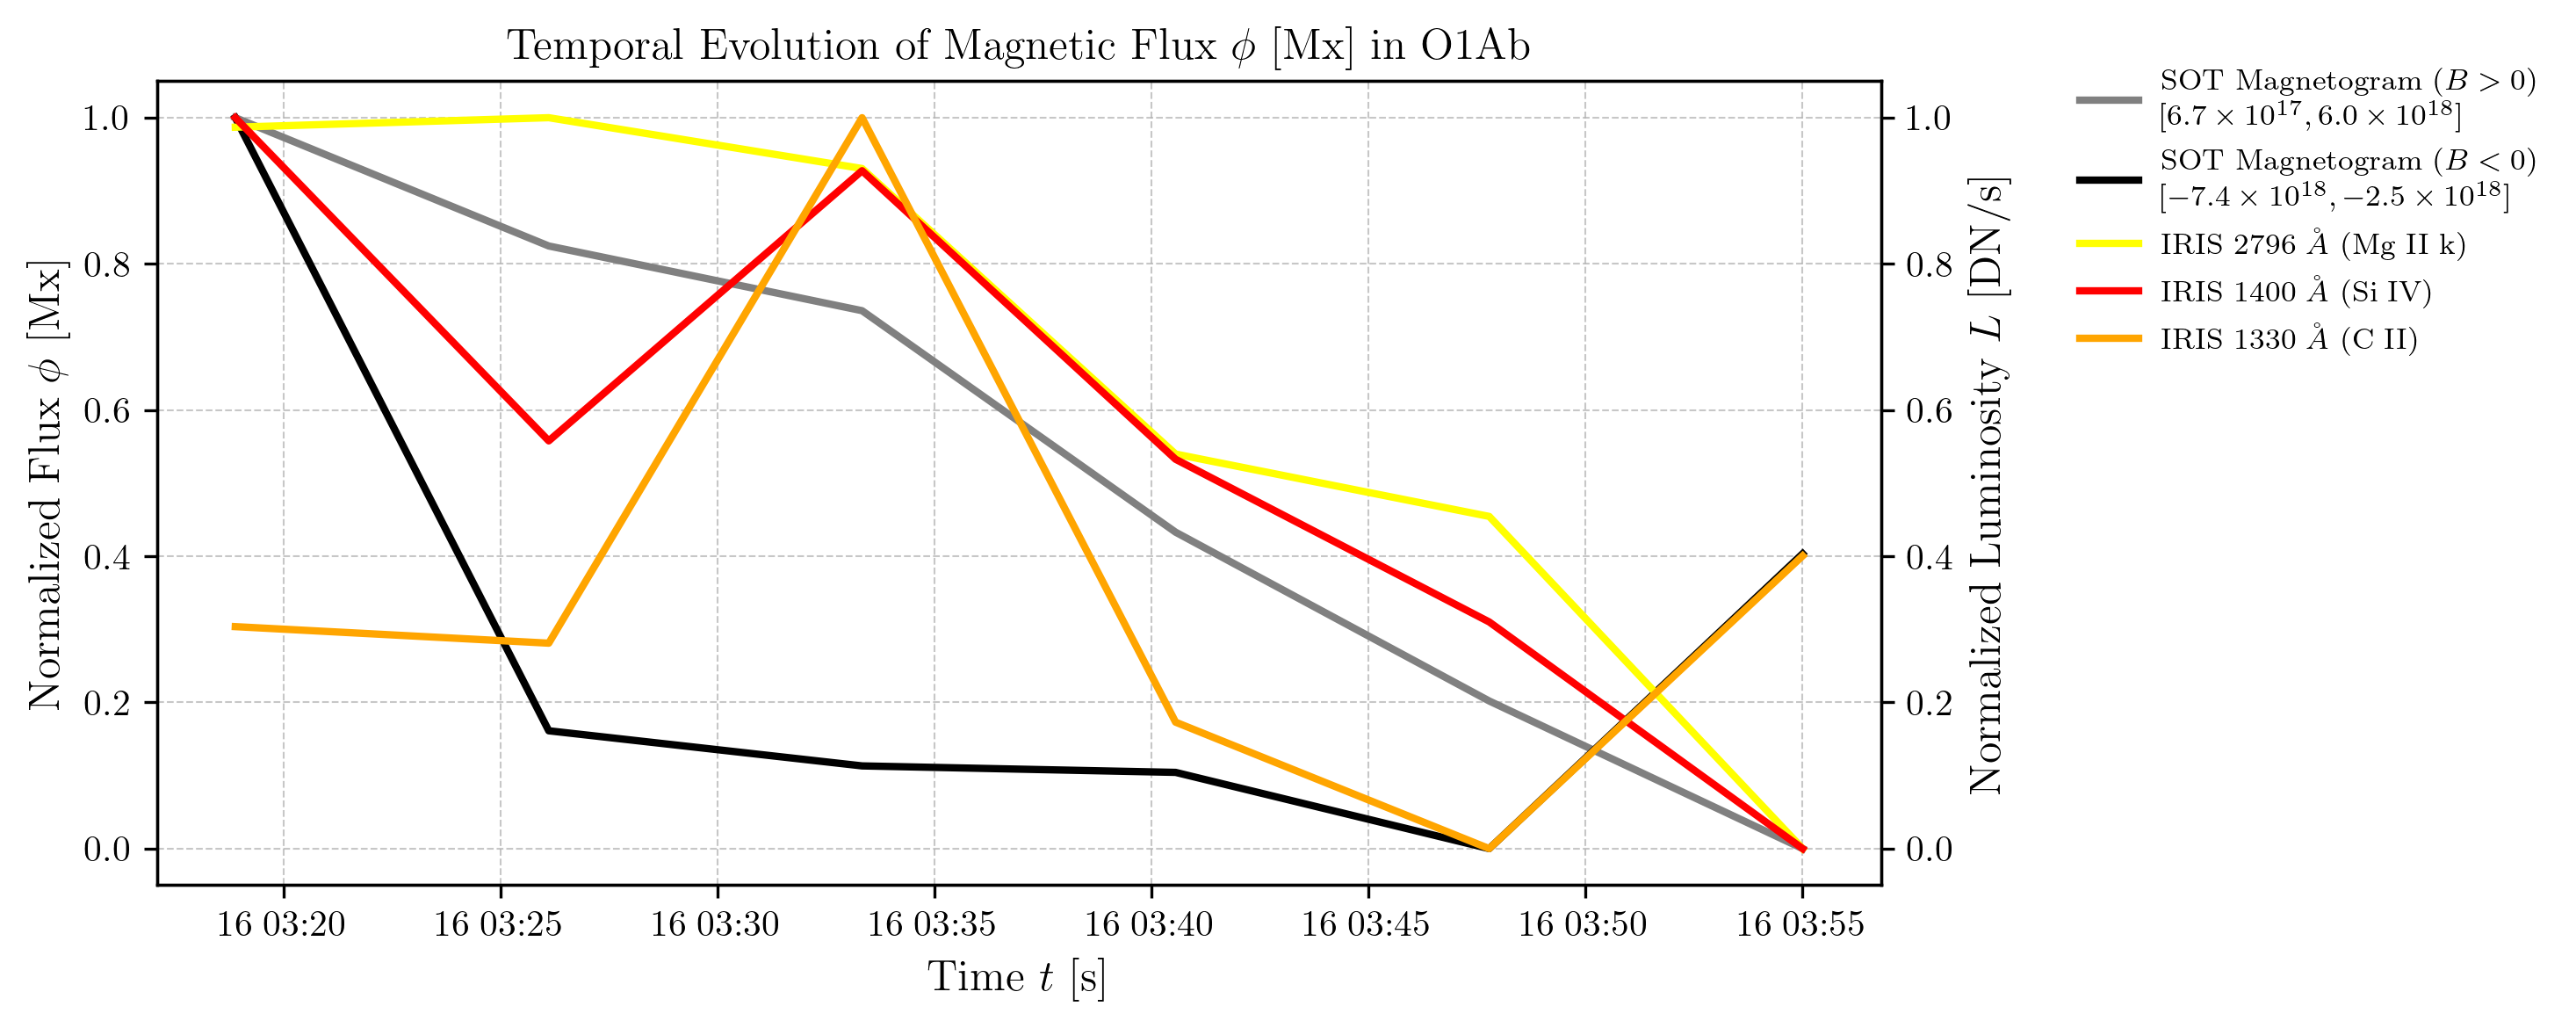

{'frames': range(25, 34), 'bl': (292, 67), 'tr': (315, 93), 'dims': (20, 25), 'pol': 1}


{'frames': range(35, 41), 'bl': (280, 85), 'tr': (300, 119), 'dims': (20, 30), 'pol': -1}


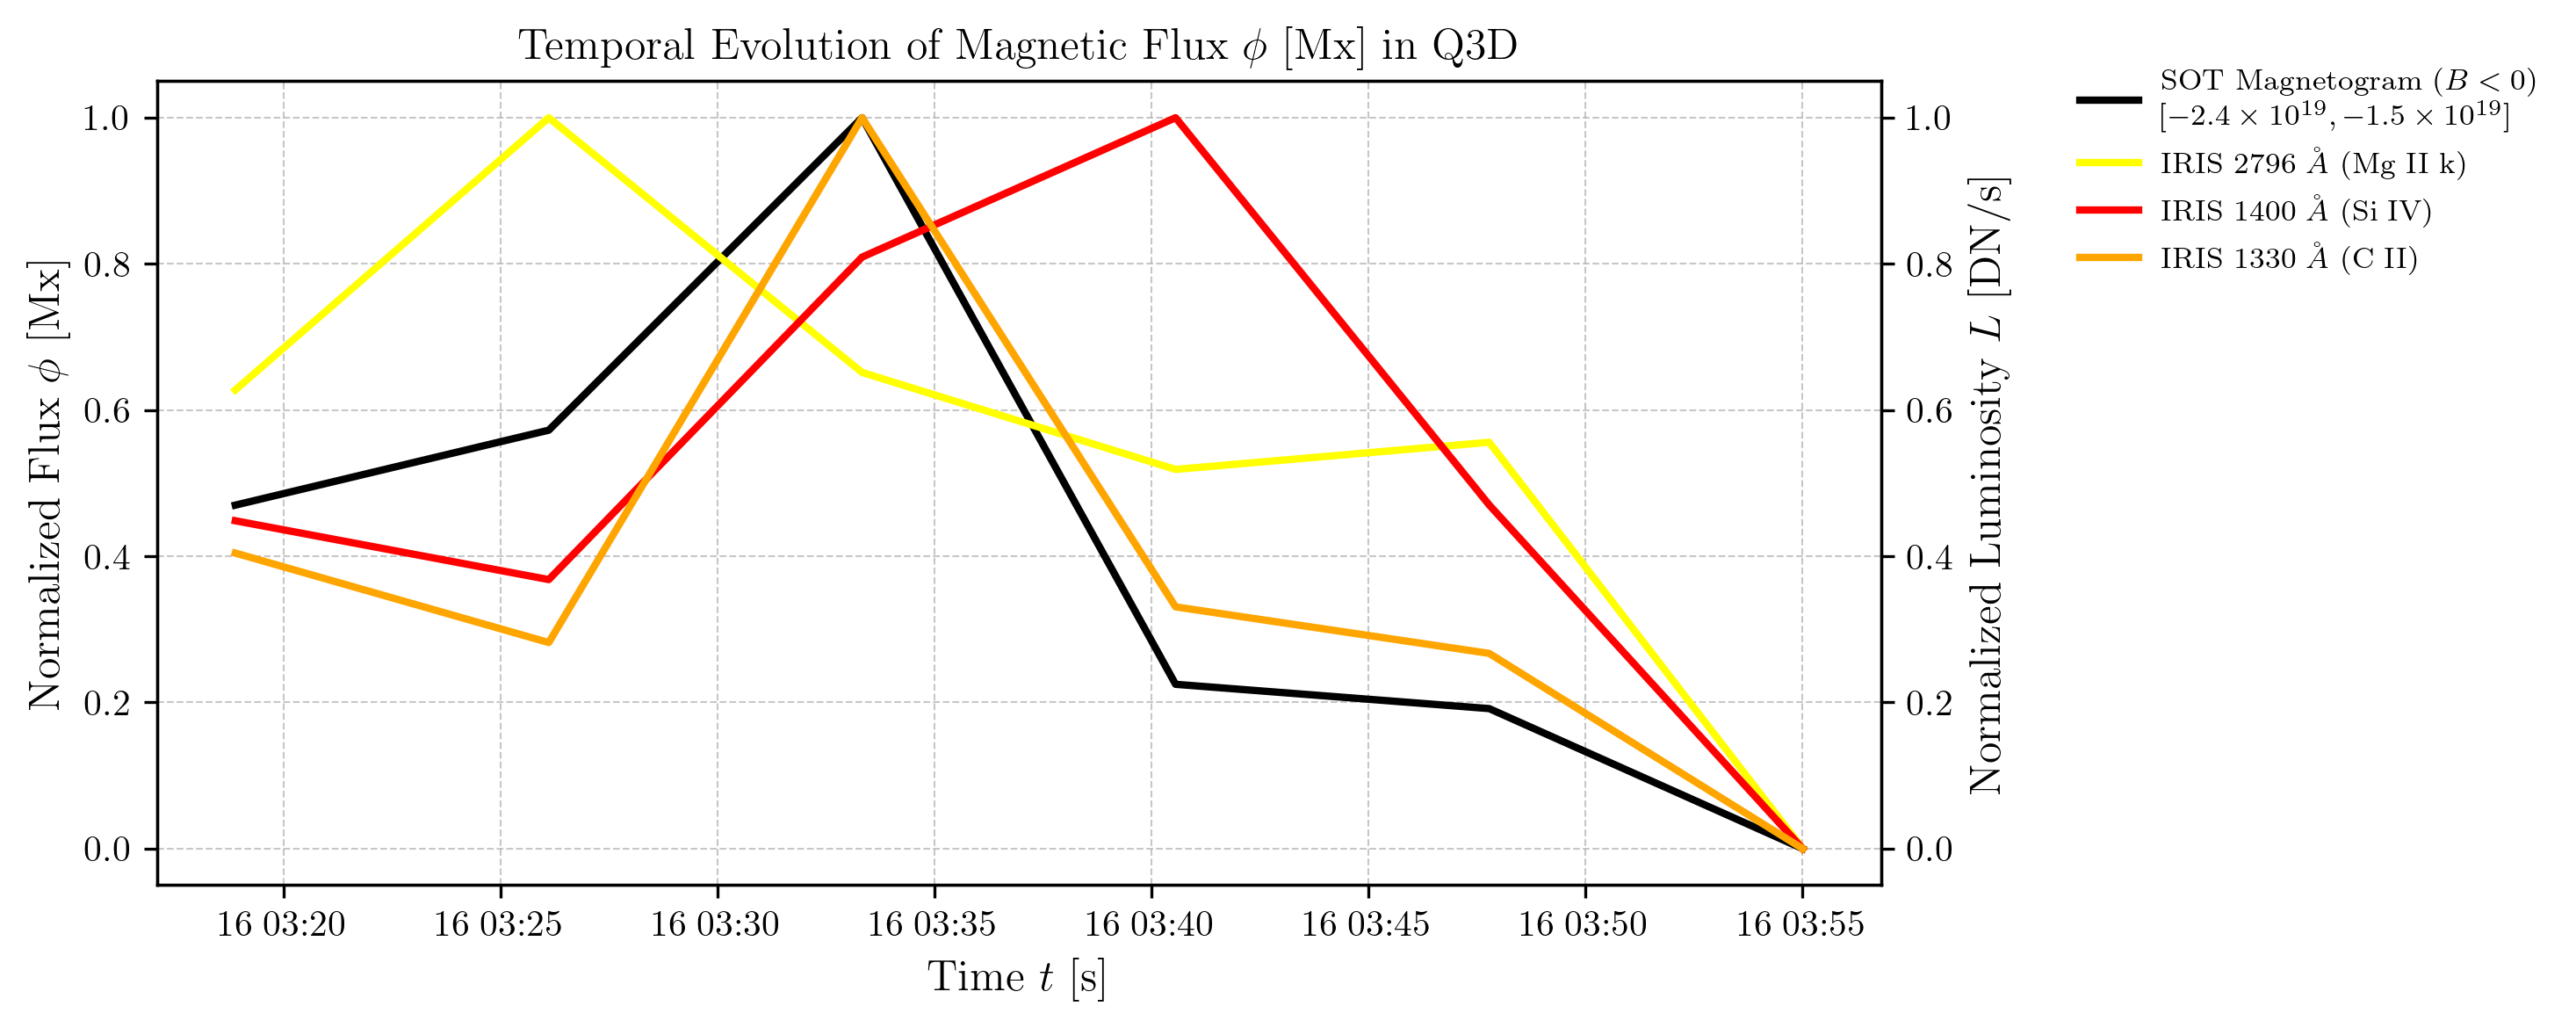

{'frames': range(15, 21), 'bl': (321, 103), 'tr': (335, 116), 'dims': (20, 15), 'pol': 1}


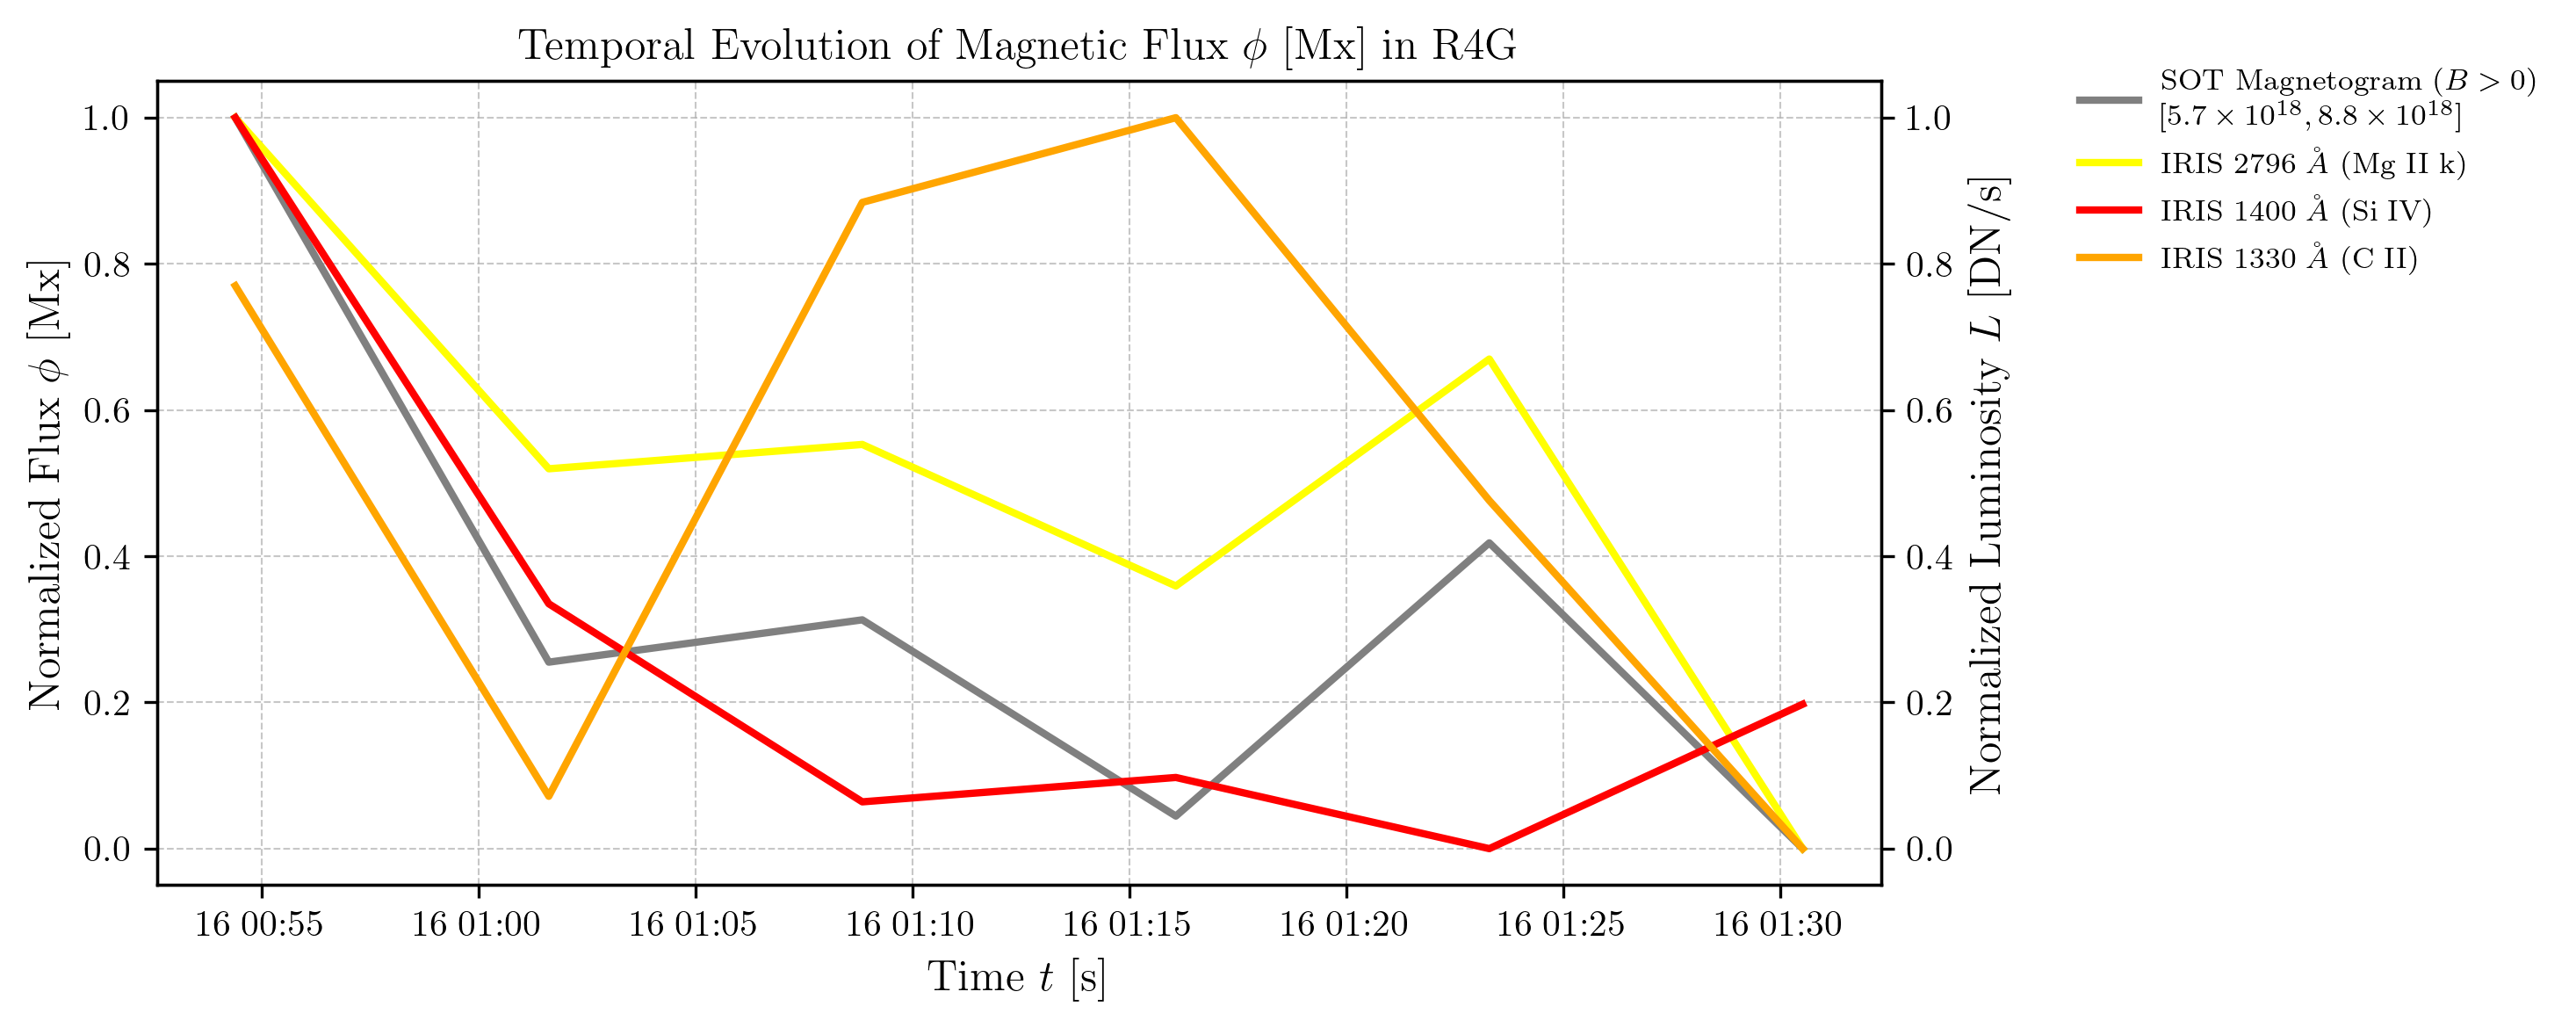

{'frames': range(20, 26), 'bl': (281, 53), 'tr': (298, 69), 'dims': (15, 20), 'pol': -1}


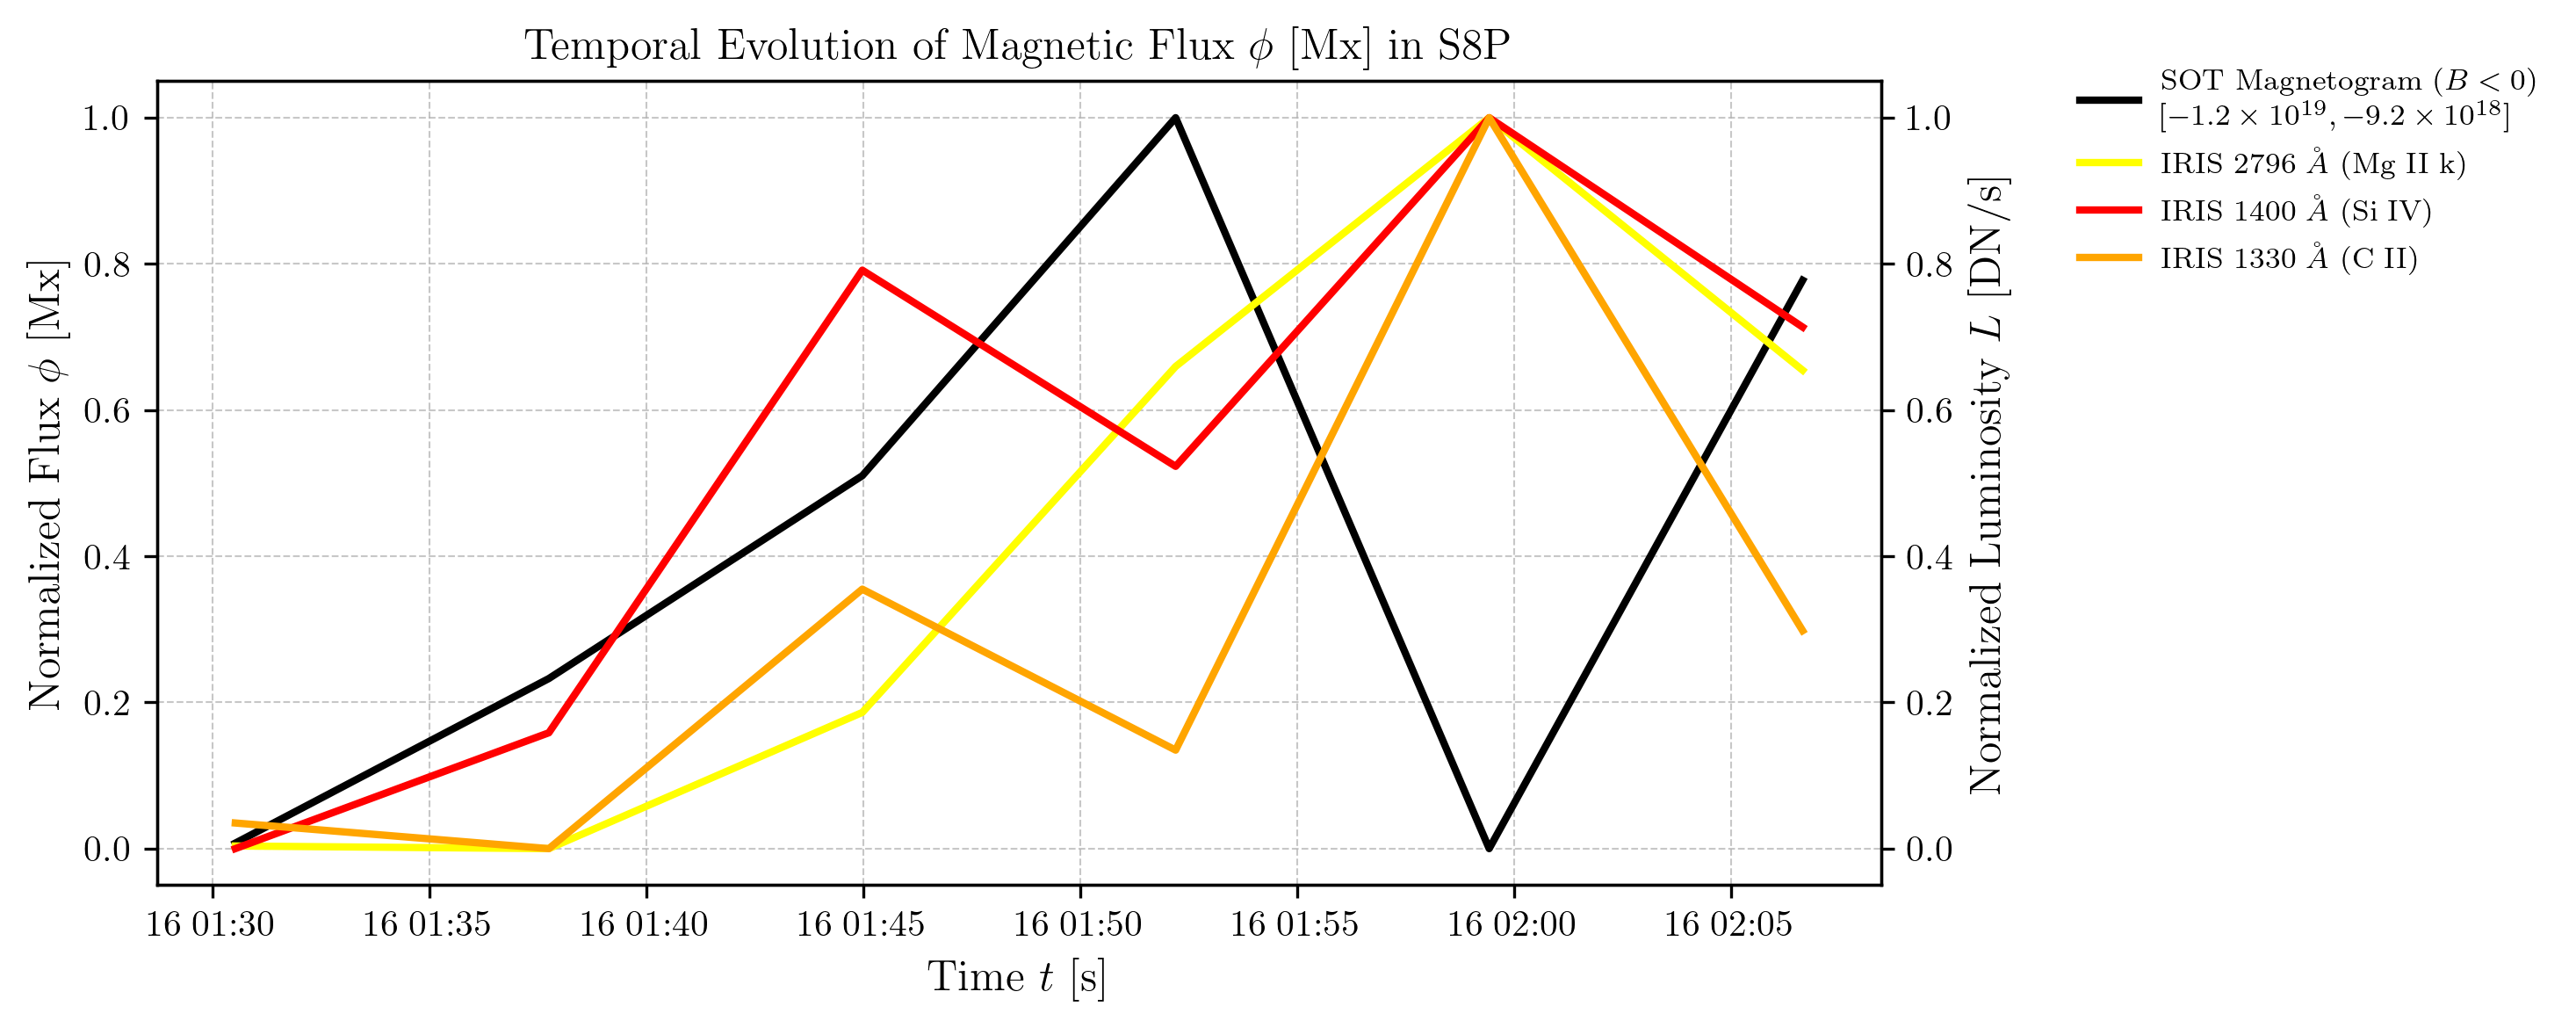

{'frames': range(10, 18), 'bl': (282, 65), 'tr': (315, 88), 'dims': (25, 20), 'pol': 1}


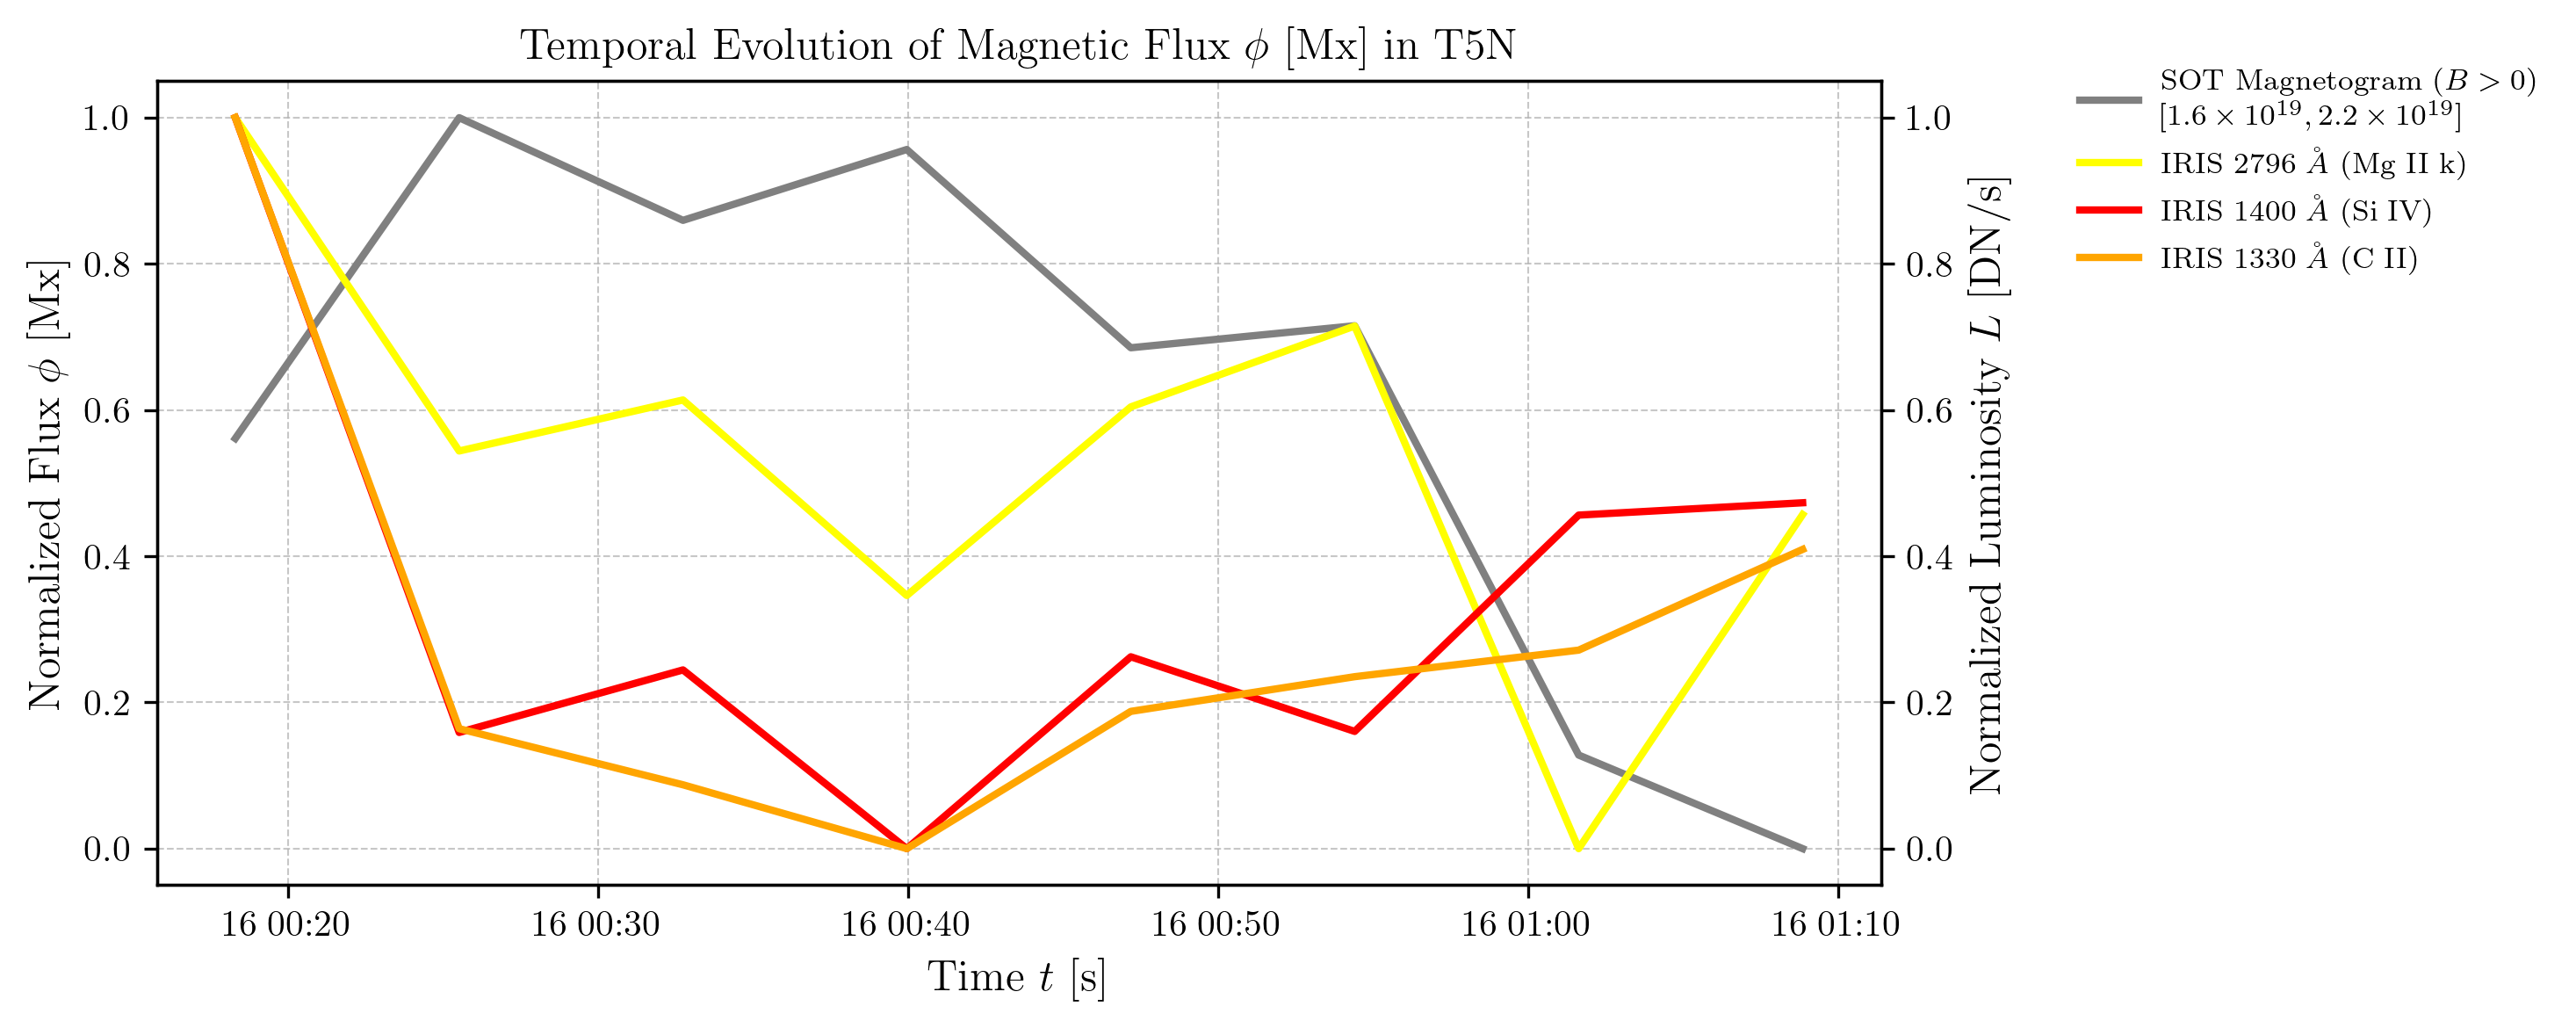

{'frames': range(21, 27), 'bl': (25, 15), 'tr': (52, 45), 'dims': (20, 25), 'pol': 0}


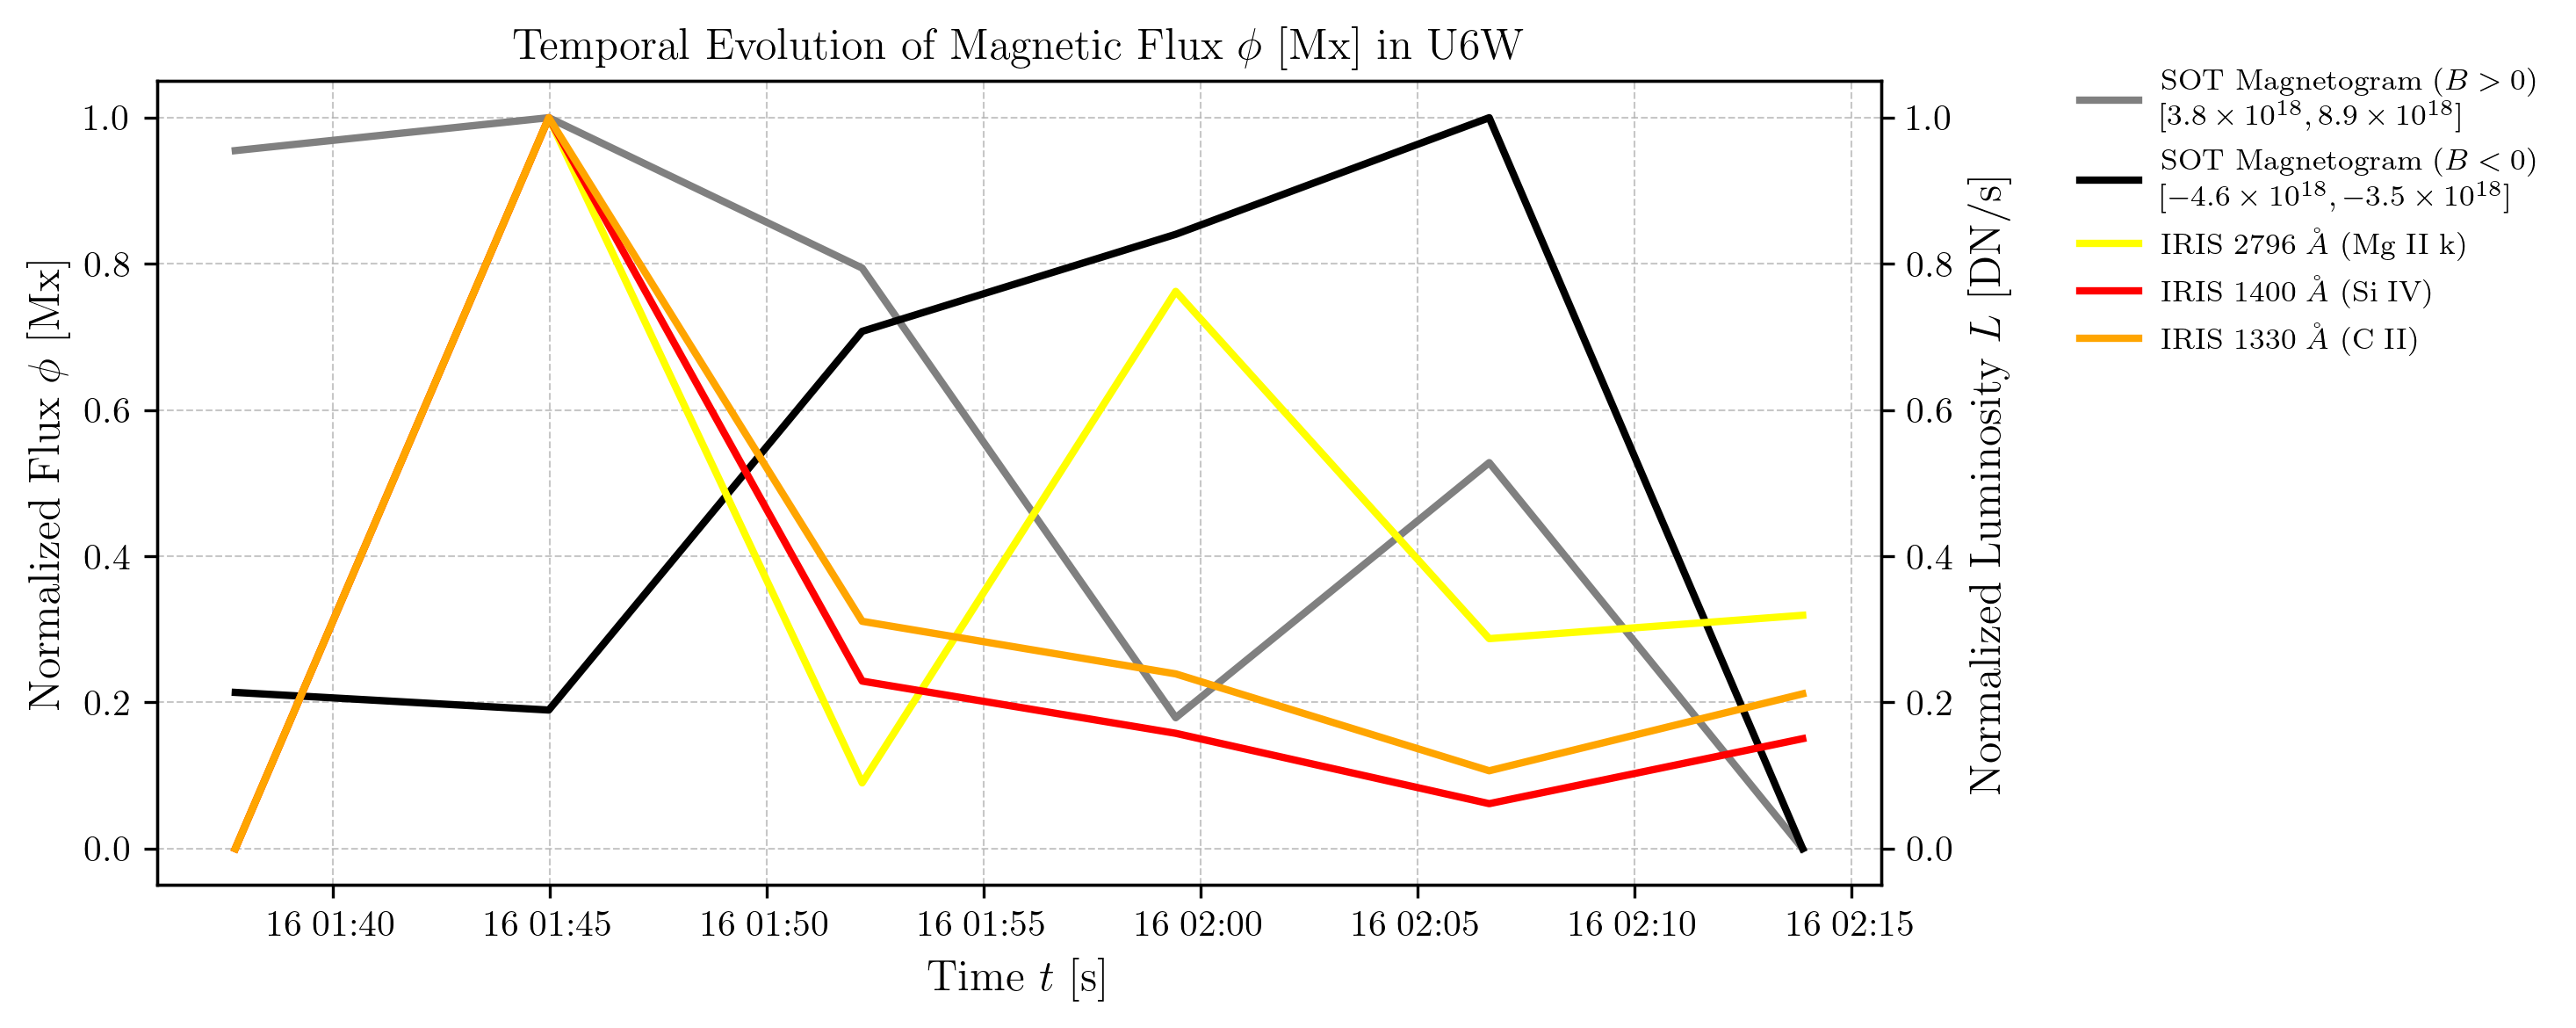

{'frames': range(4, 13), 'bl': (290, 30), 'tr': (305, 50), 'dims': (20, 30), 'pol': 1}


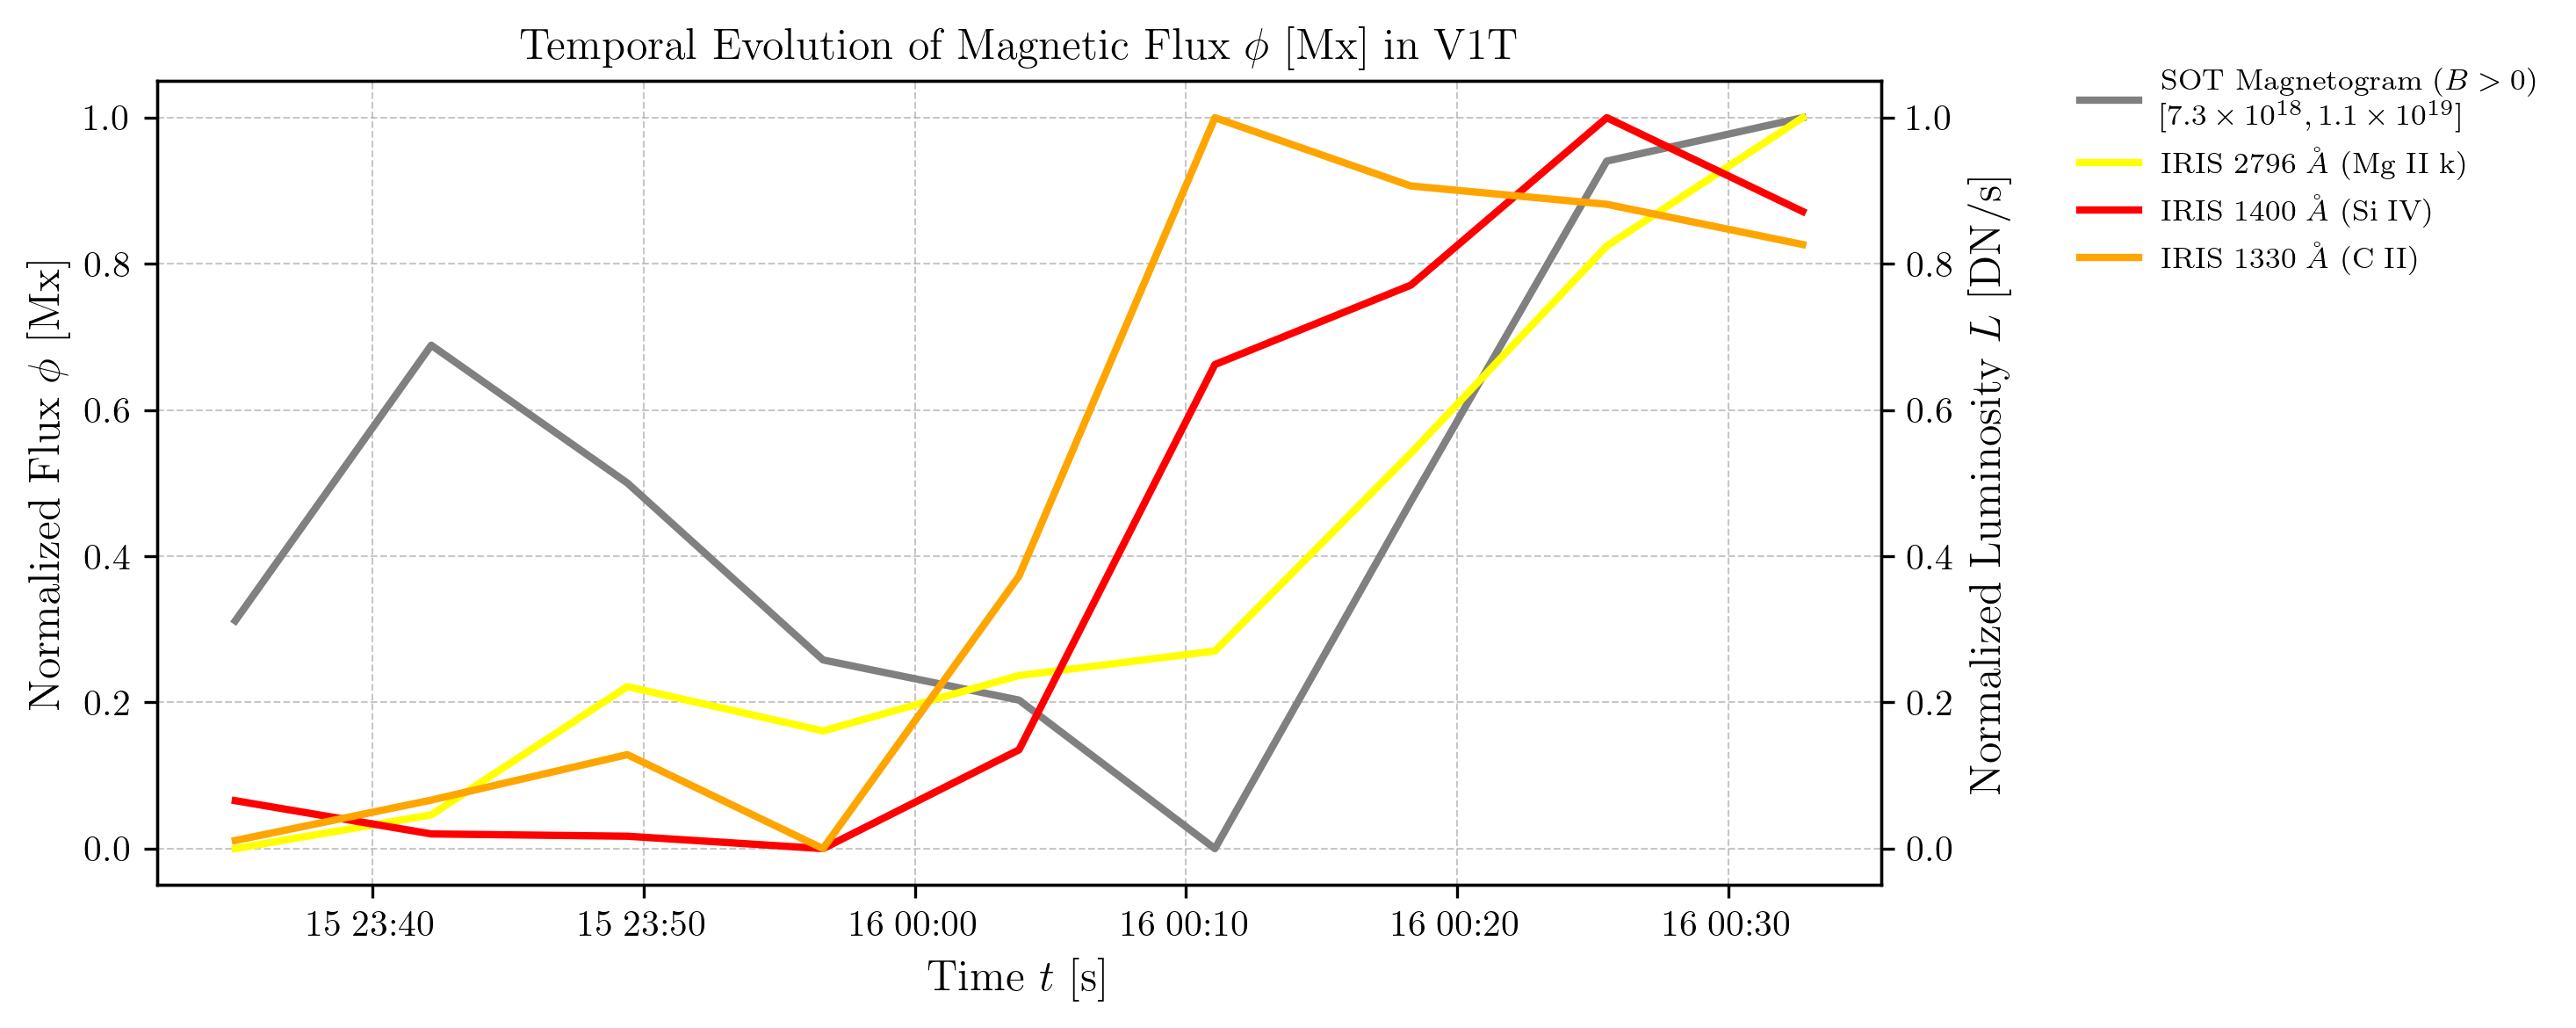

{'frames': range(2, 9), 'bl': (245, 63), 'tr': (278, 95), 'dims': (25, 25), 'pol': -1}


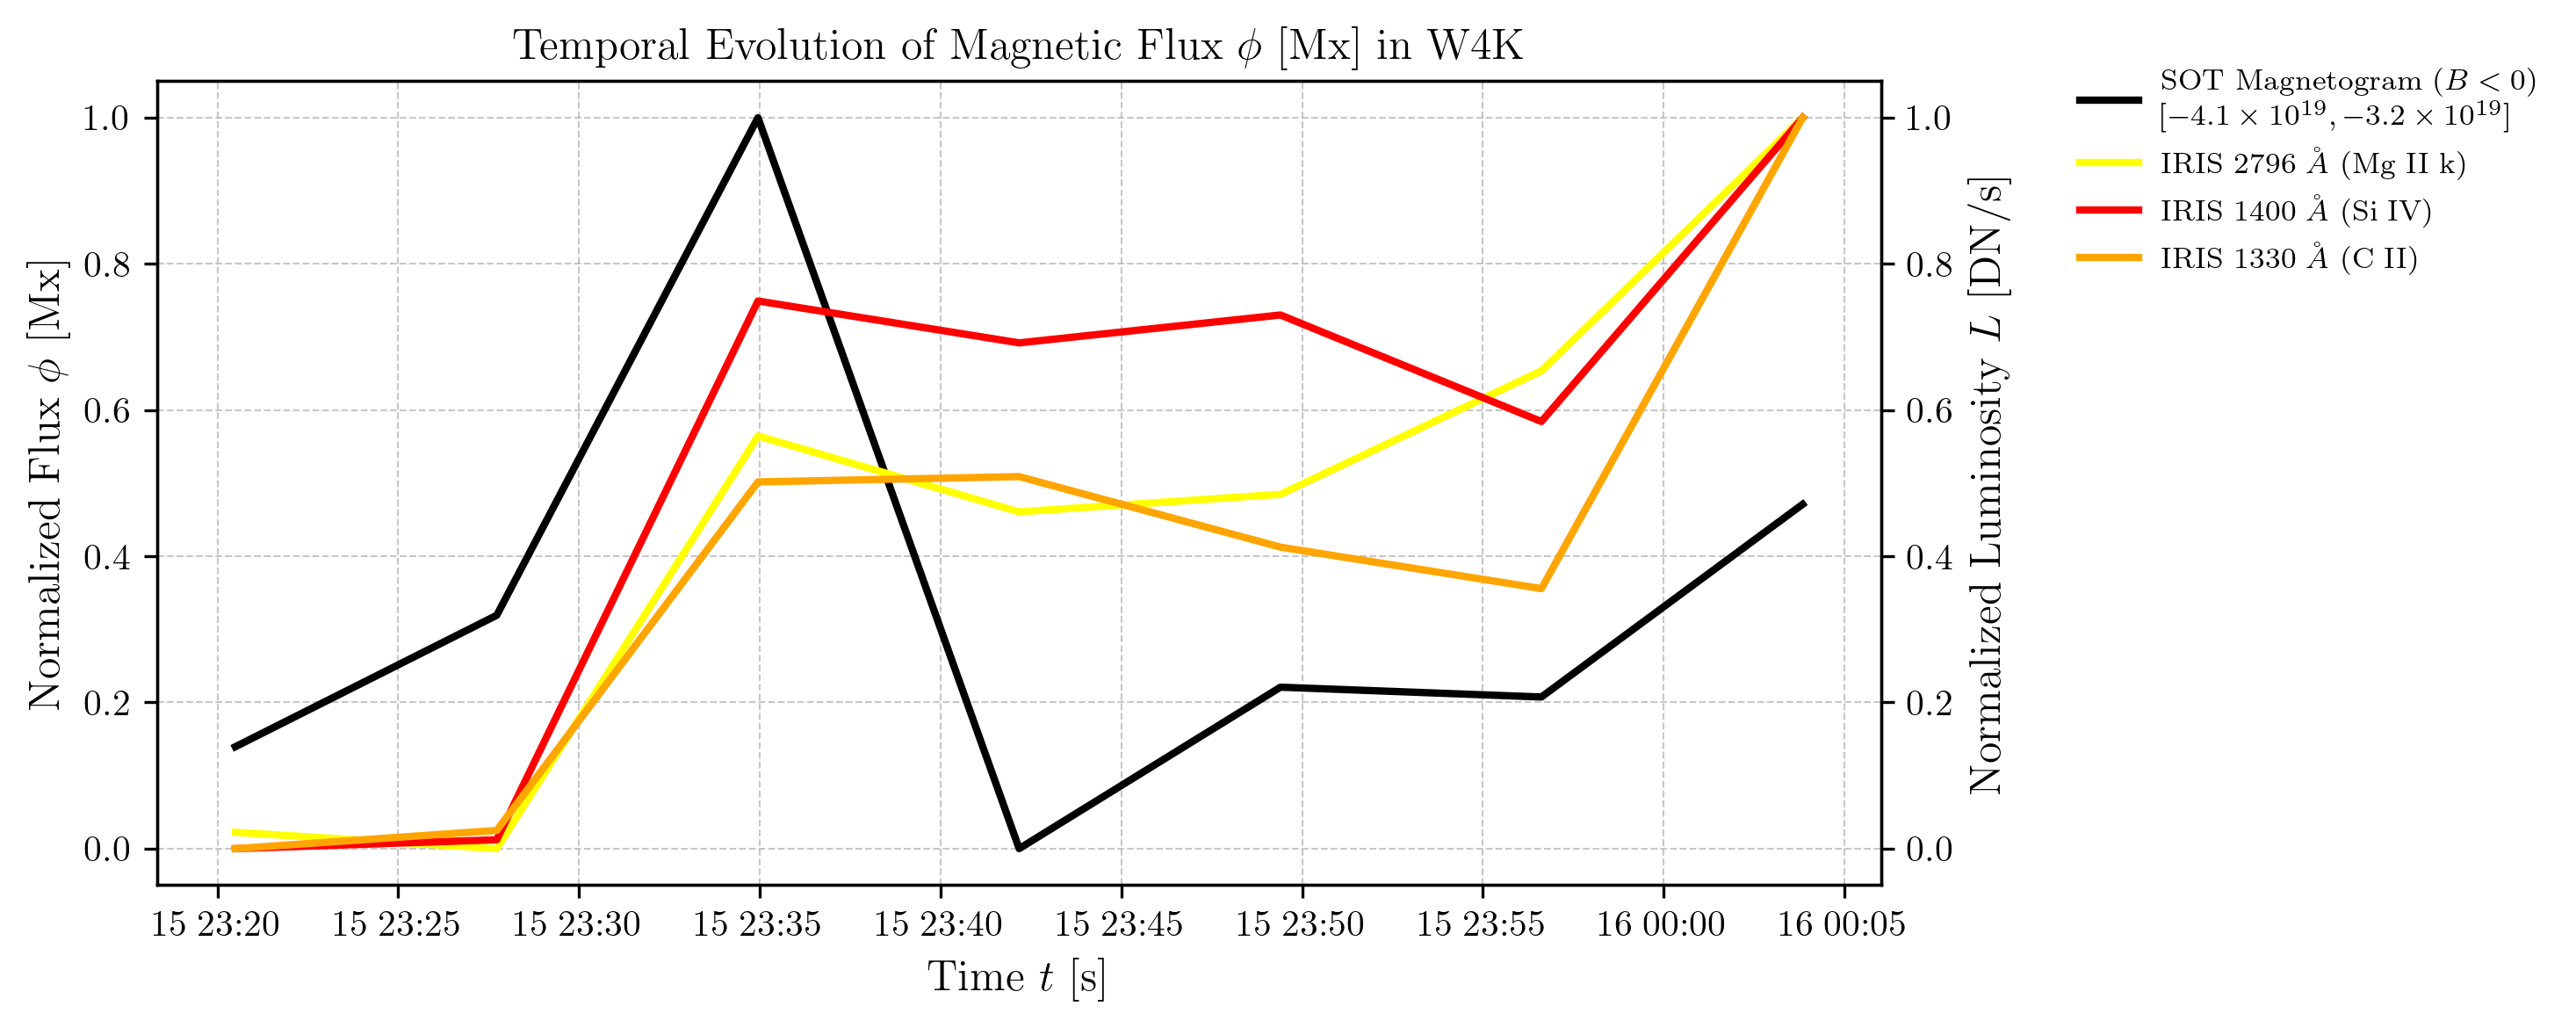

{'frames': range(24, 28), 'bl': (210, 86), 'tr': (225, 105), 'dims': (15, 25), 'pol': 0}


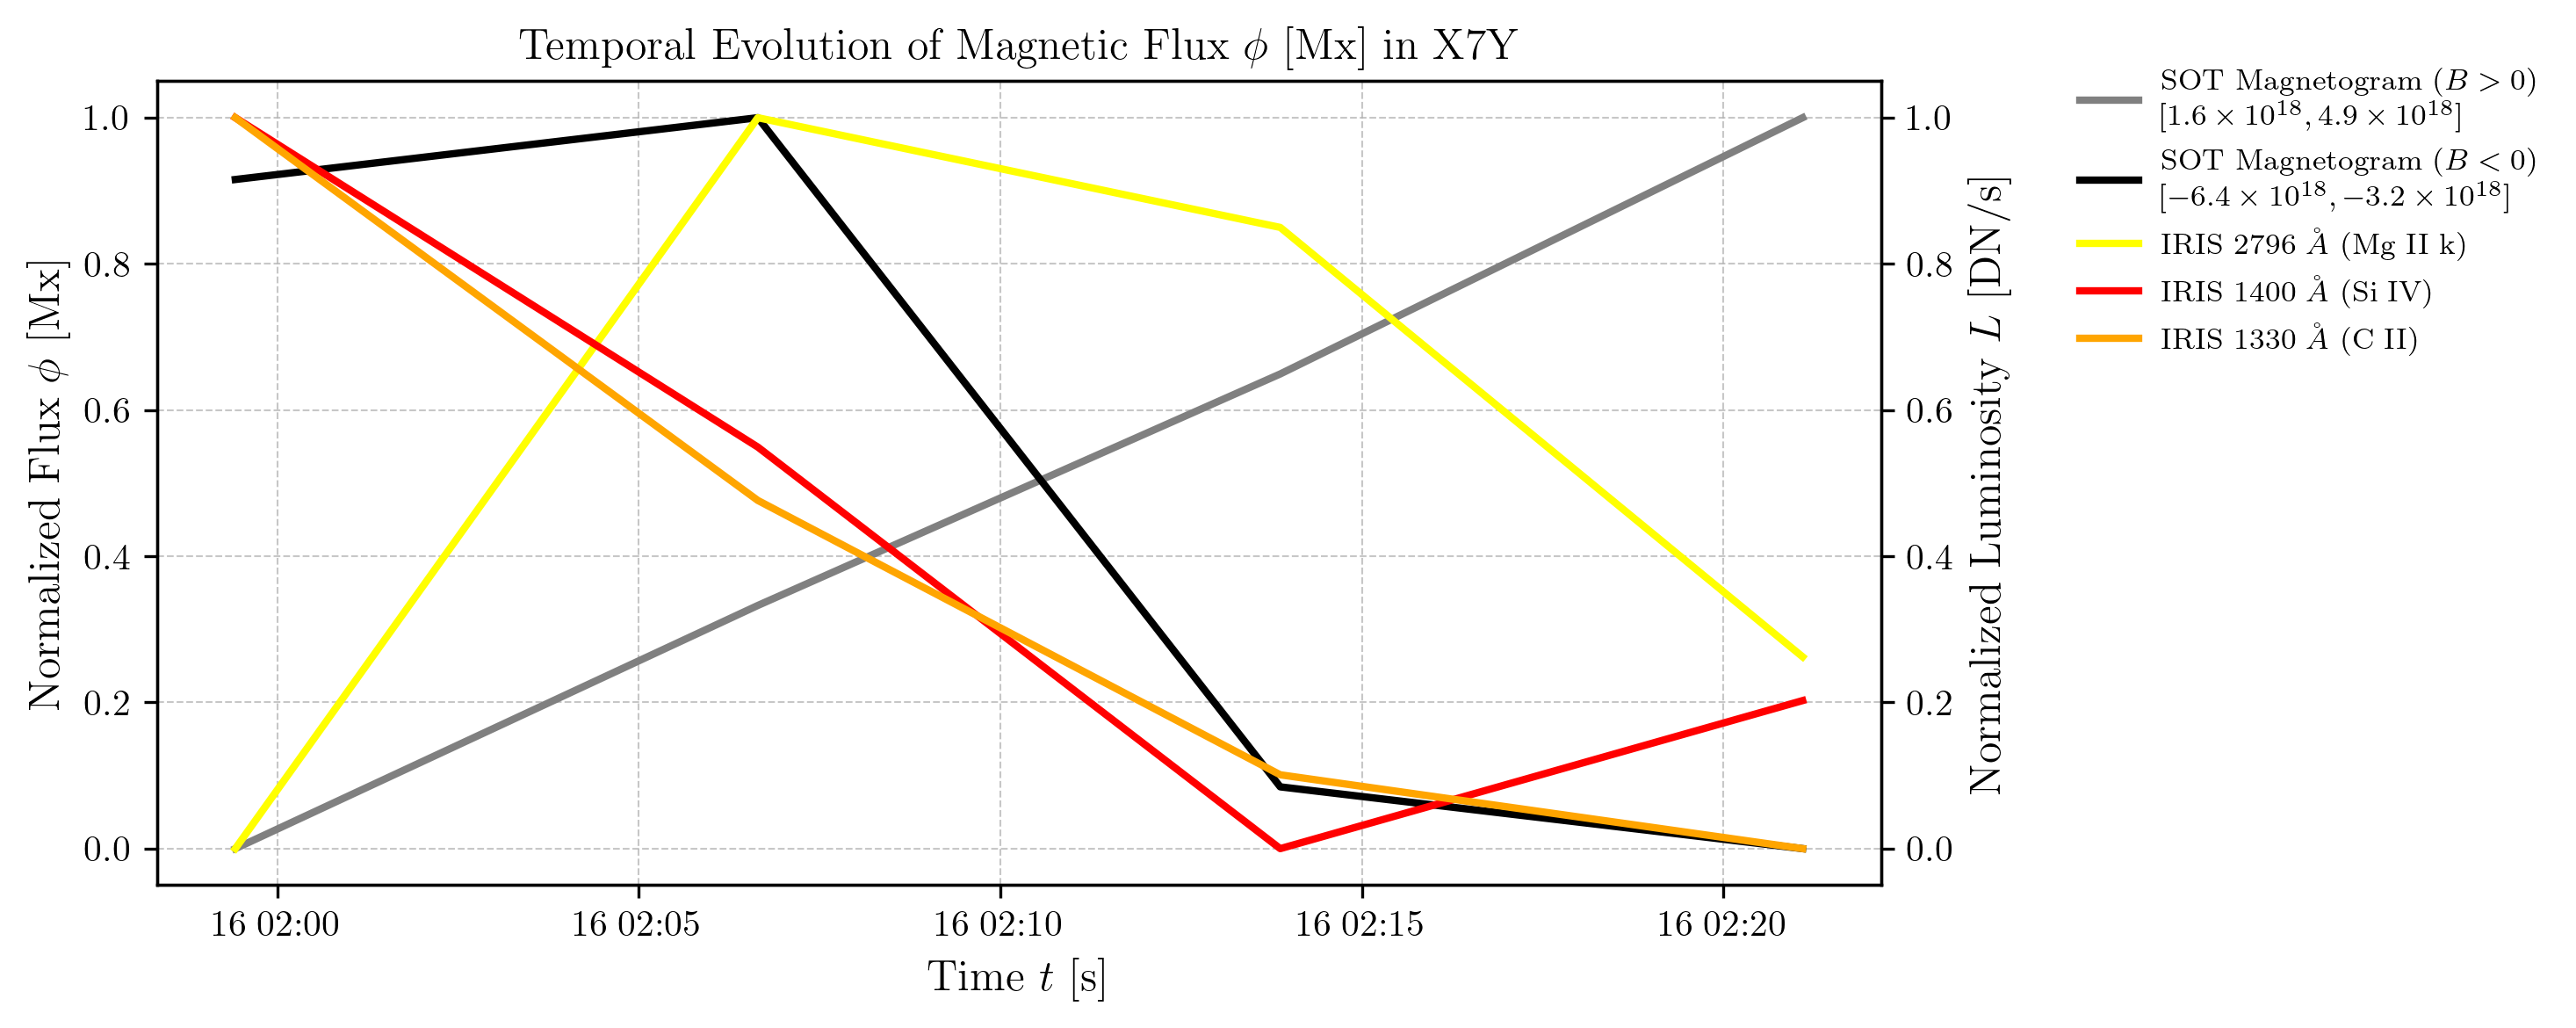

{'frames': range(24, 29), 'bl': (274, 74), 'tr': (288, 106), 'dims': (20, 35), 'pol': 0}


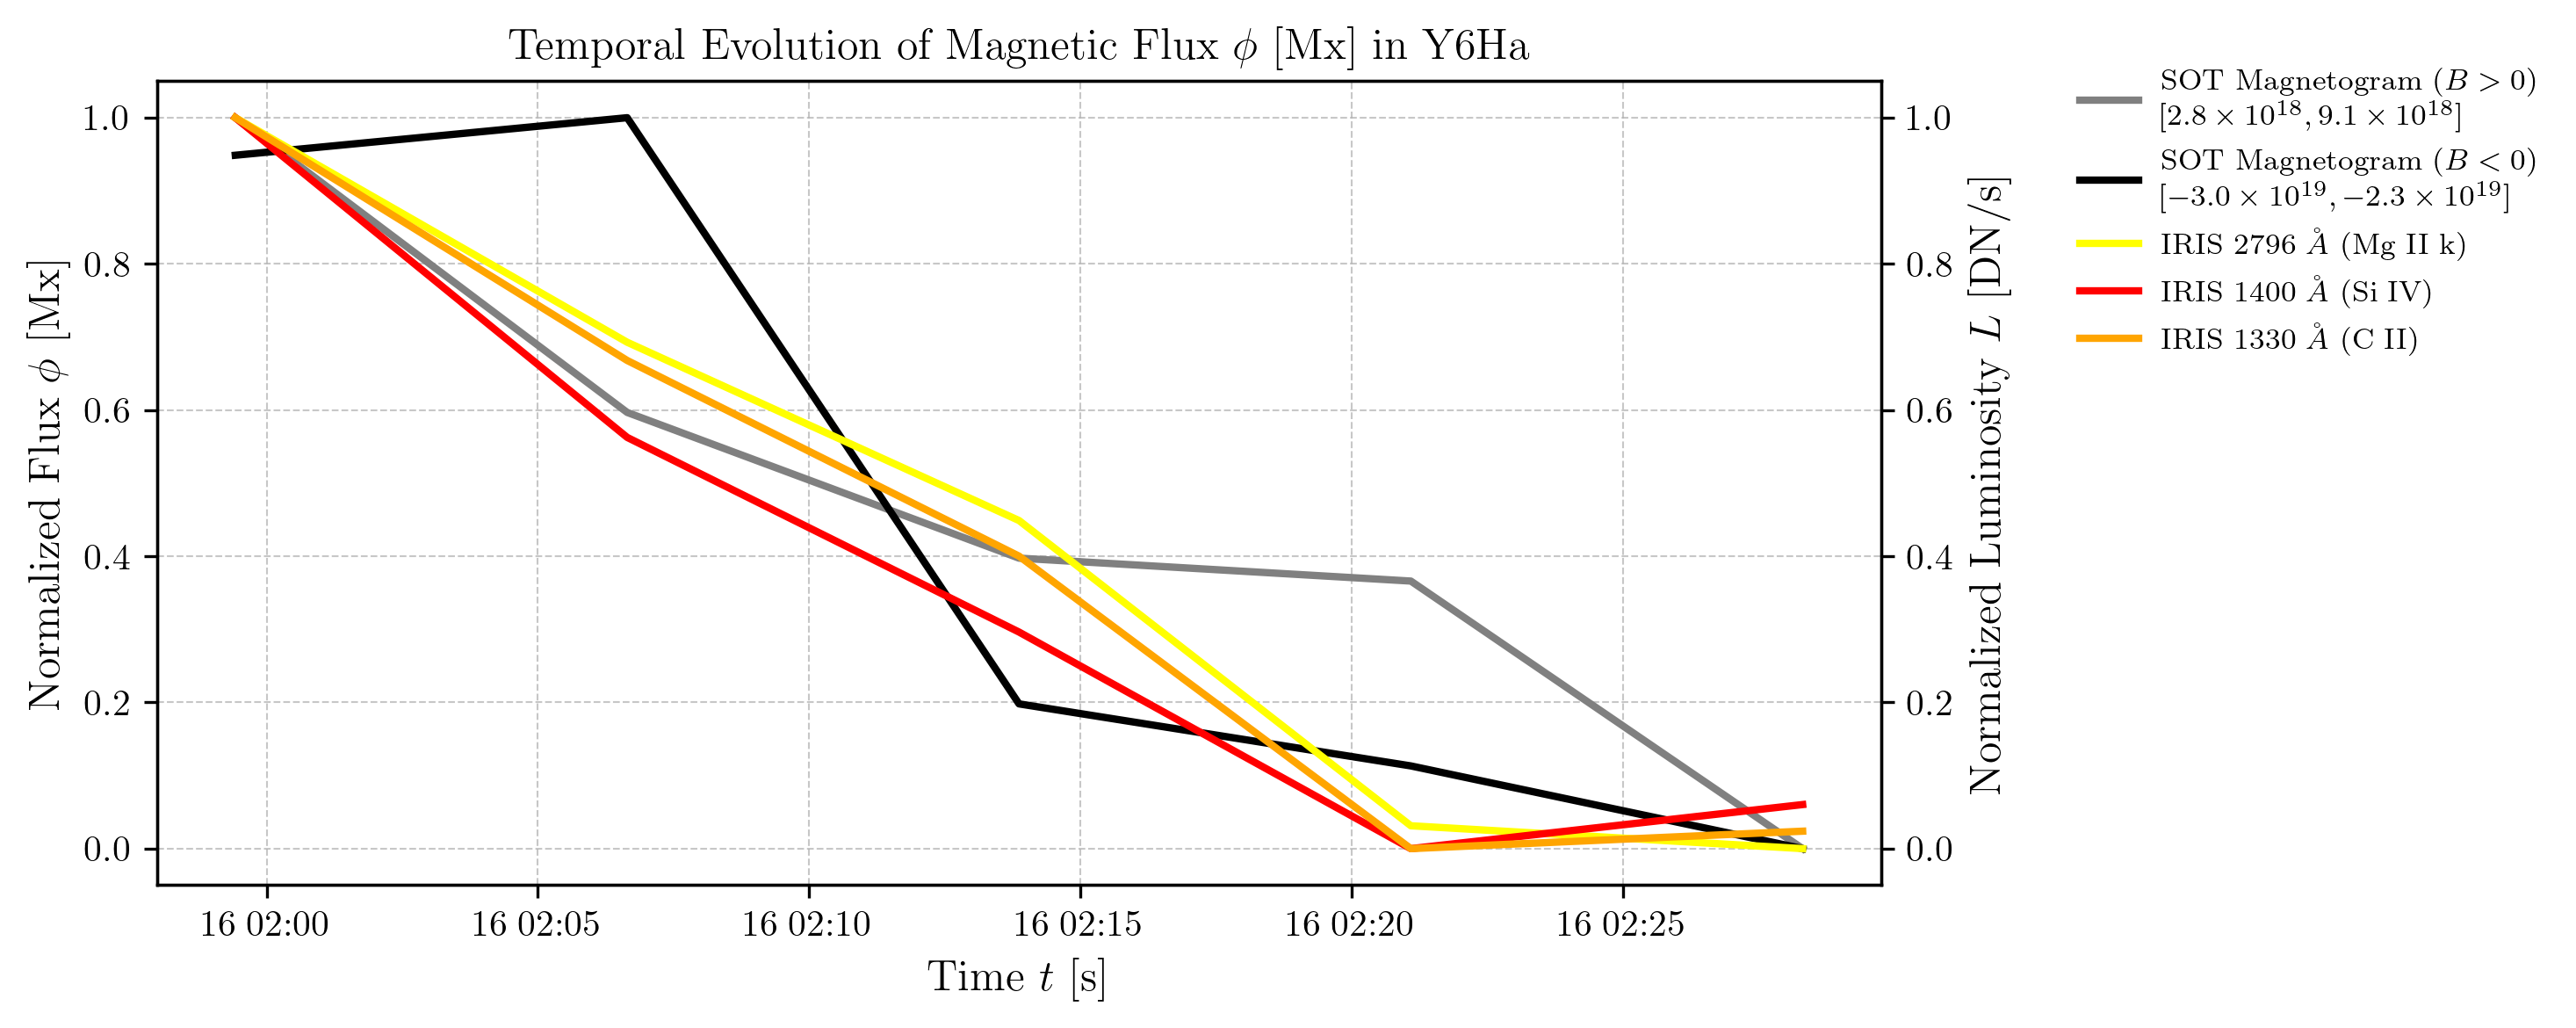

{'frames': range(29, 32), 'bl': (274, 74), 'tr': (288, 106), 'dims': (20, 35), 'pol': 0}


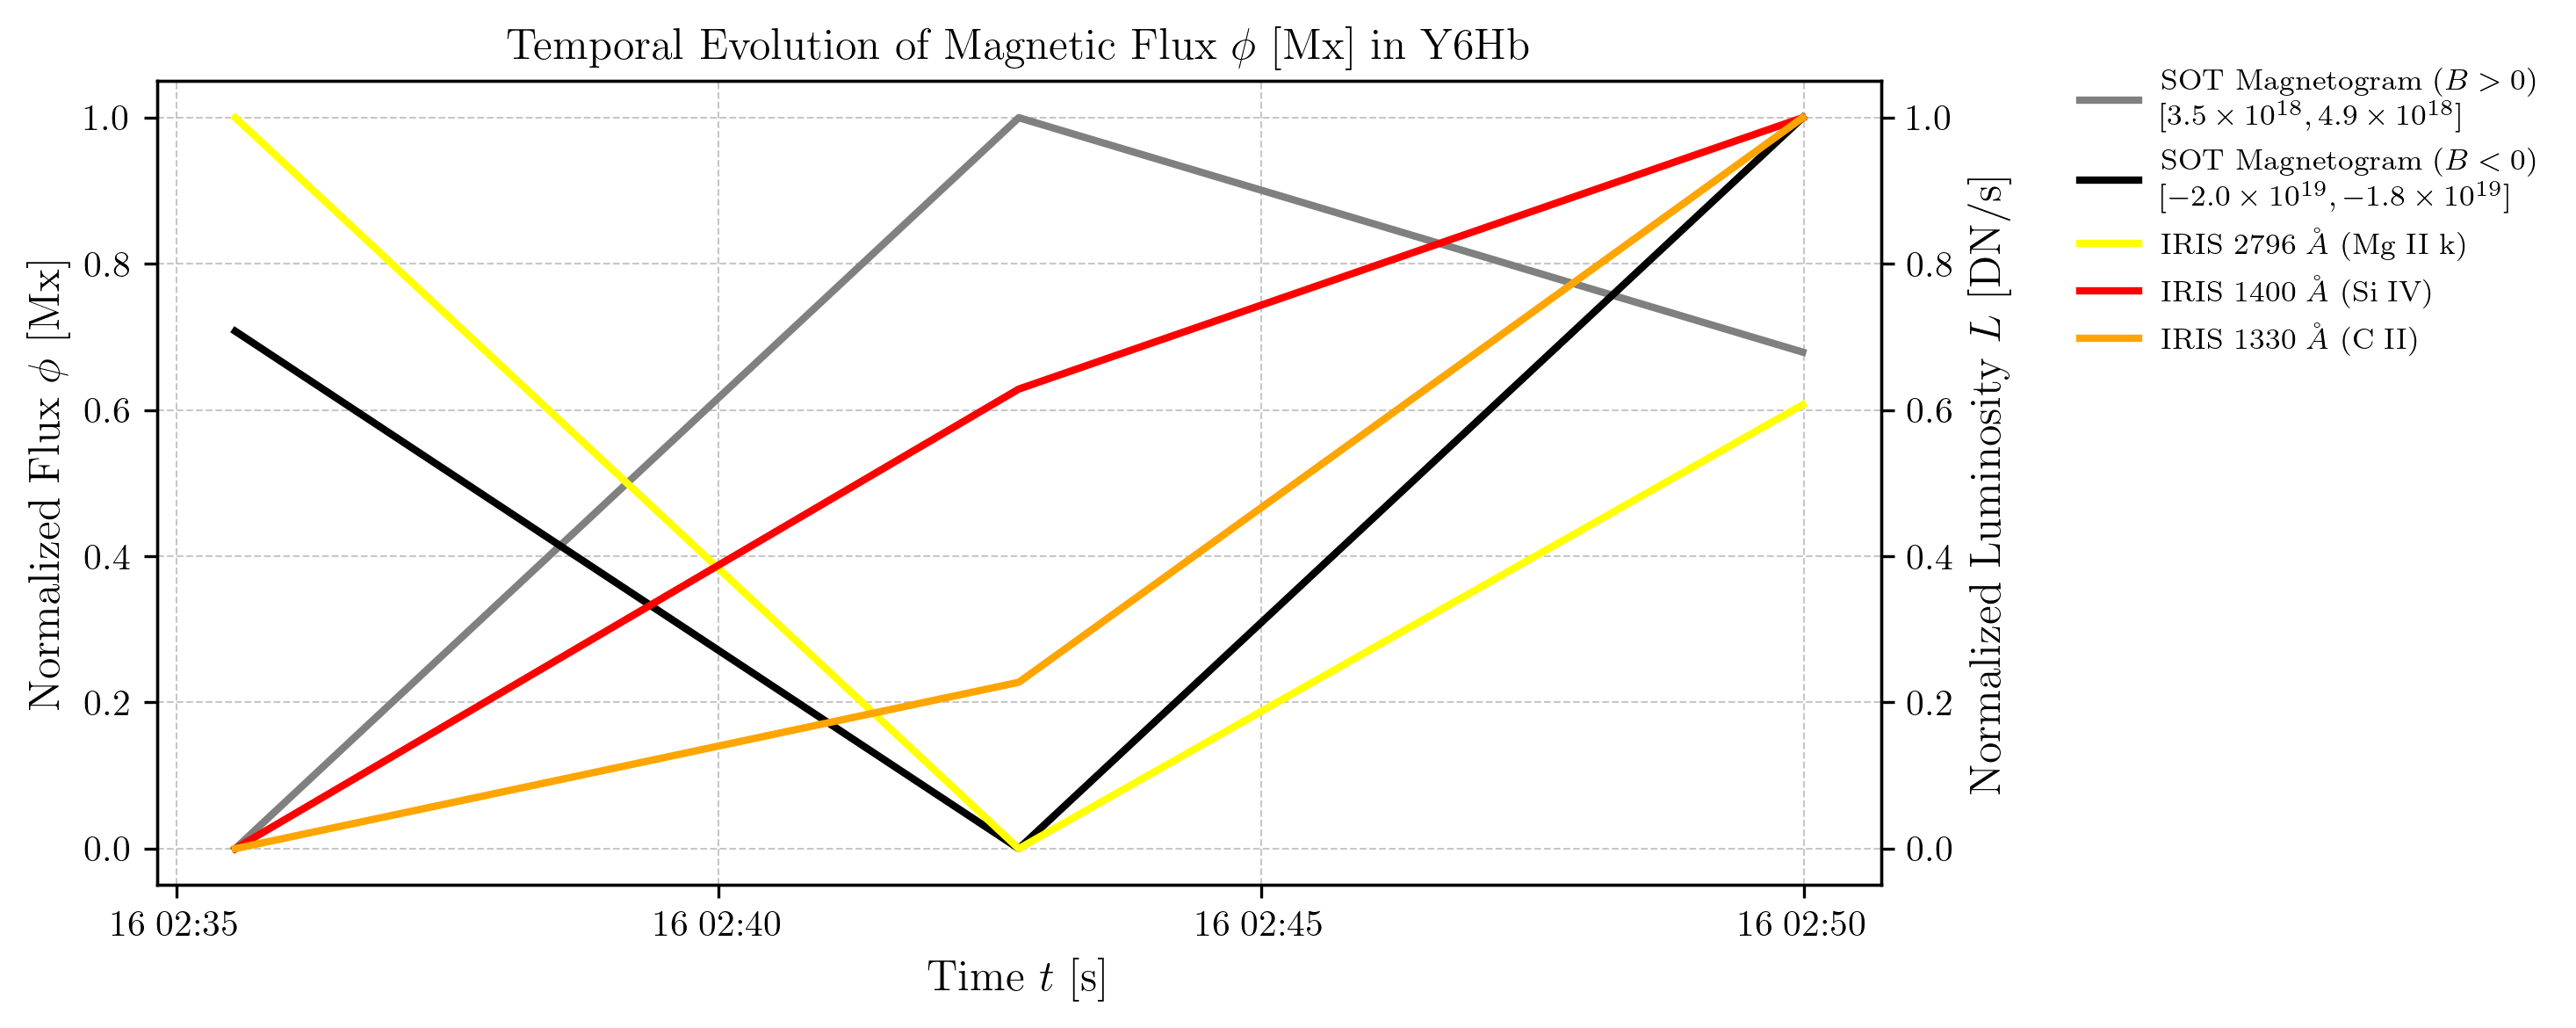

{'frames': range(37, 41), 'bl': (270, 51), 'tr': (299, 71), 'dims': (25, 25), 'pol': 0}


In [ ]:
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
sheet_url = "https://docs.google.com/spreadsheets/d/1MIDnWIfctyEjJoG0Ch13E-rPKIdcO6bprD5GGqjjRtQ/edit?gid=0#gid=0"
sh = gc.open_by_url(sheet_url)
worksheet = sh.sheet1
all_dat = get_as_dataframe(worksheet)
heights = [5.5, 4, 4, 5, 7, 5, 5, 5, 5, 4, 3.5, 5, 5, 5, 4, 4, 6, 4, 6, 5, 4, 5, 4, 4, 4, 5]
for n in range(len(all_dat)):
  dat = all_dat.iloc[n]
  IDENT = dat['name']
  MMF = {
      'frames' : range(int(dat['start']), int(dat['end'])),
      'bl' : le(dat['bl']),
      'tr' : le(dat['tr']),
      'dims' : le(dat['dims']),
      'pol' : int(dat['pol'])
  }
  print(MMF)
  make_pdfs_graphs_new(MMF, IDENT, heights[n])

In [ ]:
def print_lifetimes(mmf):
    from datetime import datetime
    first = mmf['frames'][0]
    last = mmf['frames'][-1]
    time1 = ms_bz.maps[first].meta['date_obs'].strftime('%Y-%m-%dT%H:%M:%S.%f')
    time2 = ms_bz.maps[last].meta['date_obs'].strftime('%Y-%m-%dT%H:%M:%S.%f')
    life_time = time2 - time1
    print(life_time)